In [17]:
# -*- coding: utf-8 -*-

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import time
import math
import random
import pandas as pd
import scipy.signal
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as dist
from data_prepare_for_many import *
#from data_prepare_nobehavior import *

torch.manual_seed(1)

MAX_LENGTH = 100
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print('ok')
length = 31
predict_length = 30
batch_size = 128
file_path_train = np.array(glob('data/data_interactive/train/*'))
Training_generator,WholeSet_train= get_dataloader(batch_size,length,predict_length,file_path_train,'train')

ok
****************************************************************************************************
训练轨迹轨迹条数： 384866
---轨迹输入数据结构： torch.Size([128, 31, 43]) ---轨迹输出数据结构： torch.Size([128, 31, 4])
---轨迹长度： 31 ---预测轨迹长度： 30


In [22]:
# -*- coding: utf-8 -*-

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import time
import math
import random
import pandas as pd
import scipy.signal
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as dist
from data_prepare_for_many import *
#from data_prepare_nobehavior import *

torch.manual_seed(1)

MAX_LENGTH = 100
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print('ok')
length = 31
predict_length = 30
batch_size = 128
file_path_train = np.array(glob('data/data_interactive/train/*'))
file_path_test = np.array(glob('data/data_interactive/test/*'))
file_path_valid = np.array(glob('data/data_interactive/valid/*'))
#Training_generator1, Test, Valid, WholeSet= get_dataloader(batch_size,length,predict_length)
Training_generator,WholeSet_train= get_dataloader(batch_size,length,predict_length,file_path_train,'train')
Test,WholeSet= get_dataloader(batch_size,length,predict_length,file_path_test,'test')
Valid, WholeSet_valid = get_dataloader(batch_size,length,predict_length,file_path_valid,'valid')
print('sss')
class TraPred(nn.Module):
    def __init__(self, input_size, output_size,hidden_size,batch_size, dropout=0.5):
        super(TraPred, self).__init__()
        
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = 2

        self.in2lstm = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,num_layers=self.num_layers,bidirectional=False,batch_first=True,dropout =dropout)
        self.in2bilstm = nn.Linear(input_size, hidden_size)
        self.bilstm = nn.LSTM(hidden_size, hidden_size//2,num_layers=self.num_layers,bidirectional=True,batch_first=True,dropout =dropout)
    
        self.fc0 = nn.Linear(hidden_size,hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2,int(hidden_size/2))
        self.in2out = nn.Linear(input_size, int(hidden_size/2))
        self.fc2 = nn.Linear(int(hidden_size/2) ,output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, input):
        #input = tensor shape[batchsize, len, num_features]
        bilstm_out,_= self.bilstm(self.in2bilstm(input))
        lstm_out,_= self.lstm(self.in2lstm(input))
        out = self.tanh(self.fc0(lstm_out+bilstm_out))
        out = self.tanh(self.fc1(out))
        out =  out + self.in2out(input)
        output = self.fc2(out)# range [0 -> 1 ]
        return output

ok
****************************************************************************************************
训练轨迹轨迹条数： 384866
---轨迹输入数据结构： torch.Size([128, 31, 43]) ---轨迹输出数据结构： torch.Size([128, 31, 4])
---轨迹长度： 31 ---预测轨迹长度： 30
****************************************************************************************************
测试轨迹轨迹条数： 12031
---轨迹输入数据结构： torch.Size([128, 31, 43]) ---轨迹输出数据结构： torch.Size([128, 31, 4])
---轨迹长度： 31 ---预测轨迹长度： 30
****************************************************************************************************
验证轨迹轨迹条数： 35913
---轨迹输入数据结构： torch.Size([128, 31, 43]) ---轨迹输出数据结构： torch.Size([128, 31, 4])
---轨迹长度： 31 ---预测轨迹长度： 30
sss


In [2]:
def normalize_data(data):
    data = np.asarray(data.cpu())
    data = torch.from_numpy(data)
    for i in range(data.shape[0]):
        A = np.array(data[i]).astype(np.float64)
        A = torch.from_numpy(A)
        mn = torch.mean(A, dim=0)
        rg = (torch.max(A, dim=0).values - torch.min(A, dim=0).values) / 2.0
        rg = torch.ones(rg.shape, dtype=torch.double)
        std = torch.std(A, dim=0)
        for j in range(std.size(0)):
            if std[j] == 0:
                std[j] = 1
        data[i] = (data[i] - mn) / (std * rg)
    data = np.asarray(data).astype(np.float64)
    data = torch.from_numpy(data)
    return (data)

In [5]:
def trainIters(encoder, epoches,learning_rate=0.0001,print_every=7):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer,mode='min',
factor=0.1, patience=120,verbose=True,threshold=0.0001,threshold_mode='rel',cooldown=0,min_lr=0,eps=1e-015)
    #criterion = nn.MSELoss(reduction='sum')
    criterion = nn.MSELoss()
    loss_min = np.inf
    train_losses =[]
    valid_losses =[]
    encoder.train()
    for e in range(1, epoches + 1):
        train_loss = []
        for batch_i,(local_batch, local_labels) in enumerate(Training_generator):
            encoder.zero_grad()
#             local_batch = normalize_data(local_batch)
#             local_labels = normalize_data(local_labels)
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)
            
            predY = encoder(local_batch)
            loss = criterion(predY,local_labels).to(device)
            loss.backward()
            encoder_optimizer.step()
            train_loss.append(loss.item())
            if batch_i % print_every == 0:     
                valid_loss = []
                encoder.eval()
                for x,y in Valid:
#                     x = normalize_data(x)
#                     y = normalize_data(y)
                    x,y = x.to(device),y.to(device)
                    predict = encoder(x)
                    loss_valid = criterion(predict,y)
                    valid_loss.append(loss_valid.item())
                encoder.train()
                train_loss_mean = np.mean(train_loss)
                valid_loss_mean = np.mean(valid_loss)
                train_losses.append(train_loss_mean)
                valid_losses.append(valid_loss_mean)
                scheduler.step(valid_loss_mean)
                print("Epoch:{}/{},Step:{}/{}".format(e,epoches,batch_i,len(Training_generator)),
                  "Train_Loss:{},Valid_Loss: {}".format(train_loss_mean,valid_loss_mean))
                if valid_loss_mean < loss_min :                             
                    print("valid_loss decrease!!!save the model.")
                    loss_min = valid_loss_mean
                    torch.save(encoder.state_dict(),'model/trajectory_predict_1202_43_4_30_new.pt')
                #torch.save(encoder.state_dict(),'model/trajectory_predict_68_4_30_each.pt')
    plt.plot(train_losses,color = 'r',label = 'Train_Loss')
    plt.plot(valid_losses,color = 'g',label = 'Valid_Loss')
    plt.title('Loss_Trend')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    plt.legend()
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.savefig('image/trajectory_loss_1202_43_4_30.svg',dpi=600)

In [6]:
train_iter = iter(Training_generator)
x, y = train_iter.next()
print(x.shape, y.shape)
hidden_size = 64
drop = 0.5
Prednet = TraPred(x.shape[2], y.shape[2], hidden_size, x.shape[0],drop)

torch.Size([128, 31, 43]) torch.Size([128, 31, 4])


Epoch:1/20,Step:0/3007 Train_Loss:1.134124109676429,Valid_Loss: 1.0921205697810823
valid_loss decrease!!!save the model.
Epoch:1/20,Step:20/3007 Train_Loss:0.8023616596712396,Valid_Loss: 0.3738655160866186
valid_loss decrease!!!save the model.
Epoch:1/20,Step:40/3007 Train_Loss:0.5516087987314304,Valid_Loss: 0.18737388628698257
valid_loss decrease!!!save the model.
Epoch:1/20,Step:60/3007 Train_Loss:0.42345511339579556,Valid_Loss: 0.087574831010211
valid_loss decrease!!!save the model.
Epoch:1/20,Step:80/3007 Train_Loss:0.34272662104981644,Valid_Loss: 0.06625134479530269
valid_loss decrease!!!save the model.
Epoch:1/20,Step:100/3007 Train_Loss:0.290106422832494,Valid_Loss: 0.05865659692077394
valid_loss decrease!!!save the model.
Epoch:1/20,Step:120/3007 Train_Loss:0.2532825027749356,Valid_Loss: 0.0514727654856722
valid_loss decrease!!!save the model.
Epoch:1/20,Step:140/3007 Train_Loss:0.22594159973769382,Valid_Loss: 0.04675198656559133
valid_loss decrease!!!save the model.
Epoch:1/20

Epoch:1/20,Step:1520/3007 Train_Loss:0.04321007718736156,Valid_Loss: 0.014837198279416586
Epoch:1/20,Step:1540/3007 Train_Loss:0.04286885329468994,Valid_Loss: 0.014958251795090813
Epoch:1/20,Step:1560/3007 Train_Loss:0.042513336726135956,Valid_Loss: 0.01433302380860488
valid_loss decrease!!!save the model.
Epoch:1/20,Step:1580/3007 Train_Loss:0.042165339573226664,Valid_Loss: 0.014219809018433319
valid_loss decrease!!!save the model.
Epoch:1/20,Step:1600/3007 Train_Loss:0.04183510982193569,Valid_Loss: 0.01501564709586337
Epoch:1/20,Step:1620/3007 Train_Loss:0.04165056965385215,Valid_Loss: 0.014469153399453231
Epoch:1/20,Step:1640/3007 Train_Loss:0.04134565359268092,Valid_Loss: 0.016069027683033386
Epoch:1/20,Step:1660/3007 Train_Loss:0.04104272366230842,Valid_Loss: 0.014115589231537447
valid_loss decrease!!!save the model.
Epoch:1/20,Step:1680/3007 Train_Loss:0.04073742612972209,Valid_Loss: 0.014564909161704866
Epoch:1/20,Step:1700/3007 Train_Loss:0.04045166205055508,Valid_Loss: 0.01409

Epoch:2/20,Step:180/3007 Train_Loss:0.013885571643696285,Valid_Loss: 0.012386693990217924
Epoch:2/20,Step:200/3007 Train_Loss:0.014057360311443846,Valid_Loss: 0.012465903135328337
Epoch:2/20,Step:220/3007 Train_Loss:0.014098051094730323,Valid_Loss: 0.012524895035249804
Epoch:2/20,Step:240/3007 Train_Loss:0.014065500657297966,Valid_Loss: 0.012567696178373881
Epoch:2/20,Step:260/3007 Train_Loss:0.014285237619983451,Valid_Loss: 0.012463797412261616
Epoch:2/20,Step:280/3007 Train_Loss:0.014233165175726816,Valid_Loss: 0.012492541500567158
Epoch:2/20,Step:300/3007 Train_Loss:0.014269520330832824,Valid_Loss: 0.012257568122595236
Epoch:2/20,Step:320/3007 Train_Loss:0.014273233449488741,Valid_Loss: 0.012126889333914663
Epoch:2/20,Step:340/3007 Train_Loss:0.014199969716659757,Valid_Loss: 0.01226752607769977
Epoch:2/20,Step:360/3007 Train_Loss:0.014104275459275041,Valid_Loss: 0.012285872687171446
Epoch:2/20,Step:380/3007 Train_Loss:0.014006871157417718,Valid_Loss: 0.011975138189945885
Epoch:2/20,

Epoch:2/20,Step:1900/3007 Train_Loss:0.012938067140272414,Valid_Loss: 0.011643840692558288
Epoch:2/20,Step:1920/3007 Train_Loss:0.0129452171762214,Valid_Loss: 0.011040614944128592
Epoch:2/20,Step:1940/3007 Train_Loss:0.012953103027554145,Valid_Loss: 0.011240094356545776
Epoch:2/20,Step:1960/3007 Train_Loss:0.012938289994304165,Valid_Loss: 0.011041038185151564
Epoch:2/20,Step:1980/3007 Train_Loss:0.01292189654079494,Valid_Loss: 0.011512836702437473
Epoch:2/20,Step:2000/3007 Train_Loss:0.012909354935628496,Valid_Loss: 0.011652615334171315
Epoch:2/20,Step:2020/3007 Train_Loss:0.012887229677536,Valid_Loss: 0.01123875709224456
Epoch:2/20,Step:2040/3007 Train_Loss:0.012879638330923093,Valid_Loss: 0.010686873377825234
valid_loss decrease!!!save the model.
Epoch:2/20,Step:2060/3007 Train_Loss:0.012862018868994119,Valid_Loss: 0.011187101758192038
Epoch:2/20,Step:2080/3007 Train_Loss:0.012836525650119281,Valid_Loss: 0.011659857676432678
Epoch:2/20,Step:2100/3007 Train_Loss:0.012815393692674808,V

Epoch:3/20,Step:680/3007 Train_Loss:0.011642254570637495,Valid_Loss: 0.010622869832114754
valid_loss decrease!!!save the model.
Epoch:3/20,Step:700/3007 Train_Loss:0.011689272937270819,Valid_Loss: 0.01135131631910113
Epoch:3/20,Step:720/3007 Train_Loss:0.011647317072280812,Valid_Loss: 0.011116973085791756
Epoch:3/20,Step:740/3007 Train_Loss:0.011605782569122883,Valid_Loss: 0.011258965592416528
Epoch:3/20,Step:760/3007 Train_Loss:0.011594209378484903,Valid_Loss: 0.011162335621320282
Epoch:3/20,Step:780/3007 Train_Loss:0.011549952844096848,Valid_Loss: 0.01075477948490042
Epoch:3/20,Step:800/3007 Train_Loss:0.01153836134353489,Valid_Loss: 0.010744263625874599
Epoch:3/20,Step:820/3007 Train_Loss:0.011497793097334206,Valid_Loss: 0.010557071792807978
valid_loss decrease!!!save the model.
Epoch:3/20,Step:840/3007 Train_Loss:0.011456300410886494,Valid_Loss: 0.011130483752913764
Epoch:3/20,Step:860/3007 Train_Loss:0.011450760192472135,Valid_Loss: 0.011343684634420996
Epoch:3/20,Step:880/3007 Tr

Epoch:3/20,Step:2480/3007 Train_Loss:0.01124850260331661,Valid_Loss: 0.011312120498293493
Epoch:3/20,Step:2500/3007 Train_Loss:0.011235769027405569,Valid_Loss: 0.011940143102799868
Epoch:3/20,Step:2520/3007 Train_Loss:0.011221983201753266,Valid_Loss: 0.011124329405420982
Epoch:3/20,Step:2540/3007 Train_Loss:0.011215652525176796,Valid_Loss: 0.010416910541878604
valid_loss decrease!!!save the model.
Epoch:3/20,Step:2560/3007 Train_Loss:0.011203790672704862,Valid_Loss: 0.01092144350396765
Epoch:3/20,Step:2580/3007 Train_Loss:0.011190551975885211,Valid_Loss: 0.011364706352785725
Epoch:3/20,Step:2600/3007 Train_Loss:0.011208989581776125,Valid_Loss: 0.01099503785069554
Epoch:3/20,Step:2620/3007 Train_Loss:0.01120416961505207,Valid_Loss: 0.011225584530036298
Epoch:3/20,Step:2640/3007 Train_Loss:0.011196443967638338,Valid_Loss: 0.011083407718037343
Epoch:3/20,Step:2660/3007 Train_Loss:0.011193596400989629,Valid_Loss: 0.011550905170624952
Epoch:3/20,Step:2680/3007 Train_Loss:0.01119820784135862

Epoch:4/20,Step:1280/3007 Train_Loss:0.010639241937176356,Valid_Loss: 0.010545052491326699
Epoch:4/20,Step:1300/3007 Train_Loss:0.01062609819527257,Valid_Loss: 0.01137839668748689
Epoch:4/20,Step:1320/3007 Train_Loss:0.010665556106130073,Valid_Loss: 0.011195973181620168
Epoch:4/20,Step:1340/3007 Train_Loss:0.010678819080090449,Valid_Loss: 0.011771347811379984
Epoch:4/20,Step:1360/3007 Train_Loss:0.010665644927247647,Valid_Loss: 0.011341857509695397
Epoch:4/20,Step:1380/3007 Train_Loss:0.010649437825358085,Valid_Loss: 0.011233348922312468
Epoch:4/20,Step:1400/3007 Train_Loss:0.010678520454889644,Valid_Loss: 0.011529184532369927
Epoch:4/20,Step:1420/3007 Train_Loss:0.010663197002466554,Valid_Loss: 0.01166319387646425
Epoch:4/20,Step:1440/3007 Train_Loss:0.010681327444554415,Valid_Loss: 0.01146358224499191
Epoch:4/20,Step:1460/3007 Train_Loss:0.01067116412917016,Valid_Loss: 0.011131735553818215
Epoch:4/20,Step:1480/3007 Train_Loss:0.010652301959540415,Valid_Loss: 0.010861156386921046
Epoc

Epoch:5/20,Step:60/3007 Train_Loss:0.009331666687536825,Valid_Loss: 0.010466545489318963
Epoch:5/20,Step:80/3007 Train_Loss:0.00908192867576843,Valid_Loss: 0.010715444697507247
Epoch:5/20,Step:100/3007 Train_Loss:0.008828445606791448,Valid_Loss: 0.01065806242083638
Epoch:5/20,Step:120/3007 Train_Loss:0.008944864743224853,Valid_Loss: 0.010502634096887115
Epoch:5/20,Step:140/3007 Train_Loss:0.009161069192035845,Valid_Loss: 0.010673157066337986
Epoch:5/20,Step:160/3007 Train_Loss:0.009121265916665178,Valid_Loss: 0.010823225470786095
Epoch:5/20,Step:180/3007 Train_Loss:0.00900351834684989,Valid_Loss: 0.010717239157078019
Epoch:5/20,Step:200/3007 Train_Loss:0.008881907029260828,Valid_Loss: 0.010806731632097043
Epoch:5/20,Step:220/3007 Train_Loss:0.008886283153937252,Valid_Loss: 0.010525598289826065
Epoch:5/20,Step:240/3007 Train_Loss:0.008922683847456325,Valid_Loss: 0.010565317504390628
Epoch:5/20,Step:260/3007 Train_Loss:0.008837555549555317,Valid_Loss: 0.010541595335231245
Epoch:5/20,Step

Epoch   698: reducing learning rate of group 0 to 1.0000e-05.
Epoch:5/20,Step:1880/3007 Train_Loss:0.00909261756492466,Valid_Loss: 0.010677467626362638
Epoch:5/20,Step:1900/3007 Train_Loss:0.009089060816506093,Valid_Loss: 0.0106520599280642
Epoch:5/20,Step:1920/3007 Train_Loss:0.009085533621828356,Valid_Loss: 0.010626503824636807
Epoch:5/20,Step:1940/3007 Train_Loss:0.009074483344885776,Valid_Loss: 0.010626714424028821
Epoch:5/20,Step:1960/3007 Train_Loss:0.009090877275021876,Valid_Loss: 0.010619100137392931
Epoch:5/20,Step:1980/3007 Train_Loss:0.00908729526022411,Valid_Loss: 0.010638768465266056
Epoch:5/20,Step:2000/3007 Train_Loss:0.009148048754914536,Valid_Loss: 0.010713261074611711
Epoch:5/20,Step:2020/3007 Train_Loss:0.009138658537666884,Valid_Loss: 0.01067370546997029
Epoch:5/20,Step:2040/3007 Train_Loss:0.009134081010466862,Valid_Loss: 0.010642873793209658
Epoch:5/20,Step:2060/3007 Train_Loss:0.009124758962632424,Valid_Loss: 0.01062655876650353
Epoch:5/20,Step:2080/3007 Train_Lo

Epoch:6/20,Step:680/3007 Train_Loss:0.008995321548359254,Valid_Loss: 0.010705855594464235
Epoch:6/20,Step:700/3007 Train_Loss:0.009021600708350898,Valid_Loss: 0.010709960061760303
Epoch:6/20,Step:720/3007 Train_Loss:0.009051931833831931,Valid_Loss: 0.01063413284279859
Epoch:6/20,Step:740/3007 Train_Loss:0.009032166142327025,Valid_Loss: 0.010609688114655619
Epoch:6/20,Step:760/3007 Train_Loss:0.008997682669910401,Valid_Loss: 0.010575430155483094
Epoch:6/20,Step:780/3007 Train_Loss:0.008985243586069528,Valid_Loss: 0.010608655831318231
Epoch:6/20,Step:800/3007 Train_Loss:0.008977137251695556,Valid_Loss: 0.010619888870065139
Epoch:6/20,Step:820/3007 Train_Loss:0.008971567630368443,Valid_Loss: 0.010611922184282821
Epoch:6/20,Step:840/3007 Train_Loss:0.008934730343887138,Valid_Loss: 0.010644715042083659
Epoch:6/20,Step:860/3007 Train_Loss:0.008913897984609329,Valid_Loss: 0.010653116993963598
Epoch:6/20,Step:880/3007 Train_Loss:0.008901479545049993,Valid_Loss: 0.010610372686088103
Epoch:6/20,

Epoch:6/20,Step:2480/3007 Train_Loss:0.008929595229252128,Valid_Loss: 0.010617536224559151
Epoch:6/20,Step:2500/3007 Train_Loss:0.008920083681657497,Valid_Loss: 0.010616220662439568
Epoch:6/20,Step:2520/3007 Train_Loss:0.008917223534495465,Valid_Loss: 0.010618440926761563
Epoch:6/20,Step:2540/3007 Train_Loss:0.008931952963010964,Valid_Loss: 0.01062168928390132
Epoch:6/20,Step:2560/3007 Train_Loss:0.008937036987970229,Valid_Loss: 0.010616772068745606
Epoch:6/20,Step:2580/3007 Train_Loss:0.008933766455541467,Valid_Loss: 0.010619112068627716
Epoch:6/20,Step:2600/3007 Train_Loss:0.008935987196977526,Valid_Loss: 0.010617599351034075
Epoch:6/20,Step:2620/3007 Train_Loss:0.008932194578045663,Valid_Loss: 0.010622570501048326
Epoch:6/20,Step:2640/3007 Train_Loss:0.008925457593748225,Valid_Loss: 0.010624447136983454
Epoch:6/20,Step:2660/3007 Train_Loss:0.00893343053228507,Valid_Loss: 0.010619960793363251
Epoch:6/20,Step:2680/3007 Train_Loss:0.008924116600670164,Valid_Loss: 0.010626980885747147
E

Epoch:7/20,Step:1280/3007 Train_Loss:0.00899435054079006,Valid_Loss: 0.010626552283620834
Epoch:7/20,Step:1300/3007 Train_Loss:0.008978152794843439,Valid_Loss: 0.010629107061035273
Epoch:7/20,Step:1320/3007 Train_Loss:0.00897206089051559,Valid_Loss: 0.010624120196028349
Epoch:7/20,Step:1340/3007 Train_Loss:0.008980067400738666,Valid_Loss: 0.01062291316295922
Epoch:7/20,Step:1360/3007 Train_Loss:0.008954051919687121,Valid_Loss: 0.010621626558733563
Epoch:7/20,Step:1380/3007 Train_Loss:0.008953728282692504,Valid_Loss: 0.010620340068130812
Epoch:7/20,Step:1400/3007 Train_Loss:0.008945315530411845,Valid_Loss: 0.010620133797035565
Epoch:7/20,Step:1420/3007 Train_Loss:0.008931044405414115,Valid_Loss: 0.01062180569909424
Epoch:7/20,Step:1440/3007 Train_Loss:0.008945763981363451,Valid_Loss: 0.010617759368633312
Epoch:7/20,Step:1460/3007 Train_Loss:0.008934224755063214,Valid_Loss: 0.010620705342940157
Epoch:7/20,Step:1480/3007 Train_Loss:0.008919870041071587,Valid_Loss: 0.010626597544572819
Epo

Epoch  1061: reducing learning rate of group 0 to 1.0000e-08.
Epoch:8/20,Step:80/3007 Train_Loss:0.010121946627462368,Valid_Loss: 0.010629028113065677
Epoch:8/20,Step:100/3007 Train_Loss:0.009687333766992892,Valid_Loss: 0.01062201031889609
Epoch:8/20,Step:120/3007 Train_Loss:0.009259358253493956,Valid_Loss: 0.010623170743693228
Epoch:8/20,Step:140/3007 Train_Loss:0.008962820553523236,Valid_Loss: 0.010625471484606493
Epoch:8/20,Step:160/3007 Train_Loss:0.008952441755877335,Valid_Loss: 0.010625383940996984
Epoch:8/20,Step:180/3007 Train_Loss:0.008910390803654565,Valid_Loss: 0.01062682910936161
Epoch:8/20,Step:200/3007 Train_Loss:0.009146302995304254,Valid_Loss: 0.010626077785570641
Epoch:8/20,Step:220/3007 Train_Loss:0.009191676658986656,Valid_Loss: 0.010633581397800294
Epoch:8/20,Step:240/3007 Train_Loss:0.009256003031104531,Valid_Loss: 0.010624228041470276
Epoch:8/20,Step:260/3007 Train_Loss:0.009172992596459381,Valid_Loss: 0.010624734136588156
Epoch:8/20,Step:280/3007 Train_Loss:0.009

Epoch:8/20,Step:1900/3007 Train_Loss:0.008771572286985106,Valid_Loss: 0.010642937283693081
Epoch:8/20,Step:1920/3007 Train_Loss:0.008765349613532512,Valid_Loss: 0.010623349935273432
Epoch:8/20,Step:1940/3007 Train_Loss:0.008756678992002885,Valid_Loss: 0.010622748274419646
Epoch:8/20,Step:1960/3007 Train_Loss:0.008754988676184659,Valid_Loss: 0.010628356866119966
Epoch:8/20,Step:1980/3007 Train_Loss:0.008743651933482458,Valid_Loss: 0.01062474267127979
Epoch:8/20,Step:2000/3007 Train_Loss:0.008736178816492668,Valid_Loss: 0.0106277632944583
Epoch:8/20,Step:2020/3007 Train_Loss:0.008752084311991128,Valid_Loss: 0.010624610841385275
Epoch:8/20,Step:2040/3007 Train_Loss:0.008771568008542245,Valid_Loss: 0.010622743326920887
Epoch:8/20,Step:2060/3007 Train_Loss:0.008782424201209775,Valid_Loss: 0.010622137253067593
Epoch:8/20,Step:2080/3007 Train_Loss:0.008776122162751731,Valid_Loss: 0.010623610014592935
Epoch:8/20,Step:2100/3007 Train_Loss:0.008778826397583346,Valid_Loss: 0.010627894186359519
Ep

Epoch:9/20,Step:700/3007 Train_Loss:0.008776107788179081,Valid_Loss: 0.010625227650422625
Epoch:9/20,Step:720/3007 Train_Loss:0.008738948318053226,Valid_Loss: 0.010626156322458663
Epoch:9/20,Step:740/3007 Train_Loss:0.008747323633798015,Valid_Loss: 0.010635784438553541
Epoch:9/20,Step:760/3007 Train_Loss:0.008730551911729612,Valid_Loss: 0.010649736286565152
Epoch:9/20,Step:780/3007 Train_Loss:0.008741184287061596,Valid_Loss: 0.010625356861973275
Epoch:9/20,Step:800/3007 Train_Loss:0.008760571353462086,Valid_Loss: 0.01063001001626975
Epoch:9/20,Step:820/3007 Train_Loss:0.008834023340162875,Valid_Loss: 0.010623538503763094
Epoch:9/20,Step:840/3007 Train_Loss:0.00879909927608663,Valid_Loss: 0.01062491273062152
Epoch:9/20,Step:860/3007 Train_Loss:0.008810998754040773,Valid_Loss: 0.010625567613235168
Epoch:9/20,Step:880/3007 Train_Loss:0.008801265237485357,Valid_Loss: 0.010625619213160258
Epoch:9/20,Step:900/3007 Train_Loss:0.008858071054517483,Valid_Loss: 0.01062355744654386
Epoch:9/20,Ste

Epoch:9/20,Step:2500/3007 Train_Loss:0.008907499686688067,Valid_Loss: 0.010622597009462926
Epoch:9/20,Step:2520/3007 Train_Loss:0.008897340292023997,Valid_Loss: 0.010625872122478102
Epoch:9/20,Step:2540/3007 Train_Loss:0.00890404790256767,Valid_Loss: 0.010623991970257003
Epoch:9/20,Step:2560/3007 Train_Loss:0.008895284706941668,Valid_Loss: 0.010621099552338545
Epoch:9/20,Step:2580/3007 Train_Loss:0.008904715931867034,Valid_Loss: 0.010621887304038952
Epoch:9/20,Step:2600/3007 Train_Loss:0.008907469935685398,Valid_Loss: 0.010625948130375349
Epoch:9/20,Step:2620/3007 Train_Loss:0.008904239674580145,Valid_Loss: 0.01062569705294303
Epoch:9/20,Step:2640/3007 Train_Loss:0.008899146731506368,Valid_Loss: 0.010628245691418108
Epoch:9/20,Step:2660/3007 Train_Loss:0.008890973188985641,Valid_Loss: 0.010627432506933553
Epoch:9/20,Step:2680/3007 Train_Loss:0.008897697885591048,Valid_Loss: 0.01062610065404611
Epoch:9/20,Step:2700/3007 Train_Loss:0.008888592462696007,Valid_Loss: 0.010629572823134936
Ep

Epoch  1424: reducing learning rate of group 0 to 1.0000e-11.
Epoch:10/20,Step:1300/3007 Train_Loss:0.008701386606979994,Valid_Loss: 0.010636509539095748
Epoch:10/20,Step:1320/3007 Train_Loss:0.008705654818211516,Valid_Loss: 0.01062606683539793
Epoch:10/20,Step:1340/3007 Train_Loss:0.008701547935160942,Valid_Loss: 0.010622992469339008
Epoch:10/20,Step:1360/3007 Train_Loss:0.008706289178278145,Valid_Loss: 0.010625186181143382
Epoch:10/20,Step:1380/3007 Train_Loss:0.008712263290467488,Valid_Loss: 0.010624097363548794
Epoch:10/20,Step:1400/3007 Train_Loss:0.008729632808900146,Valid_Loss: 0.010623392170185361
Epoch:10/20,Step:1420/3007 Train_Loss:0.008718915966246427,Valid_Loss: 0.010627581310907871
Epoch:10/20,Step:1440/3007 Train_Loss:0.00871745934220547,Valid_Loss: 0.010624989067093199
Epoch:10/20,Step:1460/3007 Train_Loss:0.008724964562772577,Valid_Loss: 0.010622432161921696
Epoch:10/20,Step:1480/3007 Train_Loss:0.008743625918222664,Valid_Loss: 0.010625268215598479
Epoch:10/20,Step:150

Epoch:11/20,Step:60/3007 Train_Loss:0.009134036165003004,Valid_Loss: 0.01064375568354356
Epoch:11/20,Step:80/3007 Train_Loss:0.008771578870891186,Valid_Loss: 0.010623993942180478
Epoch:11/20,Step:100/3007 Train_Loss:0.008684870154527,Valid_Loss: 0.01062412977082571
Epoch:11/20,Step:120/3007 Train_Loss:0.008561396461625848,Valid_Loss: 0.01062839916447954
Epoch:11/20,Step:140/3007 Train_Loss:0.008399834106477853,Valid_Loss: 0.010632119538890653
Epoch:11/20,Step:160/3007 Train_Loss:0.008353871530779534,Valid_Loss: 0.010627720989608888
Epoch:11/20,Step:180/3007 Train_Loss:0.008542084548667901,Valid_Loss: 0.010638766888131956
Epoch:11/20,Step:200/3007 Train_Loss:0.008446915446724663,Valid_Loss: 0.010631144269029865
Epoch:11/20,Step:220/3007 Train_Loss:0.008578171086292895,Valid_Loss: 0.010627736314106278
Epoch:11/20,Step:240/3007 Train_Loss:0.00849296825898915,Valid_Loss: 0.010628293046901419
Epoch:11/20,Step:260/3007 Train_Loss:0.008513514102858366,Valid_Loss: 0.010625147759067137
Epoch:11

Epoch:11/20,Step:1860/3007 Train_Loss:0.008791707641637087,Valid_Loss: 0.010625440346501437
Epoch:11/20,Step:1880/3007 Train_Loss:0.008779622981170264,Valid_Loss: 0.010622311341416701
Epoch:11/20,Step:1900/3007 Train_Loss:0.008799221730241077,Valid_Loss: 0.010622175954887665
Epoch:11/20,Step:1920/3007 Train_Loss:0.008841938966415289,Valid_Loss: 0.010624319898226743
Epoch:11/20,Step:1940/3007 Train_Loss:0.008839427238375146,Valid_Loss: 0.010626659244943633
Epoch:11/20,Step:1960/3007 Train_Loss:0.008827853461218168,Valid_Loss: 0.01062551394555124
Epoch:11/20,Step:1980/3007 Train_Loss:0.008824892437462518,Valid_Loss: 0.01062674345001125
Epoch:11/20,Step:2000/3007 Train_Loss:0.008819852867075196,Valid_Loss: 0.010627537340972135
Epoch:11/20,Step:2020/3007 Train_Loss:0.008809889625735957,Valid_Loss: 0.010629899463786086
Epoch:11/20,Step:2040/3007 Train_Loss:0.008811931538212782,Valid_Loss: 0.010635637901151195
Epoch:11/20,Step:2060/3007 Train_Loss:0.008821325022679597,Valid_Loss: 0.010625673

Epoch:12/20,Step:640/3007 Train_Loss:0.008771969113274781,Valid_Loss: 0.010627495766157043
Epoch:12/20,Step:660/3007 Train_Loss:0.008763483686823144,Valid_Loss: 0.01062327526364218
Epoch:12/20,Step:680/3007 Train_Loss:0.008733800476390288,Valid_Loss: 0.010625418802334577
Epoch:12/20,Step:700/3007 Train_Loss:0.008719218755682323,Valid_Loss: 0.010630814454464082
Epoch:12/20,Step:720/3007 Train_Loss:0.008704706742226898,Valid_Loss: 0.010627005737856337
Epoch:12/20,Step:740/3007 Train_Loss:0.008686847689677028,Valid_Loss: 0.010628971581350875
Epoch:12/20,Step:760/3007 Train_Loss:0.008713396582661091,Valid_Loss: 0.010628120995732843
Epoch:12/20,Step:780/3007 Train_Loss:0.00875130198656641,Valid_Loss: 0.01062363496379892
Epoch:12/20,Step:800/3007 Train_Loss:0.008749060854994922,Valid_Loss: 0.010627738466719317
Epoch:12/20,Step:820/3007 Train_Loss:0.008715753673314706,Valid_Loss: 0.010628911432514317
Epoch:12/20,Step:840/3007 Train_Loss:0.008694303559333016,Valid_Loss: 0.010623466431015027
Ep

Epoch:12/20,Step:2440/3007 Train_Loss:0.008865766187538374,Valid_Loss: 0.010627777839486317
Epoch:12/20,Step:2460/3007 Train_Loss:0.008878444336259022,Valid_Loss: 0.010624606261656356
Epoch:12/20,Step:2480/3007 Train_Loss:0.008872192652852183,Valid_Loss: 0.010625502854230915
Epoch:12/20,Step:2500/3007 Train_Loss:0.00886677297739528,Valid_Loss: 0.01062507420200747
Epoch  1787: reducing learning rate of group 0 to 1.0000e-14.
Epoch:12/20,Step:2520/3007 Train_Loss:0.008868248896548291,Valid_Loss: 0.010628377217252969
Epoch:12/20,Step:2540/3007 Train_Loss:0.00886662522835089,Valid_Loss: 0.010625722381608319
Epoch:12/20,Step:2560/3007 Train_Loss:0.008868974311658704,Valid_Loss: 0.010625957037663327
Epoch:12/20,Step:2580/3007 Train_Loss:0.008859334859876087,Valid_Loss: 0.010625741772873445
Epoch:12/20,Step:2600/3007 Train_Loss:0.008851789511419107,Valid_Loss: 0.010624641142381751
Epoch:12/20,Step:2620/3007 Train_Loss:0.008851306651689804,Valid_Loss: 0.010623214738715313
Epoch:12/20,Step:2640

Epoch:13/20,Step:1220/3007 Train_Loss:0.008855354175514108,Valid_Loss: 0.010630393627351579
Epoch:13/20,Step:1240/3007 Train_Loss:0.008872845112673486,Valid_Loss: 0.010626733754354618
Epoch:13/20,Step:1260/3007 Train_Loss:0.00884774355988146,Valid_Loss: 0.010628332083533218
Epoch:13/20,Step:1280/3007 Train_Loss:0.008847769515437363,Valid_Loss: 0.010625524049036187
Epoch:13/20,Step:1300/3007 Train_Loss:0.008874167855507901,Valid_Loss: 0.010641343135321231
Epoch:13/20,Step:1320/3007 Train_Loss:0.008846883088577926,Valid_Loss: 0.010627318371141425
Epoch:13/20,Step:1340/3007 Train_Loss:0.008824138715086007,Valid_Loss: 0.010628033069096453
Epoch:13/20,Step:1360/3007 Train_Loss:0.00882732638400866,Valid_Loss: 0.010626743920118443
Epoch:13/20,Step:1380/3007 Train_Loss:0.00884818085302528,Valid_Loss: 0.010631720695295678
Epoch:13/20,Step:1400/3007 Train_Loss:0.008839820150409084,Valid_Loss: 0.010627526644334128
Epoch:13/20,Step:1420/3007 Train_Loss:0.00883009993993678,Valid_Loss: 0.01062505674

Epoch:13/20,Step:3000/3007 Train_Loss:0.008848782499090121,Valid_Loss: 0.010622989756109426
Epoch:14/20,Step:0/3007 Train_Loss:0.00717059377971927,Valid_Loss: 0.010622008021433151
Epoch:14/20,Step:20/3007 Train_Loss:0.007851190271823398,Valid_Loss: 0.01062417602471781
Epoch:14/20,Step:40/3007 Train_Loss:0.007708822758686683,Valid_Loss: 0.010626140817741905
Epoch:14/20,Step:60/3007 Train_Loss:0.009613804498420708,Valid_Loss: 0.010627762203618045
Epoch:14/20,Step:80/3007 Train_Loss:0.009357910691731834,Valid_Loss: 0.010621954206052733
Epoch:14/20,Step:100/3007 Train_Loss:0.00933295999361962,Valid_Loss: 0.01062696443730515
Epoch:14/20,Step:120/3007 Train_Loss:0.009169736869549727,Valid_Loss: 0.01063216220344794
Epoch:14/20,Step:140/3007 Train_Loss:0.00888689488567268,Valid_Loss: 0.010628434167792874
Epoch:14/20,Step:160/3007 Train_Loss:0.008768017576504559,Valid_Loss: 0.010625253456981247
Epoch:14/20,Step:180/3007 Train_Loss:0.00883817181727042,Valid_Loss: 0.010625867037912457
Epoch:14/20

Epoch:14/20,Step:1800/3007 Train_Loss:0.008849348904294948,Valid_Loss: 0.01062508861460144
Epoch:14/20,Step:1820/3007 Train_Loss:0.008842764866967265,Valid_Loss: 0.010625474551809537
Epoch:14/20,Step:1840/3007 Train_Loss:0.008850360138219968,Valid_Loss: 0.010630341752443116
Epoch:14/20,Step:1860/3007 Train_Loss:0.008865690690195754,Valid_Loss: 0.010626156482886007
Epoch:14/20,Step:1880/3007 Train_Loss:0.008863368576685508,Valid_Loss: 0.010625921288874133
Epoch:14/20,Step:1900/3007 Train_Loss:0.008864979864051964,Valid_Loss: 0.010623743227249632
Epoch:14/20,Step:1920/3007 Train_Loss:0.008854681488748706,Valid_Loss: 0.010623686481890496
Epoch:14/20,Step:1940/3007 Train_Loss:0.008843942603191603,Valid_Loss: 0.010624893976537642
Epoch:14/20,Step:1960/3007 Train_Loss:0.008859343013283024,Valid_Loss: 0.01062470060884861
Epoch:14/20,Step:1980/3007 Train_Loss:0.00885362972278443,Valid_Loss: 0.01063843825944638
Epoch:14/20,Step:2000/3007 Train_Loss:0.008843115170934033,Valid_Loss: 0.01062669349

Epoch:15/20,Step:580/3007 Train_Loss:0.009033125033438576,Valid_Loss: 0.01062419362633611
Epoch:15/20,Step:600/3007 Train_Loss:0.009005849004619173,Valid_Loss: 0.010626202695690486
Epoch:15/20,Step:620/3007 Train_Loss:0.008986176026037287,Valid_Loss: 0.010623620470885125
Epoch:15/20,Step:640/3007 Train_Loss:0.008982866193852397,Valid_Loss: 0.010646744649642997
Epoch:15/20,Step:660/3007 Train_Loss:0.008964542051238233,Valid_Loss: 0.010630752022627038
Epoch:15/20,Step:680/3007 Train_Loss:0.008937017809155717,Valid_Loss: 0.010628624056306988
Epoch:15/20,Step:700/3007 Train_Loss:0.008928609311213281,Valid_Loss: 0.010624319665736293
Epoch:15/20,Step:720/3007 Train_Loss:0.008907928707050991,Valid_Loss: 0.010628580926230516
Epoch:15/20,Step:740/3007 Train_Loss:0.008871740638708407,Valid_Loss: 0.010630167042706721
Epoch:15/20,Step:760/3007 Train_Loss:0.008864553512038591,Valid_Loss: 0.010626904914268624
Epoch:15/20,Step:780/3007 Train_Loss:0.008940878297969175,Valid_Loss: 0.010623234866636086


Epoch:15/20,Step:2380/3007 Train_Loss:0.008842011643607376,Valid_Loss: 0.010625329969846269
Epoch:15/20,Step:2400/3007 Train_Loss:0.00883811942942297,Valid_Loss: 0.010625532768154054
Epoch:15/20,Step:2420/3007 Train_Loss:0.008830336926531616,Valid_Loss: 0.010629995807502377
Epoch:15/20,Step:2440/3007 Train_Loss:0.008856280019411994,Valid_Loss: 0.010622969831630075
Epoch:15/20,Step:2460/3007 Train_Loss:0.008867698089576118,Valid_Loss: 0.01062723133827961
Epoch:15/20,Step:2480/3007 Train_Loss:0.008859899867673276,Valid_Loss: 0.010621748789955298
Epoch:15/20,Step:2500/3007 Train_Loss:0.008849316187118683,Valid_Loss: 0.010624630719378312
Epoch:15/20,Step:2520/3007 Train_Loss:0.008841643284595762,Valid_Loss: 0.01062755231318966
Epoch:15/20,Step:2540/3007 Train_Loss:0.008843449356167116,Valid_Loss: 0.010622601171952318
Epoch:15/20,Step:2560/3007 Train_Loss:0.008855183570793172,Valid_Loss: 0.010629390361646087
Epoch:15/20,Step:2580/3007 Train_Loss:0.008856743928002663,Valid_Loss: 0.0106305536

Epoch:16/20,Step:1160/3007 Train_Loss:0.008839962202954039,Valid_Loss: 0.010622962283499507
Epoch:16/20,Step:1180/3007 Train_Loss:0.008814067730578372,Valid_Loss: 0.010625044519219412
Epoch:16/20,Step:1200/3007 Train_Loss:0.008827502483965586,Valid_Loss: 0.010628007277953808
Epoch:16/20,Step:1220/3007 Train_Loss:0.008828312749132974,Valid_Loss: 0.010627679229144243
Epoch:16/20,Step:1240/3007 Train_Loss:0.008823950145213845,Valid_Loss: 0.01062645252871401
Epoch:16/20,Step:1260/3007 Train_Loss:0.008846245352105517,Valid_Loss: 0.010624352722412076
Epoch:16/20,Step:1280/3007 Train_Loss:0.00884021512878932,Valid_Loss: 0.010629033677720124
Epoch:16/20,Step:1300/3007 Train_Loss:0.008829973727628032,Valid_Loss: 0.010627302536211587
Epoch:16/20,Step:1320/3007 Train_Loss:0.008823938903262009,Valid_Loss: 0.010627156519435872
Epoch:16/20,Step:1340/3007 Train_Loss:0.008822856812341278,Valid_Loss: 0.010626553286357403
Epoch:16/20,Step:1360/3007 Train_Loss:0.008806424849867838,Valid_Loss: 0.010630266

Epoch:16/20,Step:2960/3007 Train_Loss:0.008860138957747387,Valid_Loss: 0.010625794452753964
Epoch:16/20,Step:2980/3007 Train_Loss:0.008852790563857816,Valid_Loss: 0.010627805698529015
Epoch:16/20,Step:3000/3007 Train_Loss:0.008850366050671335,Valid_Loss: 0.01064352262968928
Epoch:17/20,Step:0/3007 Train_Loss:0.008678740425437667,Valid_Loss: 0.01062695490087149
Epoch:17/20,Step:20/3007 Train_Loss:0.008464781317322386,Valid_Loss: 0.010629681064544337
Epoch:17/20,Step:40/3007 Train_Loss:0.009273395101574253,Valid_Loss: 0.010623526941708154
Epoch:17/20,Step:60/3007 Train_Loss:0.008929863967605825,Valid_Loss: 0.010627122276718503
Epoch:17/20,Step:80/3007 Train_Loss:0.009153405745972358,Valid_Loss: 0.010630781257274563
Epoch:17/20,Step:100/3007 Train_Loss:0.00905814509574282,Valid_Loss: 0.010623938523591604
Epoch:17/20,Step:120/3007 Train_Loss:0.008978261681254977,Valid_Loss: 0.010624859483011182
Epoch:17/20,Step:140/3007 Train_Loss:0.00898741112398363,Valid_Loss: 0.010631534956194878
Epoch:

Epoch:17/20,Step:1760/3007 Train_Loss:0.008649399127748116,Valid_Loss: 0.010643297345311166
Epoch:17/20,Step:1780/3007 Train_Loss:0.008725342946462863,Valid_Loss: 0.010628377703482423
Epoch:17/20,Step:1800/3007 Train_Loss:0.008743005013603972,Valid_Loss: 0.010628771800492091
Epoch:17/20,Step:1820/3007 Train_Loss:0.008750008618713114,Valid_Loss: 0.010626780270547006
Epoch:17/20,Step:1840/3007 Train_Loss:0.00874678994691923,Valid_Loss: 0.01062593855039337
Epoch:17/20,Step:1860/3007 Train_Loss:0.008744191407283294,Valid_Loss: 0.010625136738751588
Epoch:17/20,Step:1880/3007 Train_Loss:0.008734624651355138,Valid_Loss: 0.010624812925674337
Epoch:17/20,Step:1900/3007 Train_Loss:0.008728499124112223,Valid_Loss: 0.010625332197745108
Epoch:17/20,Step:1920/3007 Train_Loss:0.008751326101712266,Valid_Loss: 0.010623408913613632
Epoch:17/20,Step:1940/3007 Train_Loss:0.008768482450866373,Valid_Loss: 0.01062934398882128
Epoch:17/20,Step:1960/3007 Train_Loss:0.008803362734541683,Valid_Loss: 0.0106251257

Epoch:18/20,Step:540/3007 Train_Loss:0.0086116345153202,Valid_Loss: 0.010624217566975023
Epoch:18/20,Step:560/3007 Train_Loss:0.008606097560441974,Valid_Loss: 0.01062612010898433
Epoch:18/20,Step:580/3007 Train_Loss:0.008596682231653212,Valid_Loss: 0.010625628049447642
Epoch:18/20,Step:600/3007 Train_Loss:0.008668024512592744,Valid_Loss: 0.010633659854124735
Epoch:18/20,Step:620/3007 Train_Loss:0.008630217382888425,Valid_Loss: 0.010620501145497898
Epoch:18/20,Step:640/3007 Train_Loss:0.008663035107744067,Valid_Loss: 0.010630855218740284
Epoch:18/20,Step:660/3007 Train_Loss:0.00873281405289119,Valid_Loss: 0.010626866678616516
Epoch:18/20,Step:680/3007 Train_Loss:0.008714168732502144,Valid_Loss: 0.010632235301650085
Epoch:18/20,Step:700/3007 Train_Loss:0.008775473614801976,Valid_Loss: 0.010623161564830778
Epoch:18/20,Step:720/3007 Train_Loss:0.008777078859179402,Valid_Loss: 0.010623169243908158
Epoch:18/20,Step:740/3007 Train_Loss:0.008742197231197485,Valid_Loss: 0.01062645256841054
Epoc

Epoch:18/20,Step:2340/3007 Train_Loss:0.008663006262130384,Valid_Loss: 0.010629269865911886
Epoch:18/20,Step:2360/3007 Train_Loss:0.00867319120531167,Valid_Loss: 0.010623084270054718
Epoch:18/20,Step:2380/3007 Train_Loss:0.008666650255744358,Valid_Loss: 0.010624004948061164
Epoch:18/20,Step:2400/3007 Train_Loss:0.008663457127237772,Valid_Loss: 0.010626732988598763
Epoch:18/20,Step:2420/3007 Train_Loss:0.008676293523404896,Valid_Loss: 0.01062879609439032
Epoch:18/20,Step:2440/3007 Train_Loss:0.008682074474315864,Valid_Loss: 0.010627156588924333
Epoch:18/20,Step:2460/3007 Train_Loss:0.008676680022740997,Valid_Loss: 0.010628525252553738
Epoch:18/20,Step:2480/3007 Train_Loss:0.008672670641589025,Valid_Loss: 0.010624356524366147
Epoch:18/20,Step:2500/3007 Train_Loss:0.008669160931690546,Valid_Loss: 0.010626385452238986
Epoch:18/20,Step:2520/3007 Train_Loss:0.00867481555133668,Valid_Loss: 0.01062720326253424
Epoch:18/20,Step:2540/3007 Train_Loss:0.008677348491217478,Valid_Loss: 0.01062830858

Epoch:19/20,Step:1120/3007 Train_Loss:0.008881273685902124,Valid_Loss: 0.010624223848187194
Epoch:19/20,Step:1140/3007 Train_Loss:0.008885167285198177,Valid_Loss: 0.01062615765846668
Epoch:19/20,Step:1160/3007 Train_Loss:0.008867764685083789,Valid_Loss: 0.010626109108272054
Epoch:19/20,Step:1180/3007 Train_Loss:0.008922201719163905,Valid_Loss: 0.010626951909898737
Epoch:19/20,Step:1200/3007 Train_Loss:0.008903913356259278,Valid_Loss: 0.01063005283807008
Epoch:19/20,Step:1220/3007 Train_Loss:0.008915036084816842,Valid_Loss: 0.010633828275506784
Epoch:19/20,Step:1240/3007 Train_Loss:0.008898899851891552,Valid_Loss: 0.010634364245278475
Epoch:19/20,Step:1260/3007 Train_Loss:0.008880977755304675,Valid_Loss: 0.010625478698025822
Epoch:19/20,Step:1280/3007 Train_Loss:0.00885564024021358,Valid_Loss: 0.01062684563152466
Epoch:19/20,Step:1300/3007 Train_Loss:0.008841755778737786,Valid_Loss: 0.010627900407559248
Epoch:19/20,Step:1320/3007 Train_Loss:0.008858231599548844,Valid_Loss: 0.01062587018

Epoch:19/20,Step:2920/3007 Train_Loss:0.008849498344124164,Valid_Loss: 0.010629963456802607
Epoch:19/20,Step:2940/3007 Train_Loss:0.008854443244441382,Valid_Loss: 0.010625509212358624
Epoch:19/20,Step:2960/3007 Train_Loss:0.008849248068209381,Valid_Loss: 0.010623533884236687
Epoch:19/20,Step:2980/3007 Train_Loss:0.008852372199810044,Valid_Loss: 0.010622832302448528
Epoch:19/20,Step:3000/3007 Train_Loss:0.008852985135557738,Valid_Loss: 0.010639997642705247
Epoch:20/20,Step:0/3007 Train_Loss:0.009257496217694446,Valid_Loss: 0.010633359012965266
Epoch:20/20,Step:20/3007 Train_Loss:0.007545880673362347,Valid_Loss: 0.010629337634004754
Epoch:20/20,Step:40/3007 Train_Loss:0.00868652510594243,Valid_Loss: 0.010623189938319995
Epoch:20/20,Step:60/3007 Train_Loss:0.008483999045573714,Valid_Loss: 0.010622052569382374
Epoch:20/20,Step:80/3007 Train_Loss:0.008627998414134037,Valid_Loss: 0.010621359210424279
Epoch:20/20,Step:100/3007 Train_Loss:0.008709569602674123,Valid_Loss: 0.010627863325175582
E

Epoch:20/20,Step:1700/3007 Train_Loss:0.008761596614896854,Valid_Loss: 0.010624253899650769
Epoch:20/20,Step:1720/3007 Train_Loss:0.008769260815101293,Valid_Loss: 0.010624376603917029
Epoch:20/20,Step:1740/3007 Train_Loss:0.008768049773432502,Valid_Loss: 0.010630587379496853
Epoch:20/20,Step:1760/3007 Train_Loss:0.008778881772201964,Valid_Loss: 0.010632002957172136
Epoch:20/20,Step:1780/3007 Train_Loss:0.008800632010241819,Valid_Loss: 0.010623307800163616
Epoch:20/20,Step:1800/3007 Train_Loss:0.008794140602651202,Valid_Loss: 0.010642516040767876
Epoch:20/20,Step:1820/3007 Train_Loss:0.008785376376915309,Valid_Loss: 0.010625708564234814
Epoch:20/20,Step:1840/3007 Train_Loss:0.008773199056818956,Valid_Loss: 0.010627191678307758
Epoch:20/20,Step:1860/3007 Train_Loss:0.008769996953885396,Valid_Loss: 0.010624899864296213
Epoch:20/20,Step:1880/3007 Train_Loss:0.008811348662027601,Valid_Loss: 0.010626048027073513
Epoch:20/20,Step:1900/3007 Train_Loss:0.008801759733340112,Valid_Loss: 0.0106225

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Training time is: 7032.872563838959 s


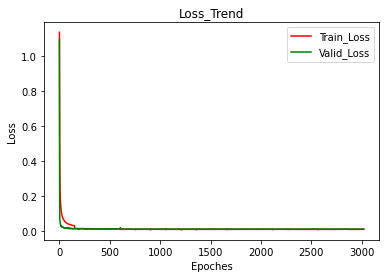

In [7]:
from time import time
TRAN_TAG = True
if TRAN_TAG:
    if path.exists("model/trajectory_predict_1202_43_4_30_new.pt"):
        Prednet.load_state_dict(torch.load('model/trajectory_predict_1202_43_4_30_new.pt'))
    Prednet = Prednet.double()
    Prednet = Prednet.to(device)
    start = time()
    trainIters(Prednet, 20,0.001,20)
    print('Training time is:',time()-start,'s')

In [8]:
def calcu_XY(predY):
    #input: [batchsize len features]; features:[velx,vely,x,y]
    '''
    deltaY = v0*delta_t + 0.5* a *delta_t^2
    a = (v - v0)/delta_t
    vo
    '''
    vels = predY[:,:,0:2]
    rst_xy = np.zeros(predY[:,:,0:2].shape)
    rst_xy[:,:-predict_length,:] = predY[:,:-predict_length,2:4]
    delta_t = 0.1
    
    for i in range(predict_length):
        a = (vels[:,-(predict_length-i),:] - vels[:,-(predict_length+1-i),:])/delta_t
        delta_xy = vels[:,-(predict_length-i),:]*vels[:,-(predict_length-i),:]-vels[:,-(predict_length+1-i),:]*vels[:,-(predict_length+1-i),:]
        delta_xy = delta_xy/(2*a)
        rst_xy[:,-(predict_length-i),:] = rst_xy[:,-(predict_length+1-i),:] + delta_xy
    return rst_xy

In [9]:
def calcu_ADE_FDE(predict_trajectory,actual_predict):
    dis = predict_trajectory - actual_predict
    dis = np.sqrt(np.power(dis[:, 0], 2) + np.power(dis[:, 1], 2))
    ADE = np.mean(dis)
    FDE = dis[-1]
    return ADE,FDE

In [10]:
def Eval_net(encoder,optmizer=False):
    n_trajectory_batch = 0
    loss = []
    MSE_pres, MSE_rsts,ADEs_rst,FDEs_rst,ADEs_pre,FDEs_pre = [],[],[],[],[],[]
    encoder.eval()
    for local_batch, local_labels in Valid:
        n_trajectory_batch = n_trajectory_batch + 1
        criterion = nn.MSELoss()
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)
        predY = encoder(local_batch)
        #print(WholeSet.std.repeat(BatchSize,100,1).shape)
        test_loss = criterion(predY,local_labels)
        loss.append(test_loss.item())
        std = WholeSet.std.repeat(local_batch.shape[0],x.shape[1],1)
        std = std[:,:,:4].to(device)
        mn = WholeSet.mn.repeat(local_batch.shape[0],x.shape[1],1)
        mn = mn[:,:,:4].to(device)
        rg = WholeSet.range.repeat(local_batch.shape[0],x.shape[1],1)
        rg = rg[:,:,:4].to(device)
        predY = (predY*(rg*std)+mn).detach().cpu()
        pY = np.array(predY )
        local_labels = (local_labels*(rg*std)+mn).detach().cpu()
        Y = np.array(local_labels)
#         std = WholeSet.std.repeat(local_batch.shape[0],x.shape[1],1)
#         std = std[:,:,:44].to(device)
#         mn = WholeSet.mn.repeat(local_batch.shape[0],x.shape[1],1)
#         mn = mn[:,:,:44].to(device)
#         rg = WholeSet.range.repeat(local_batch.shape[0],x.shape[1],1)
#         rg = rg[:,:,:44].to(device)
#         B = (local_batch*(rg*std)+mn).detach().cpu()
#         B = np.array(B)
        pY[:,:-predict_length,:] = Y[:,:-predict_length,:]  
        rst_xy = calcu_XY(pY)                                                  
      #  if n_trajectory_batch > 200:
          #  break
        for i in range(1):
            pY[i,-predict_length-1:,2:4] = scipy.signal.savgol_filter(pY[i,-predict_length-1:,2:4],
            window_length=21,polyorder=3,axis=0)#The direct prediction trajectory is processed by sg filtering.
            real_predict = torch.from_numpy(Y[i,-predict_length-1:,2:4])
            rst_predict = torch.from_numpy(rst_xy[i,-predict_length-1:,:2])
            pre_predict = torch.from_numpy(pY[i,-predict_length-1:,2:4])
            ADE,FDE = calcu_ADE_FDE(rst_xy[i,-predict_length-1:,:2],Y[i,-predict_length-1:,2:4])
            ADE_pre,FDE_pre = calcu_ADE_FDE(pY[i,-predict_length-1:,2:4],Y[i,-predict_length-1:,2:4])
            MSE_pre = criterion(real_predict,pre_predict)
            MSE_rst = criterion(real_predict,rst_predict)
            print("MSE pre:",MSE_pre.item())
            print("MSE RST:",MSE_rst.item())
            print("ADE_rst:",ADE)
            print("FDE_rst:",FDE)
            print("ADE_pre:",ADE_pre)
            print("FDE_pre:",FDE_pre)
            MSE_pres.append(MSE_pre.item())
            MSE_rsts.append(MSE_rst.item())
            ADEs_rst.append(ADE)
            FDEs_rst.append(FDE)
            ADEs_pre.append(ADE_pre)
            FDEs_pre.append(FDE_pre)
            #plt.ylim(-45000, -41000)
            #plt.xlim(-23000,-20000)
            #plt.axis([-23000,-20000, -45000, -41000])
            plt.plot(Y[i,:-predict_length,2],Y[i,:-predict_length,3],'r',label = 'history trajectory')
            if optmizer:
                 plt.plot(rst_xy[i,-predict_length-1:,0],rst_xy[i,-predict_length-1:,1],'b',label=" prediction trajectory via optimizing")
           # plt.plot(pY[i,-predict_length-1:,2],pY[i,-predict_length-1:,3],'k',label='prediction trajectory')
            plt.plot(Y[i,-predict_length-1:,2],Y[i,-predict_length-1:,3],'g',label='Real trajectory')
            plt.axis('equal')
            plt.title('Trajectory prediction')
            plt.xlabel('X ')
            plt.ylabel('Y ')
            plt.legend()
            if optmizer:
                plt.savefig("image/trajectory_output_optimization/trajectory_{}.svg".format(n_trajectory_batch),dpi=600)
            else:
                plt.savefig("image/trajectory_output/trajectory_{}.svg".format(n_trajectory_batch),dpi=600)
        plt.show()
#         print(pY[0,-predict_length-1:,3])
#         print(Y[0,-predict_length-1:,3])
#         print(B[0,-predict_length-1:,3])
        print('Test loss:',test_loss.item())
    print('average MSE_pre:',np.mean(MSE_pres))
    print('average MSE_rst:',np.mean(MSE_rsts))
    print('average ADE_rst:',np.mean(ADEs_rst))
    print('average FDE_rst:',np.mean(FDEs_rst))
    print('average ADE_pre:',np.mean(ADEs_pre))
    print('average FDE_pre:',np.mean(FDEs_pre))
    print('average loss:',np.mean(loss))

In [2]:
import numpy as np
a = np.array([1,3,4,4])
b = a[:-3]
print(b)

[1]


MSE pre: 4.5540670527306135
MSE RST: 0.18176806265835774
ADE_rst: 0.5293812551195368
FDE_rst: 1.0934965649048112
ADE_pre: 2.634172788285509
FDE_pre: 5.727553198030385


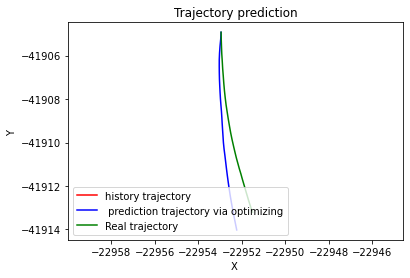

Test loss: 0.008281703449093144
MSE pre: 14.767469346050746
MSE RST: 1.8806414687359256
ADE_rst: 1.3754244110231408
FDE_rst: 4.311588600173563
ADE_pre: 4.962138078690052
FDE_pre: 4.163046064971289


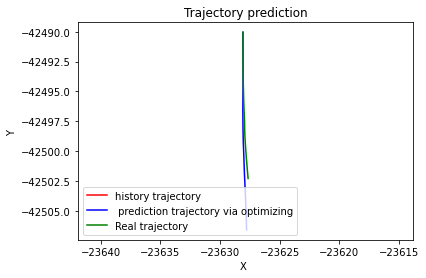

Test loss: 0.008621961506581515
MSE pre: 14.670308102581826
MSE RST: 16.15289926312882
ADE_rst: 4.636898674738938
FDE_rst: 10.704352826267034
ADE_pre: 4.592692365787276
FDE_pre: 12.938045421842176


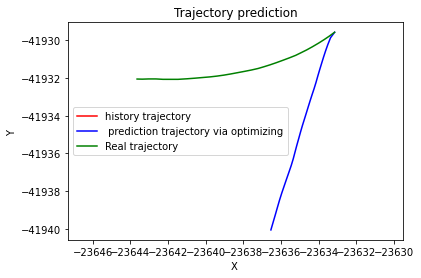

Test loss: 0.009067423154698835
MSE pre: 15.90923234353082
MSE RST: 3.9169026542369116
ADE_rst: 2.161356066323477
FDE_rst: 5.85485383713934
ADE_pre: 5.102540311864945
FDE_pre: 12.707926940375561


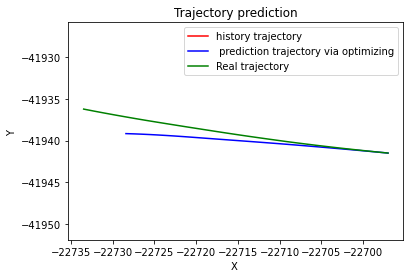

Test loss: 0.010294594083367185
MSE pre: 13.651608825371573
MSE RST: 0.4482431631759782
ADE_rst: 0.6982505072593034
FDE_rst: 1.902190346979672
ADE_pre: 4.836917568575046
FDE_pre: 6.094637102723577


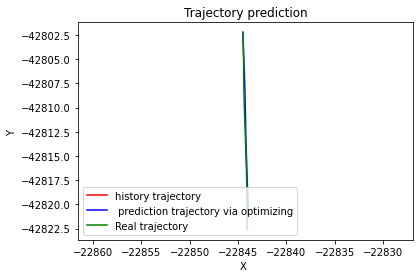

Test loss: 0.009465821536535614
MSE pre: 42.462512347316164
MSE RST: 0.2527947302274964
ADE_rst: 0.631335749111391
FDE_rst: 1.228029847061964
ADE_pre: 8.948664928177095
FDE_pre: 11.9267933510253


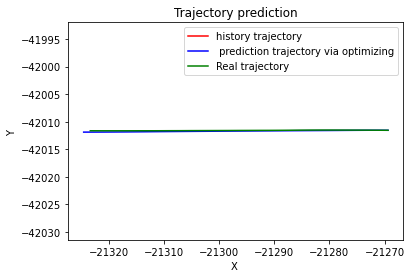

Test loss: 0.008612387196869029
MSE pre: 34.12078554995596
MSE RST: 2.2380678260473905
ADE_rst: 1.7242391741900407
FDE_rst: 3.8439650212061136
ADE_pre: 7.352176999057002
FDE_pre: 5.268621173843542


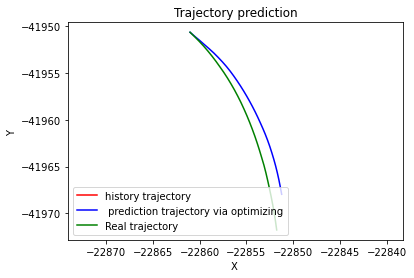

Test loss: 0.01053551782100557
MSE pre: 2.2896347327787456
MSE RST: 0.12072386317606434
ADE_rst: 0.35256733084662434
FDE_rst: 1.1337615997461636
ADE_pre: 1.8311647849200963
FDE_pre: 5.851779774017624


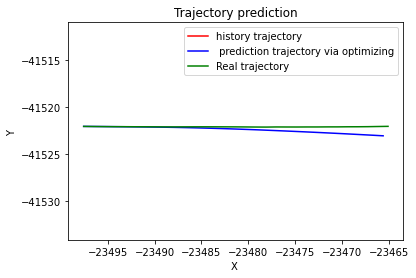

Test loss: 0.01088457683188929
MSE pre: 7.100108596721207
MSE RST: 3.164193720805513
ADE_rst: 2.173424890665552
FDE_rst: 4.438432969425735
ADE_pre: 3.3727162318526194
FDE_pre: 3.494411075341822


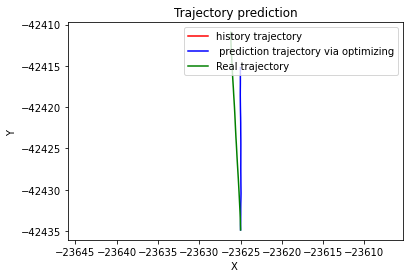

Test loss: 0.010928435434865904
MSE pre: 57.48328038975441
MSE RST: 0.18651780323046158
ADE_rst: 0.5006846115785545
FDE_rst: 1.3881455491073416
ADE_pre: 9.832945177779086
FDE_pre: 3.503430535497453


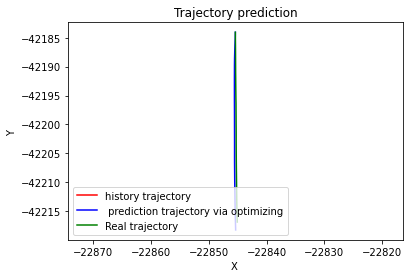

Test loss: 0.00845062410014299
MSE pre: 7.716047829745221
MSE RST: 1.0660478075273832
ADE_rst: 1.250551703981942
FDE_rst: 2.4070461728161514
ADE_pre: 3.358614526187022
FDE_pre: 2.0536962929165896


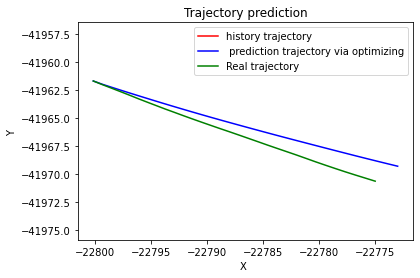

Test loss: 0.010118000663219714
MSE pre: 33.49996733175837
MSE RST: 1.653514235375733
ADE_rst: 1.585969536853906
FDE_rst: 3.0363568213289214
ADE_pre: 7.493661223064771
FDE_pre: 10.069954466380356


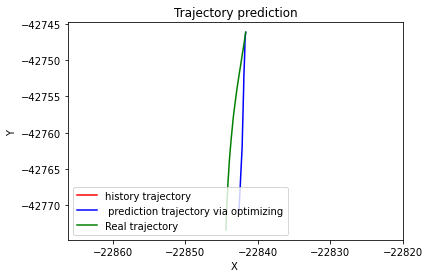

Test loss: 0.01144688056770756
MSE pre: 7.811986765130607
MSE RST: 1.9482662894582807
ADE_rst: 1.669123974425654
FDE_rst: 3.402940563025847
ADE_pre: 3.670519291890254
FDE_pre: 4.59571606093896


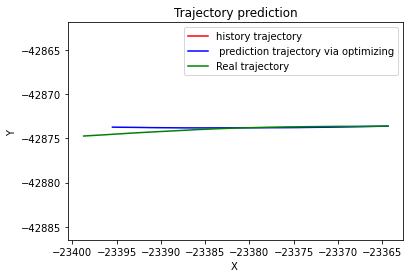

Test loss: 0.008282350679839727
MSE pre: 37.32231285325277
MSE RST: 1.3451671122608104
ADE_rst: 1.359709536771291
FDE_rst: 2.771890397706793
ADE_pre: 8.296558939995442
FDE_pre: 3.859845942531493


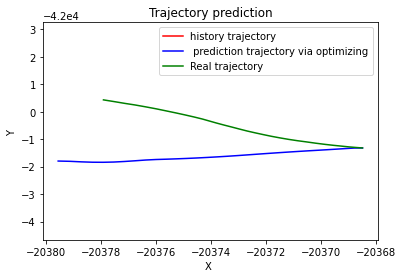

Test loss: 0.010762640508923286
MSE pre: 16.628144817582815
MSE RST: 2.0918787398911274
ADE_rst: 1.6001830173452118
FDE_rst: 4.357455189533488
ADE_pre: 5.633424446483335
FDE_pre: 4.637473518995305


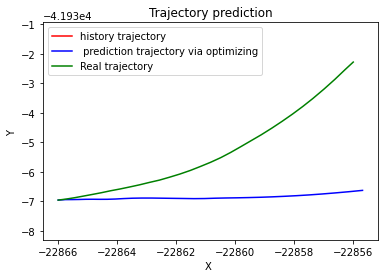

Test loss: 0.00886328821322846
MSE pre: 9.21254705212442
MSE RST: 0.0803888501252232
ADE_rst: 0.3373870281706398
FDE_rst: 0.9734733015146065
ADE_pre: 4.0099484286754
FDE_pre: 5.493499613711936


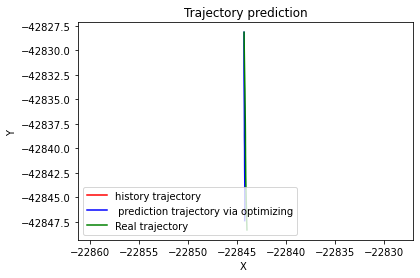

Test loss: 0.010597874417474366
MSE pre: 0.9813011530496046
MSE RST: 2.7976687770751614
ADE_rst: 1.9243349123822575
FDE_rst: 4.647122899160057
ADE_pre: 1.3100858471917058
FDE_pre: 1.0499616069499418


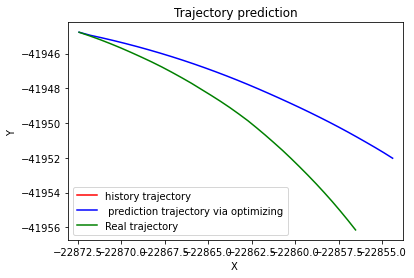

Test loss: 0.011851163298807267
MSE pre: 9.05370214359524
MSE RST: 1.228241725729183
ADE_rst: 1.4373302543068847
FDE_rst: 2.5757584515940852
ADE_pre: 4.026203032595548
FDE_pre: 9.001514122820245


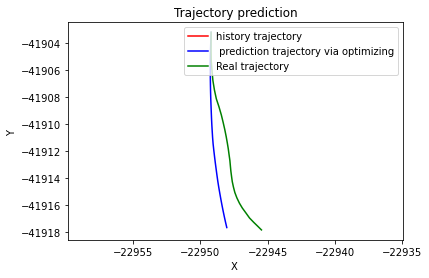

Test loss: 0.01327321117171422
MSE pre: 34.71312575862729
MSE RST: 0.6491303730023691
ADE_rst: 0.8272659464257276
FDE_rst: 2.318714869582334
ADE_pre: 8.170126920734106
FDE_pre: 6.387848330014414


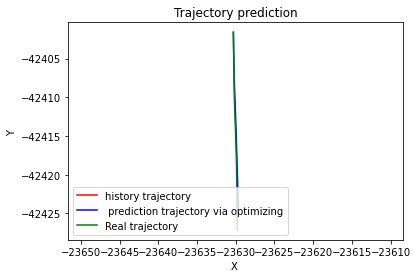

Test loss: 0.00825554882528863
MSE pre: 24.943605897908984
MSE RST: 10.726220219938718
ADE_rst: 3.884682593482111
FDE_rst: 8.459109771903668
ADE_pre: 6.93592740815372
FDE_pre: 8.67789865058939


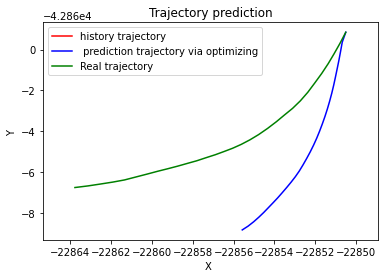

Test loss: 0.010275734333111148
MSE pre: 7.4068904315877555
MSE RST: 0.6760546834328169
ADE_rst: 0.8518552914848022
FDE_rst: 2.415664296996636
ADE_pre: 3.6281427313551133
FDE_pre: 1.9949117246704615


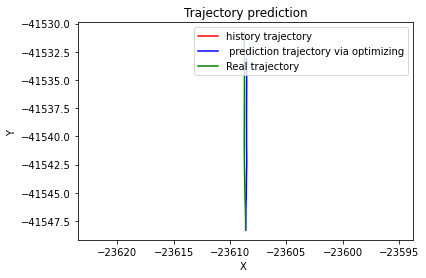

Test loss: 0.01051366851666599
MSE pre: 16.29744202662303
MSE RST: 6.572900289613149
ADE_rst: 3.260702061452914
FDE_rst: 2.955030391708877
ADE_pre: 5.109277012215151
FDE_pre: 1.385239028473624


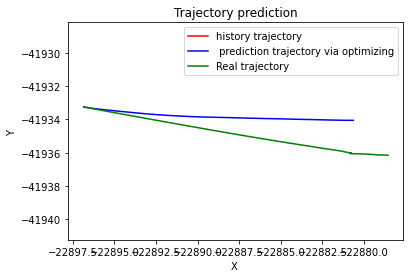

Test loss: 0.011135404045863535
MSE pre: 16.902937632964274
MSE RST: 0.3169838366237866
ADE_rst: 0.6166065292809104
FDE_rst: 1.5948709664563994
ADE_pre: 5.210345326573958
FDE_pre: 3.405146501993022


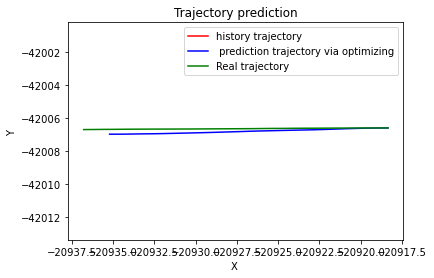

Test loss: 0.010422463034571595
MSE pre: 18.856351138154
MSE RST: 0.5200652977474534
ADE_rst: 0.9012545473656207
FDE_rst: 2.143456575432958
ADE_pre: 5.7726056109496255
FDE_pre: 3.050378909731508


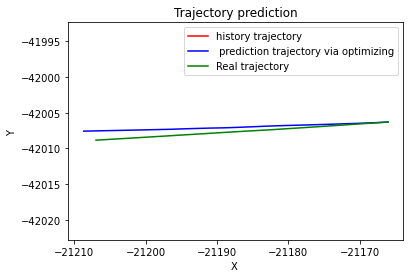

Test loss: 0.00999842048403247
MSE pre: 12.30615475033758
MSE RST: 1.1912866168326601
ADE_rst: 1.215553176354642
FDE_rst: 2.6845367024937348
ADE_pre: 4.4697967481609195
FDE_pre: 3.878132009731341


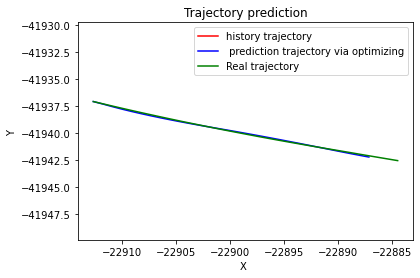

Test loss: 0.008390020038083972
MSE pre: 3.0520553799797945
MSE RST: 3.2380661999441163
ADE_rst: 2.03615855786925
FDE_rst: 5.025055533470095
ADE_pre: 2.2809383716925136
FDE_pre: 4.3914159143359495


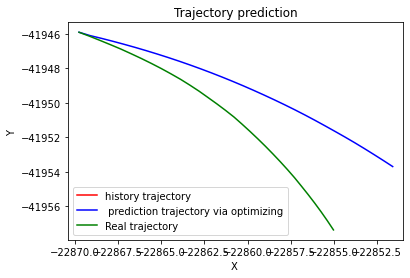

Test loss: 0.009830011614779153
MSE pre: 49.07949855755835
MSE RST: 0.7047174545321289
ADE_rst: 1.0062297875928352
FDE_rst: 2.142379160959592
ADE_pre: 9.335776507943919
FDE_pre: 14.483219762014851


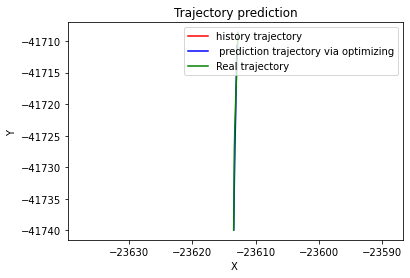

Test loss: 0.007536950415789917
MSE pre: 30.126354705198075
MSE RST: 8.854905979543073
ADE_rst: 3.481677205118315
FDE_rst: 7.757536651452356
ADE_pre: 7.5420548744977145
FDE_pre: 12.21628665605558


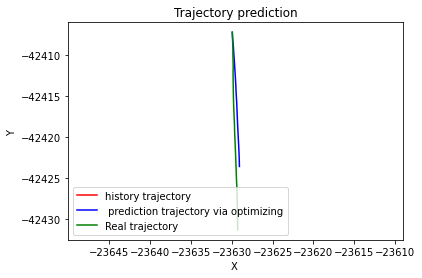

Test loss: 0.015677963604344175
MSE pre: 2.734593336920282
MSE RST: 0.31103201258507285
ADE_rst: 0.6717290351595075
FDE_rst: 1.0538832777809417
ADE_pre: 2.1835481709551576
FDE_pre: 2.9342599841035018


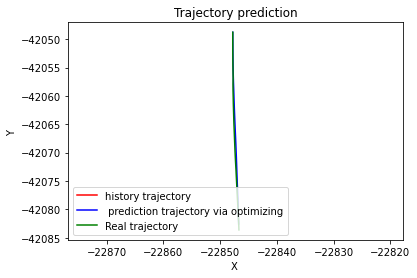

Test loss: 0.008696633840557052
MSE pre: 26.965480119829223
MSE RST: 1.8919246681264956
ADE_rst: 1.7303560967753897
FDE_rst: 3.0960655784377766
ADE_pre: 7.0918868693170225
FDE_pre: 6.199722256557616


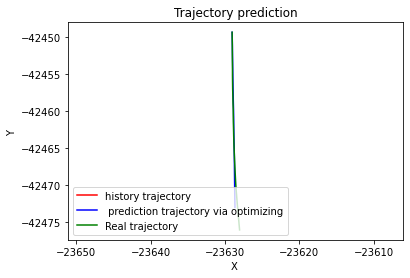

Test loss: 0.009696707592364661
MSE pre: 4.06394142433036
MSE RST: 2.074240482285557
ADE_rst: 1.6455666723081424
FDE_rst: 3.952513292237386
ADE_pre: 2.6652252643938628
FDE_pre: 3.2843036269602357


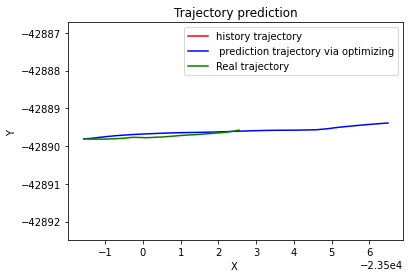

Test loss: 0.008416212152875725
MSE pre: 7.1781578198709255
MSE RST: 0.32022681424827276
ADE_rst: 0.6865870051920074
FDE_rst: 1.3469844574979266
ADE_pre: 3.327249790421272
FDE_pre: 2.228533206156109


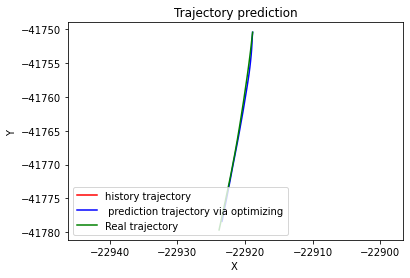

Test loss: 0.009305191658099043
MSE pre: 25.540261546989996
MSE RST: 0.3008718629964148
ADE_rst: 0.5555655084716179
FDE_rst: 1.8747989049217029
ADE_pre: 6.4326533990908885
FDE_pre: 16.415063789964808


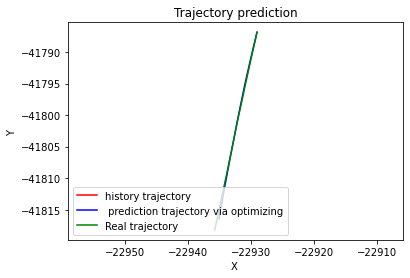

Test loss: 0.009398128499040832
MSE pre: 5.960697169556055
MSE RST: 3.0029789166012217
ADE_rst: 2.013083260405215
FDE_rst: 4.57487573711306
ADE_pre: 3.141731014323075
FDE_pre: 2.7033398488642395


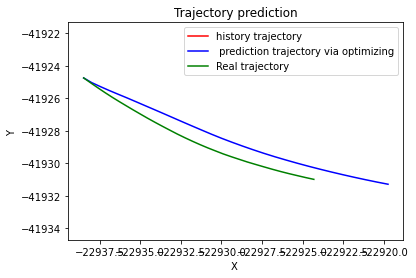

Test loss: 0.01332919731915032
MSE pre: 37.27423860289351
MSE RST: 0.20347775309687713
ADE_rst: 0.536319841510857
FDE_rst: 1.0702949967712854
ADE_pre: 7.916295323337938
FDE_pre: 4.714582066228564


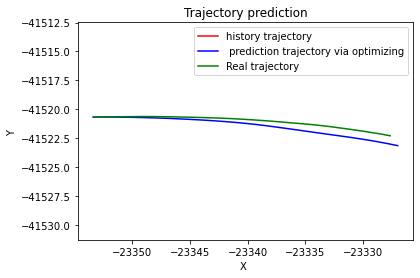

Test loss: 0.009084427517872352
MSE pre: 14.298062715979096
MSE RST: 1.251414332446596
ADE_rst: 1.3149482590990207
FDE_rst: 2.862151966566205
ADE_pre: 4.8939621391136345
FDE_pre: 1.3740935035738793


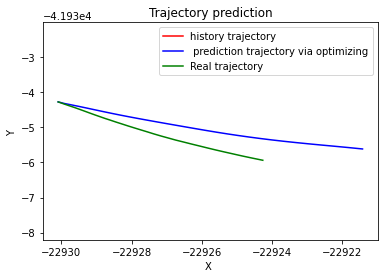

Test loss: 0.01068527621257489
MSE pre: 3.4149701058260478
MSE RST: 0.41017498008984654
ADE_rst: 0.7117261477312509
FDE_rst: 1.6657773338519137
ADE_pre: 2.2888783612178774
FDE_pre: 2.3674806774318524


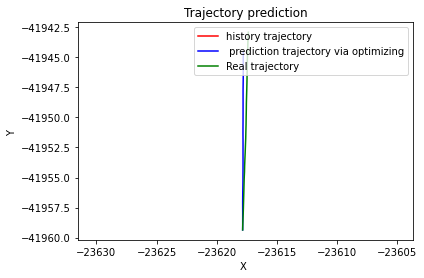

Test loss: 0.011781321720885283
MSE pre: 4.233933641321529
MSE RST: 1.841064880990993
ADE_rst: 1.455591537455754
FDE_rst: 4.338423274902412
ADE_pre: 2.2675793536032627
FDE_pre: 4.97514773939368


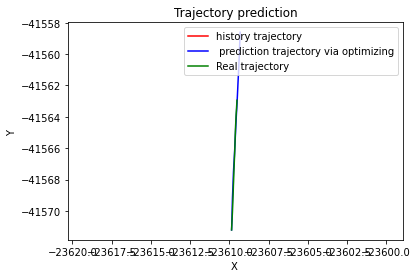

Test loss: 0.010170661774426442
MSE pre: 13.012245639122746
MSE RST: 1.8762959626404316
ADE_rst: 1.5266302942381684
FDE_rst: 3.7659111518988606
ADE_pre: 4.617819502425685
FDE_pre: 10.695010473892182


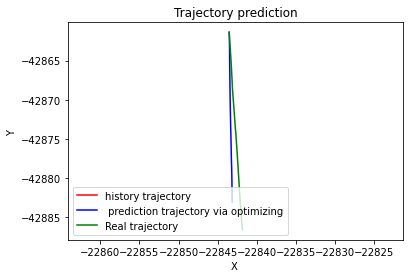

Test loss: 0.008670036622842782
MSE pre: 40.13806440824102
MSE RST: 0.8666235669308459
ADE_rst: 1.1118104076864168
FDE_rst: 2.2952157493883902
ADE_pre: 8.637793667738132
FDE_pre: 7.655647046995681


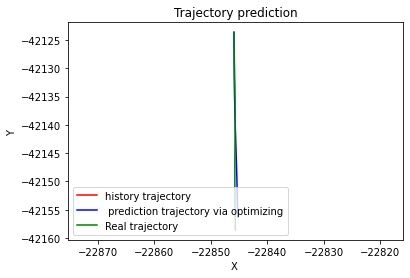

Test loss: 0.00880151819037513
MSE pre: 24.905775128602837
MSE RST: 2.4693075720609907
ADE_rst: 1.8220686691610155
FDE_rst: 3.910122024928099
ADE_pre: 6.517667628459739
FDE_pre: 2.329162343221085


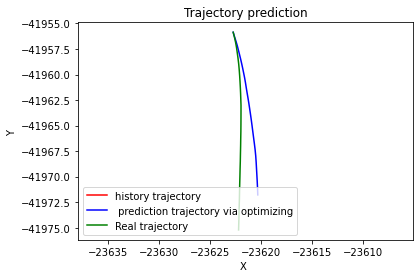

Test loss: 0.009679691537143813
MSE pre: 14.956616729536469
MSE RST: 0.019928559330340923
ADE_rst: 0.1796182275831436
FDE_rst: 0.4228337726112158
ADE_pre: 4.850667132541412
FDE_pre: 3.2193435653315667


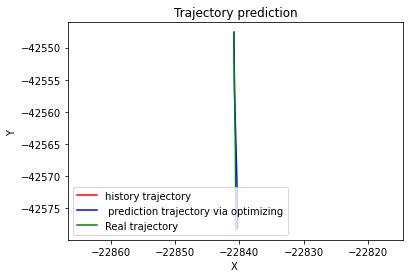

Test loss: 0.007422569787411184
MSE pre: 3.767561211811193
MSE RST: 1.1176807222353529
ADE_rst: 1.175089811771393
FDE_rst: 3.0922780888332184
ADE_pre: 2.154657078088996
FDE_pre: 8.684986209842116


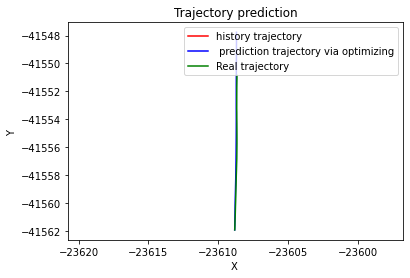

Test loss: 0.011181172436752143
MSE pre: 32.87396949721706
MSE RST: 0.6610468220066121
ADE_rst: 0.959180241916103
FDE_rst: 2.213197343020532
ADE_pre: 7.220404037216572
FDE_pre: 6.865200216801841


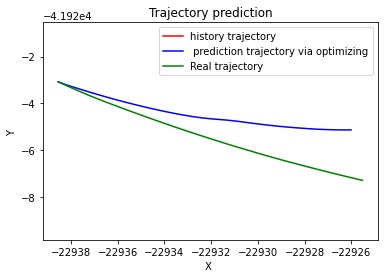

Test loss: 0.007495757662944995
MSE pre: 37.785868817710224
MSE RST: 2.9345513760764685
ADE_rst: 1.936803792389669
FDE_rst: 4.6631932253918436
ADE_pre: 7.125218058456147
FDE_pre: 20.169991869021192


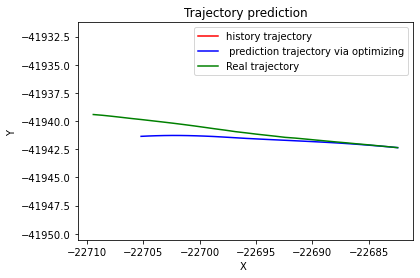

Test loss: 0.007865091228265897
MSE pre: 18.967802217268083
MSE RST: 1.7954509696695837
ADE_rst: 1.5895794484183206
FDE_rst: 3.3451108756447683
ADE_pre: 5.412656203492125
FDE_pre: 3.3979898941681745


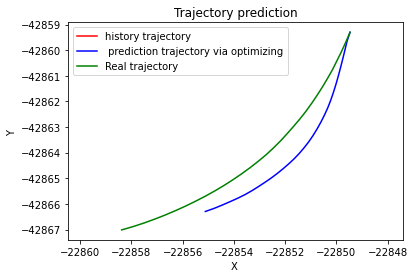

Test loss: 0.009567971687850107
MSE pre: 38.62762050494423
MSE RST: 0.03349502125226308
ADE_rst: 0.22542869738505542
FDE_rst: 0.39716329025326663
ADE_pre: 8.45932240610805
FDE_pre: 9.585856846692662


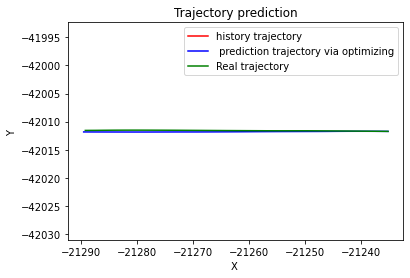

Test loss: 0.009957929814825066
MSE pre: 8.64249573652675
MSE RST: 0.020678424320522727
ADE_rst: 0.1702981275106416
FDE_rst: 0.43633237958011184
ADE_pre: 3.6500883650921008
FDE_pre: 2.3791018580176613


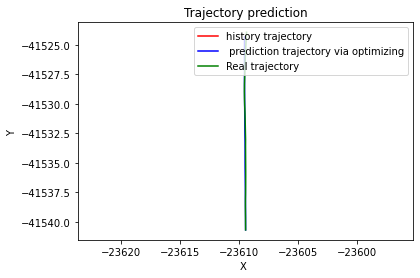

Test loss: 0.010202556452739446
MSE pre: 40.54587630308304
MSE RST: 0.20710033303734832
ADE_rst: 0.5413206095558841
FDE_rst: 1.073820801867235
ADE_pre: 8.75759873842521
FDE_pre: 4.202566388776705


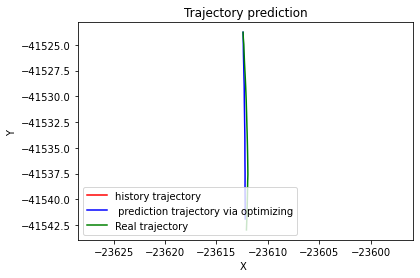

Test loss: 0.01290300677828501
MSE pre: 3.4432017167676694
MSE RST: 2.198884359752229
ADE_rst: 1.582728802244708
FDE_rst: 4.437535736333577
ADE_pre: 2.2574615552739057
FDE_pre: 1.776193820090345


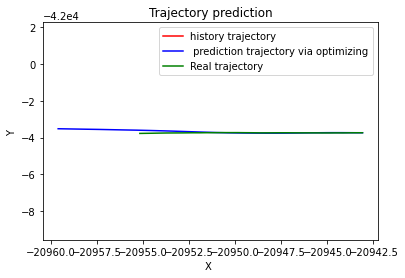

Test loss: 0.009708958401049855
MSE pre: 22.66472028973464
MSE RST: 1.9439347684909944
ADE_rst: 1.7020785312290845
FDE_rst: 3.5903902218925583
ADE_pre: 6.19115106554773
FDE_pre: 2.7903812185109533


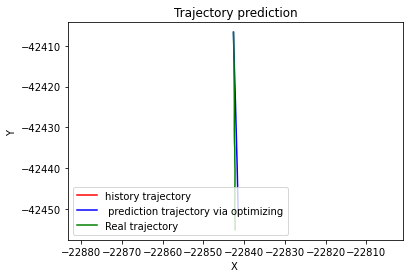

Test loss: 0.010412700911506183
MSE pre: 17.77839784422642
MSE RST: 3.0417139388917005
ADE_rst: 1.9842930356300477
FDE_rst: 4.888326428203466
ADE_pre: 4.89680492945907
FDE_pre: 16.543223278932302


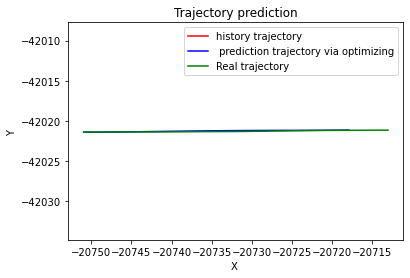

Test loss: 0.010500019915234927
MSE pre: 114.305662628907
MSE RST: 0.5765830980914094
ADE_rst: 0.9537248910944568
FDE_rst: 1.8910066976063513
ADE_pre: 14.886386205037248
FDE_pre: 8.15965374108433


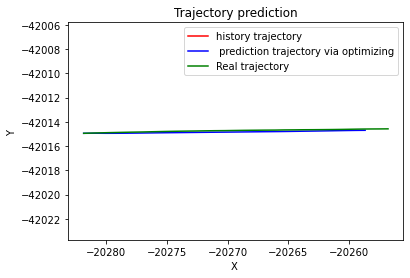

Test loss: 0.00989069998457997
MSE pre: 13.333626169564571
MSE RST: 0.7769065288931593
ADE_rst: 1.1107635976066883
FDE_rst: 1.85401182947999
ADE_pre: 4.893844905056903
FDE_pre: 5.29948751688278


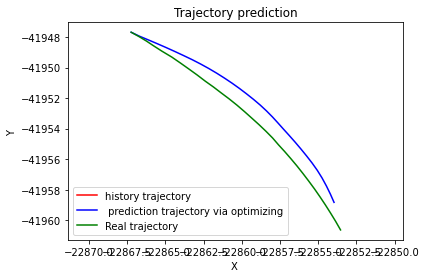

Test loss: 0.008768001458114025
MSE pre: 46.26923405068185
MSE RST: 0.02543603735277483
ADE_rst: 0.21091283207979658
FDE_rst: 0.2336408545732282
ADE_pre: 9.149781664464458
FDE_pre: 7.663667015928247


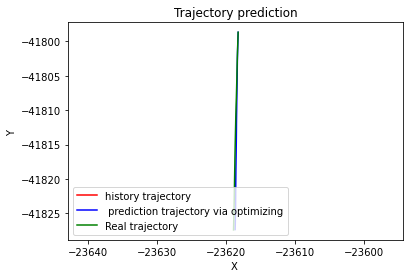

Test loss: 0.010663205169544507
MSE pre: 13.711758066152894
MSE RST: 0.982169952997216
ADE_rst: 1.1970523750963205
FDE_rst: 2.594756780897783
ADE_pre: 4.993824164261392
FDE_pre: 8.841514883819316


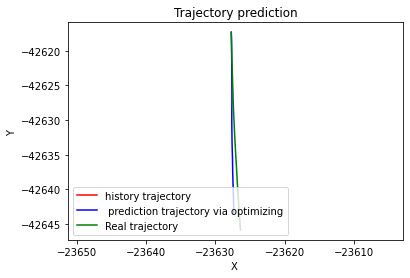

Test loss: 0.008377687525946727
MSE pre: 17.692225490560073
MSE RST: 1.0968644572446538
ADE_rst: 1.2494341060812237
FDE_rst: 2.1087738406314167
ADE_pre: 5.446848532896741
FDE_pre: 7.016244108472291


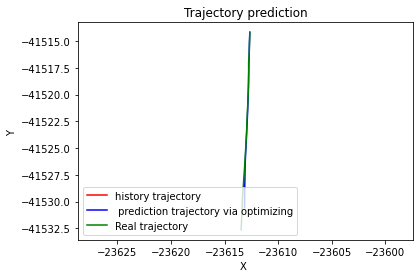

Test loss: 0.010396255379539457
MSE pre: 7.947369906856516
MSE RST: 4.861902781769371
ADE_rst: 2.51172677743897
FDE_rst: 3.9350770113087035
ADE_pre: 3.6100491665304606
FDE_pre: 6.73351179109808


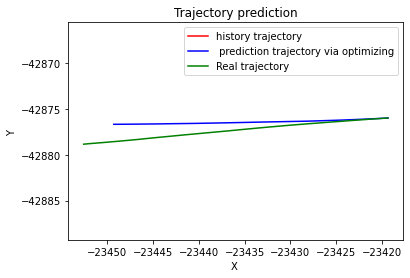

Test loss: 0.007936240886561053
MSE pre: 25.902105608304716
MSE RST: 1.2340761819959103
ADE_rst: 1.3406268592850816
FDE_rst: 2.5598499370960797
ADE_pre: 6.692480614941042
FDE_pre: 3.67183006032503


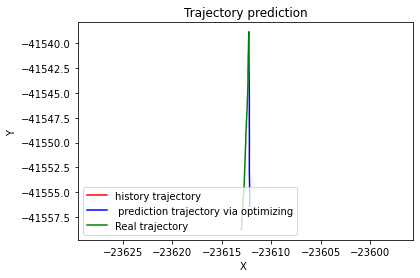

Test loss: 0.016103656391768775
MSE pre: 10.781673598988789
MSE RST: 1.045556216246319
ADE_rst: 1.1874430480599993
FDE_rst: 2.717733111122165
ADE_pre: 3.7842461608152598
FDE_pre: 9.923455946058828


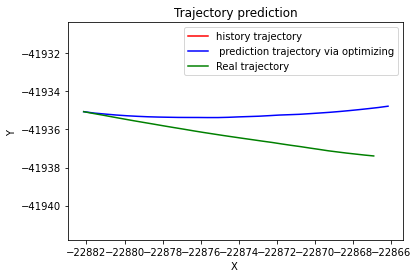

Test loss: 0.00831975005742241
MSE pre: 5.896115838986954
MSE RST: 0.0978624892300876
ADE_rst: 0.41502578002213314
FDE_rst: 0.5480279782521298
ADE_pre: 3.27601069465865
FDE_pre: 3.993809666635553


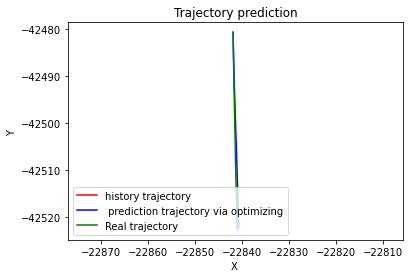

Test loss: 0.009340684460088266
MSE pre: 5.897214703782092
MSE RST: 4.358559168389
ADE_rst: 2.4227188194287637
FDE_rst: 5.487437524371912
ADE_pre: 2.8978606693847357
FDE_pre: 2.608731186414526


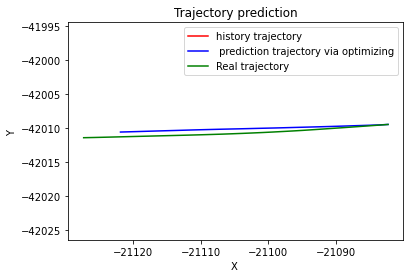

Test loss: 0.010258440051471404
MSE pre: 5.0148257688581195
MSE RST: 3.6591208262378396
ADE_rst: 2.330668286708724
FDE_rst: 4.4560895016673685
ADE_pre: 2.3280124085768703
FDE_pre: 8.415108724483671


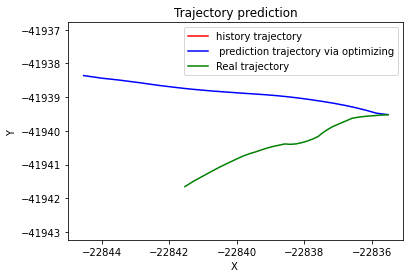

Test loss: 0.008761398172971892
MSE pre: 19.082060200808368
MSE RST: 0.5337306203356061
ADE_rst: 0.6778467460186993
FDE_rst: 2.776884264677462
ADE_pre: 6.041973732916329
FDE_pre: 4.6907859744291995


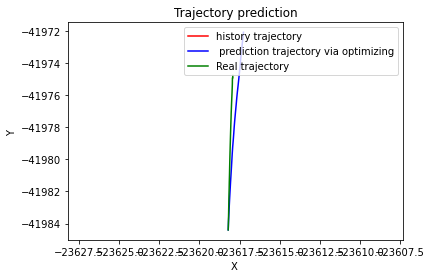

Test loss: 0.011362826478224631
MSE pre: 24.853272494424765
MSE RST: 0.42797109584165915
ADE_rst: 0.788091849132287
FDE_rst: 1.6421391005620283
ADE_pre: 6.535224095279729
FDE_pre: 1.474466071935014


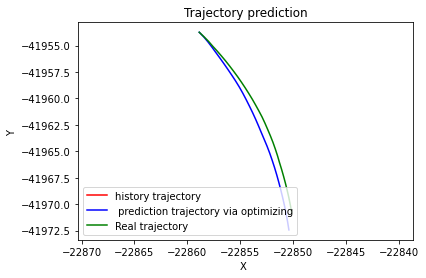

Test loss: 0.00913980002107375
MSE pre: 19.19486054262985
MSE RST: 0.7177634879969657
ADE_rst: 1.0193894144743287
FDE_rst: 1.8770336356023698
ADE_pre: 5.39635152324263
FDE_pre: 10.44334744077935


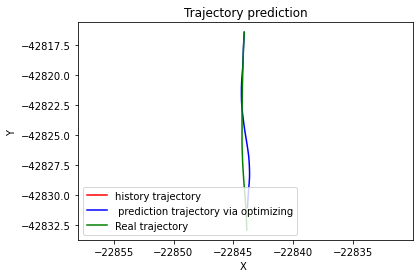

Test loss: 0.020605436786761418
MSE pre: 5.322254211525783
MSE RST: 0.05962692731272541
ADE_rst: 0.28147319383908165
FDE_rst: 0.7913911785774091
ADE_pre: 2.889285615893805
FDE_pre: 6.964500011104509


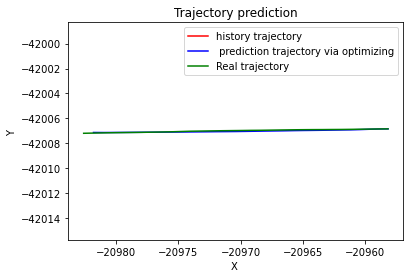

Test loss: 0.008961202469548239
MSE pre: 19.635139201109688
MSE RST: 3.236912299532974
ADE_rst: 2.052324303577684
FDE_rst: 4.994931337474544
ADE_pre: 6.161034921922513
FDE_pre: 4.704390581545111


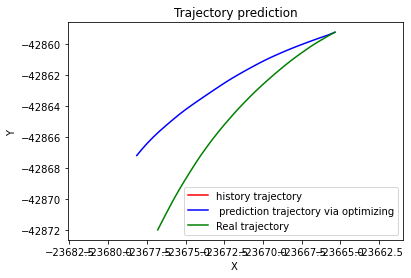

Test loss: 0.009067088270940002
MSE pre: 9.028902083482064
MSE RST: 1.7082908973382755
ADE_rst: 1.5270520935602618
FDE_rst: 3.616522441572867
ADE_pre: 4.167151833734382
FDE_pre: 5.150896345489697


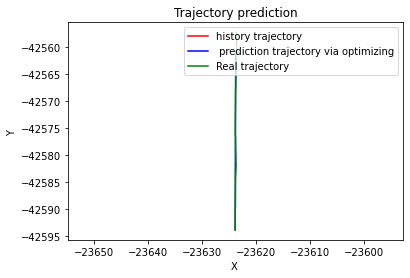

Test loss: 0.009510844992670965
MSE pre: 12.972593992295993
MSE RST: 1.29014345055648
ADE_rst: 1.3502143546343635
FDE_rst: 2.9400574902412266
ADE_pre: 4.791314948178467
FDE_pre: 11.366811765677841


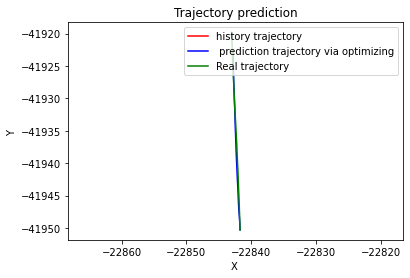

Test loss: 0.008651440780884059
MSE pre: 18.055665899325987
MSE RST: 0.3802036789363283
ADE_rst: 0.74226401824204
FDE_rst: 1.6964992855300596
ADE_pre: 5.715291472455078
FDE_pre: 7.172707712397637


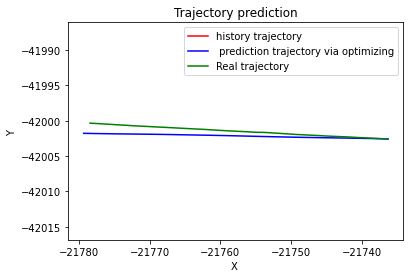

Test loss: 0.009349869407917448
MSE pre: 5.181158380771299
MSE RST: 0.14218367454235428
ADE_rst: 0.4874894072892418
FDE_rst: 0.731268791399711
ADE_pre: 2.907687575415017
FDE_pre: 6.2956660399300715


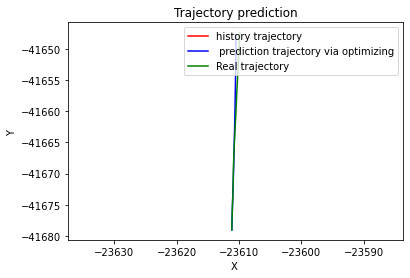

Test loss: 0.009260024020224007
MSE pre: 44.48835525946181
MSE RST: 1.0588546411332296
ADE_rst: 1.2898147553232224
FDE_rst: 2.0168257838405164
ADE_pre: 9.39205559850172
FDE_pre: 12.254557212915978


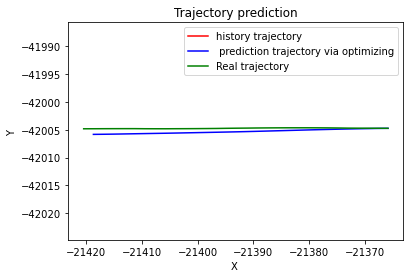

Test loss: 0.008297016332711604
MSE pre: 38.25675619987253
MSE RST: 0.19266647920472876
ADE_rst: 0.5473263385775483
FDE_rst: 0.7764119300999675
ADE_pre: 8.641060093260412
FDE_pre: 7.307971593475809


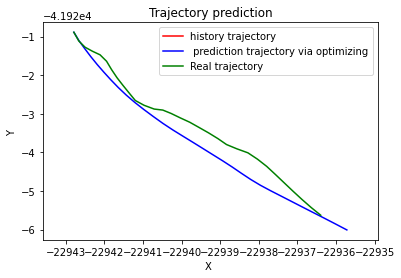

Test loss: 0.015927988066918055
MSE pre: 36.98322405290677
MSE RST: 3.6732818460222347
ADE_rst: 2.3447130973000947
FDE_rst: 4.620629804148712
ADE_pre: 7.88517755142302
FDE_pre: 10.122930110742324


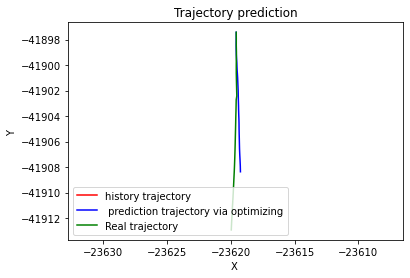

Test loss: 0.00947817027838113
MSE pre: 34.499693552112134
MSE RST: 0.4433070188732589
ADE_rst: 0.673196380221049
FDE_rst: 2.1336165309829473
ADE_pre: 7.45092906100833
FDE_pre: 8.232574189856667


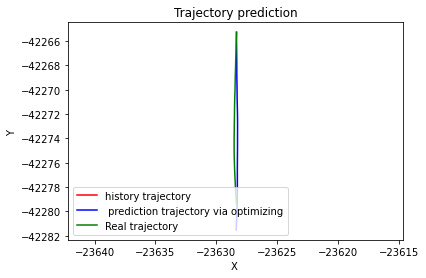

Test loss: 0.01093898719393772
MSE pre: 2.7058500055543635
MSE RST: 0.16877559176151744
ADE_rst: 0.48169329341011574
FDE_rst: 1.182715038125263
ADE_pre: 2.092260562678135
FDE_pre: 6.13334320025145


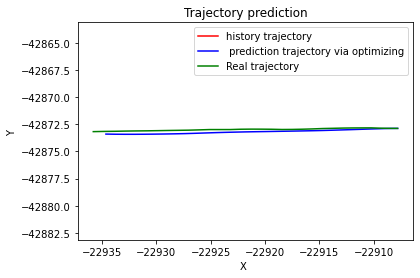

Test loss: 0.01221849135418324
MSE pre: 23.17951982829196
MSE RST: 0.20250819243457316
ADE_rst: 0.5621649014194633
FDE_rst: 0.3843241050535276
ADE_pre: 6.659119002860825
FDE_pre: 8.386031542743313


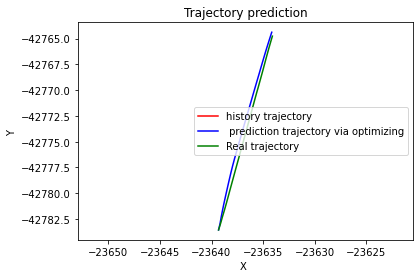

Test loss: 0.010595237113416632
MSE pre: 19.358383619196694
MSE RST: 0.6444931415955154
ADE_rst: 0.894329407672523
FDE_rst: 2.2935568050052924
ADE_pre: 6.037735844869364
FDE_pre: 4.12638110457209


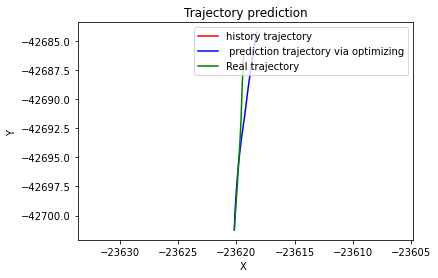

Test loss: 0.0074360546092350635
MSE pre: 50.19533052909863
MSE RST: 0.4069796001738516
ADE_rst: 0.7925772533244138
FDE_rst: 1.3500575551044598
ADE_pre: 9.444881783905439
FDE_pre: 5.667475073720439


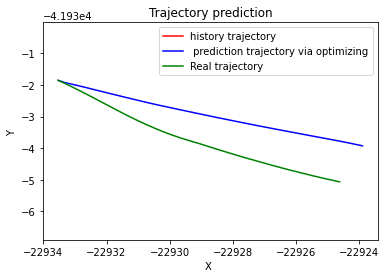

Test loss: 0.010309376877787815
MSE pre: 18.463103787592978
MSE RST: 0.0845651218267895
ADE_rst: 0.30426591295798866
FDE_rst: 0.9031020309171776
ADE_pre: 5.708288477386629
FDE_pre: 12.807542605731571


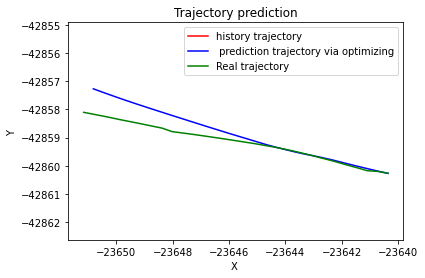

Test loss: 0.009583355553628775
MSE pre: 13.37291333543917
MSE RST: 0.06650277888555645
ADE_rst: 0.337173084268112
FDE_rst: 0.4605837592810945
ADE_pre: 3.7973044698828984
FDE_pre: 3.4647974716597725


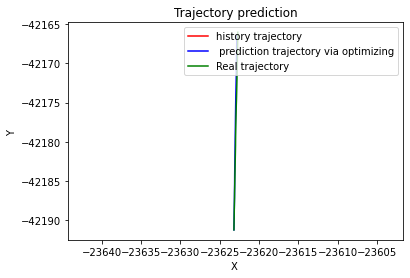

Test loss: 0.015399208927899314
MSE pre: 5.610325593534646
MSE RST: 1.2077424277500384
ADE_rst: 1.2664120475876732
FDE_rst: 2.38711758422899
ADE_pre: 3.1726931429390155
FDE_pre: 0.621368142848293


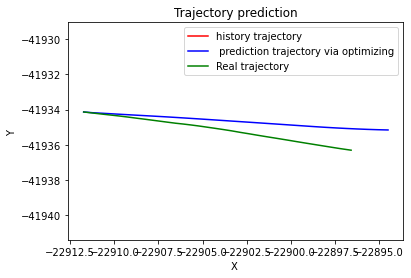

Test loss: 0.014242386179511105
MSE pre: 46.996692060516956
MSE RST: 0.21126475999822264
ADE_rst: 0.516122590866857
FDE_rst: 1.4289884103070887
ADE_pre: 8.706321835986635
FDE_pre: 6.594947981949096


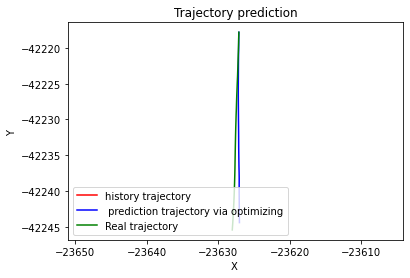

Test loss: 0.010515791209854474
MSE pre: 9.075199794662554
MSE RST: 0.18865561689878654
ADE_rst: 0.49412500853004715
FDE_rst: 1.2742366514834724
ADE_pre: 3.8574769703536127
FDE_pre: 4.928481660023267


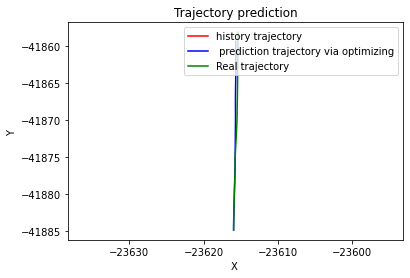

Test loss: 0.0071332682828924255
MSE pre: 7.522109839384822
MSE RST: 1.8432140705111109
ADE_rst: 1.6954825045404969
FDE_rst: 1.311744475091715
ADE_pre: 3.4807052990772145
FDE_pre: 4.529425853327999


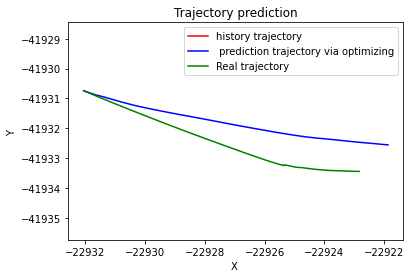

Test loss: 0.010697209637509924
MSE pre: 6.71728314784084
MSE RST: 0.09120986966176549
ADE_rst: 0.39002532624419534
FDE_rst: 0.48523737219285823
ADE_pre: 3.3538495136259128
FDE_pre: 2.222218560984675


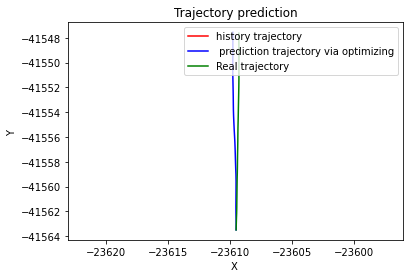

Test loss: 0.008396846781369588
MSE pre: 9.506278513272427
MSE RST: 2.1496494164321605
ADE_rst: 1.619270336530154
FDE_rst: 4.139285887341959
ADE_pre: 3.984836688908108
FDE_pre: 9.16339705380863


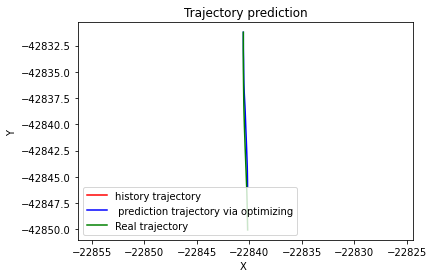

Test loss: 0.008932087735541721
MSE pre: 58.63809565011063
MSE RST: 6.863276274086166
ADE_rst: 3.252390497358263
FDE_rst: 5.442337276918928
ADE_pre: 10.352145741813795
FDE_pre: 9.46056699656233


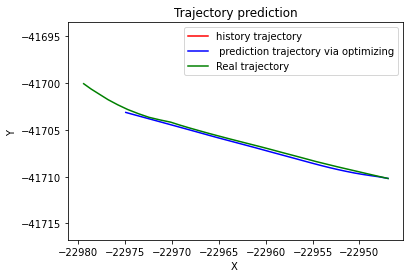

Test loss: 0.010549485341758622
MSE pre: 10.185702508539235
MSE RST: 0.27264230156807
ADE_rst: 0.6623960517209178
FDE_rst: 0.8219658283107052
ADE_pre: 4.130720484360468
FDE_pre: 11.575839891929743


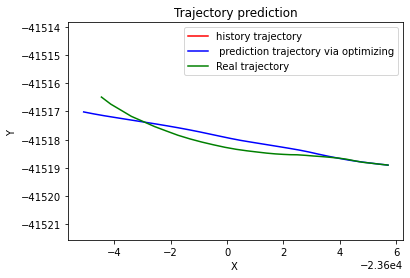

Test loss: 0.009568856885725958
MSE pre: 10.408475233177164
MSE RST: 0.009891008462796483
ADE_rst: 0.12928130835531254
FDE_rst: 0.292009340151457
ADE_pre: 3.422752666479564
FDE_pre: 9.54801767628475


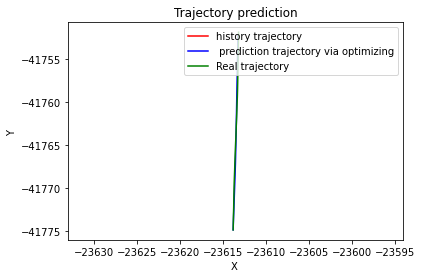

Test loss: 0.015511490934256253
MSE pre: 15.296108680684492
MSE RST: 0.3758413033932397
ADE_rst: 0.8014161432451031
FDE_rst: 0.6364370479905007
ADE_pre: 5.073532599583039
FDE_pre: 8.130211081184276


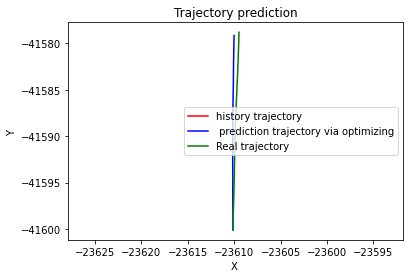

Test loss: 0.008730564868952623
MSE pre: 21.404799388333526
MSE RST: 0.05994857575570399
ADE_rst: 0.3152226250130571
FDE_rst: 0.2631221064585682
ADE_pre: 6.163848663280212
FDE_pre: 9.785643425401403


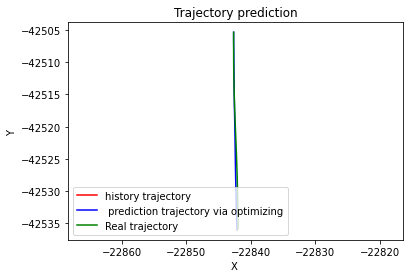

Test loss: 0.009138719197601477
MSE pre: 9.822103044147815
MSE RST: 0.888878102746543
ADE_rst: 1.192676527708123
FDE_rst: 2.2646961761230524
ADE_pre: 4.173609937804735
FDE_pre: 5.3573581541714885


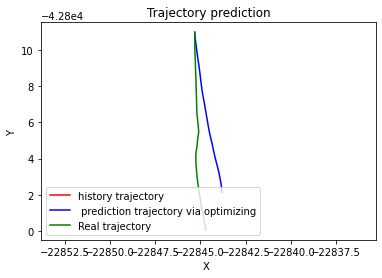

Test loss: 0.010400349819530355
MSE pre: 5.170584425003335
MSE RST: 2.6966445642369283
ADE_rst: 1.8248547728940085
FDE_rst: 4.750777442127652
ADE_pre: 2.5840847162820926
FDE_pre: 5.324634601737426


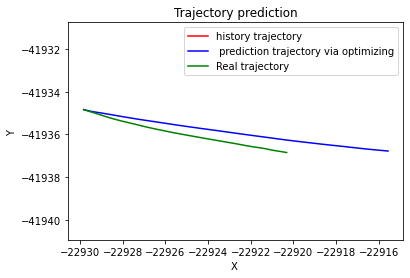

Test loss: 0.008637021455900512
MSE pre: 6.892716219650654
MSE RST: 1.5538045061907497
ADE_rst: 1.4551207244201032
FDE_rst: 3.5637161004110176
ADE_pre: 3.300518137111566
FDE_pre: 9.885865744851344


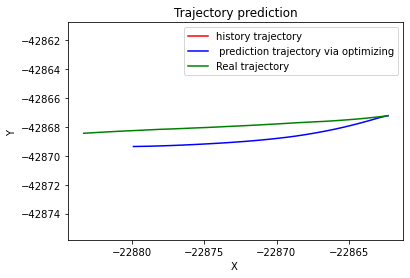

Test loss: 0.009521181518091665
MSE pre: 16.909563099020353
MSE RST: 6.709976721116877
ADE_rst: 2.731853130010598
FDE_rst: 7.786122822160471
ADE_pre: 5.024424154169745
FDE_pre: 3.749164878770944


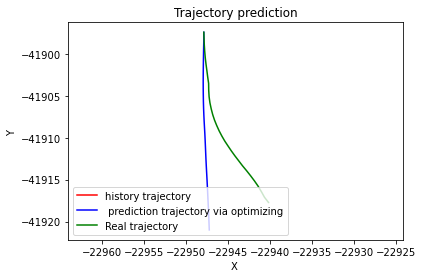

Test loss: 0.009347563404184052
MSE pre: 75.098839752598
MSE RST: 0.30895288933616255
ADE_rst: 0.6687838400877184
FDE_rst: 1.2309346611471133
ADE_pre: 11.60488938045679
FDE_pre: 7.353113938143604


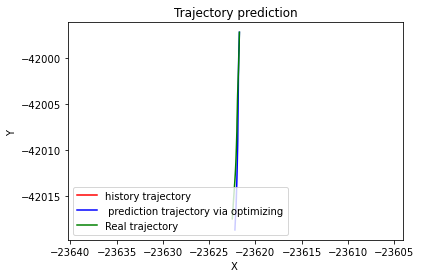

Test loss: 0.009966901227508268
MSE pre: 23.337035375184975
MSE RST: 0.5730356932151204
ADE_rst: 0.9419197430861997
FDE_rst: 1.363070735477004
ADE_pre: 6.205712806259244
FDE_pre: 10.332361143138861


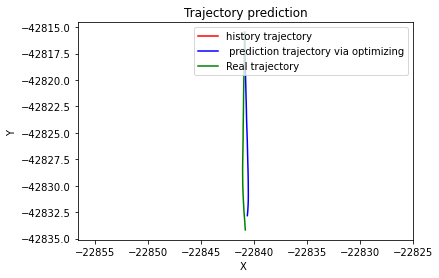

Test loss: 0.011493746549590957
MSE pre: 14.112365760273196
MSE RST: 0.22396032101051394
ADE_rst: 0.5887812664093673
FDE_rst: 1.1558148734704758
ADE_pre: 5.031614194743081
FDE_pre: 3.828236662460003


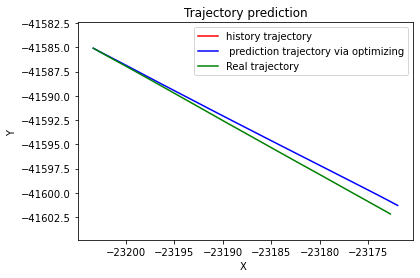

Test loss: 0.011699857876469348
MSE pre: 29.97503723278701
MSE RST: 5.237792260703725
ADE_rst: 2.4380629923094284
FDE_rst: 6.411306631383095
ADE_pre: 7.510993348860268
FDE_pre: 11.120688279525


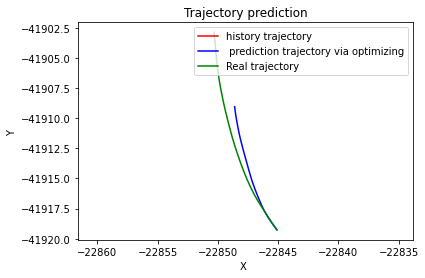

Test loss: 0.011231793021538245
MSE pre: 17.539901680894133
MSE RST: 0.36727597625575603
ADE_rst: 0.5974823677010485
FDE_rst: 2.016669300197802
ADE_pre: 5.511995641227464
FDE_pre: 8.820986193488723


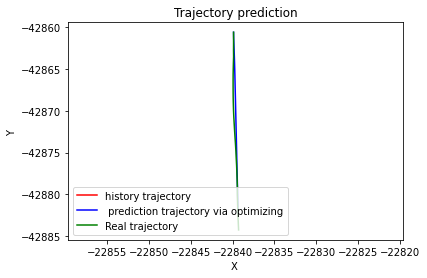

Test loss: 0.010854113586664717
MSE pre: 3.4515590754874634
MSE RST: 0.09218922420867609
ADE_rst: 0.3841148003509677
FDE_rst: 0.6709678835951272
ADE_pre: 2.3906819716289083
FDE_pre: 5.360711345401217


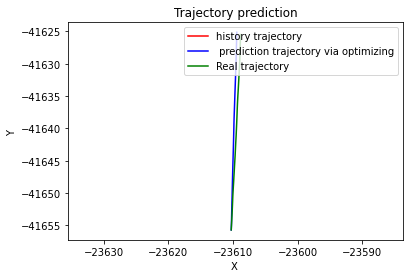

Test loss: 0.011710776752882436
MSE pre: 2.6526264552377334
MSE RST: 0.061445671171812294
ADE_rst: 0.27809368503305837
FDE_rst: 0.5090223956660628
ADE_pre: 2.118665810364738
FDE_pre: 3.216938633835867


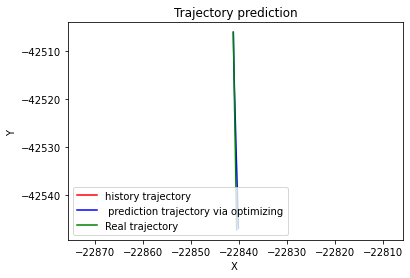

Test loss: 0.015195608870216386
MSE pre: 11.798915487383379
MSE RST: 0.12360558071968276
ADE_rst: 0.3841305770254225
FDE_rst: 1.234333641718807
ADE_pre: 4.327905050624784
FDE_pre: 4.6268540709363375


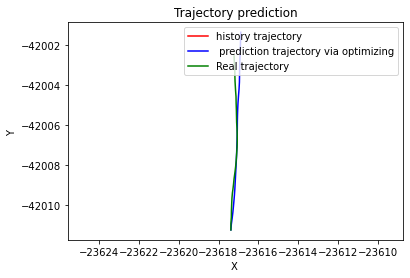

Test loss: 0.00816409014488715
MSE pre: 13.80206657326796
MSE RST: 0.13263758522587013
ADE_rst: 0.46274231106711144
FDE_rst: 0.5864047857117781
ADE_pre: 4.130248599774138
FDE_pre: 13.548181704544575


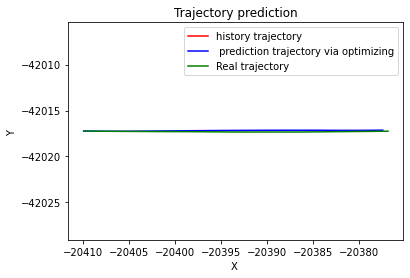

Test loss: 0.008424503865083867
MSE pre: 3.318375200372432
MSE RST: 0.0979559872258114
ADE_rst: 0.32031150226034716
FDE_rst: 1.0544486504299255
ADE_pre: 2.1770315017109625
FDE_pre: 6.4284353411512605


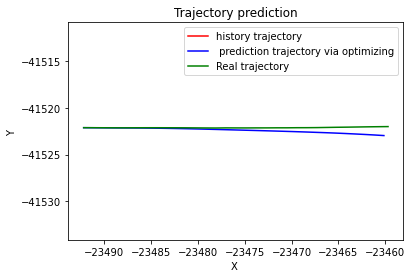

Test loss: 0.019870664347090176
MSE pre: 3.0604020168665107
MSE RST: 0.1044147601654665
ADE_rst: 0.40562992790922864
FDE_rst: 0.7691597493451242
ADE_pre: 2.2469044516343395
FDE_pre: 4.83496922281894


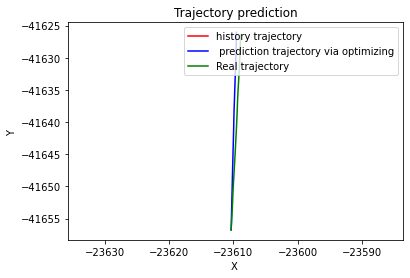

Test loss: 0.009251220964247889
MSE pre: 47.1843303364456
MSE RST: 0.758308170969932
ADE_rst: 1.0730452939586592
FDE_rst: 2.1928823729944096
ADE_pre: 9.337424695759218
FDE_pre: 7.649380204429355


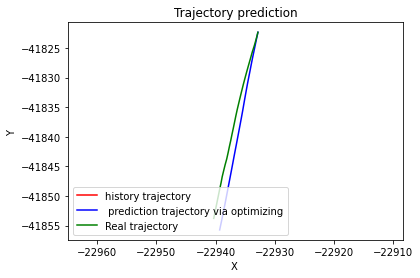

Test loss: 0.01023616522004252
MSE pre: 11.861128968837447
MSE RST: 0.030804110216698273
ADE_rst: 0.2334718842061841
FDE_rst: 0.317329138723905
ADE_pre: 4.423174431970902
FDE_pre: 3.2388547526090328


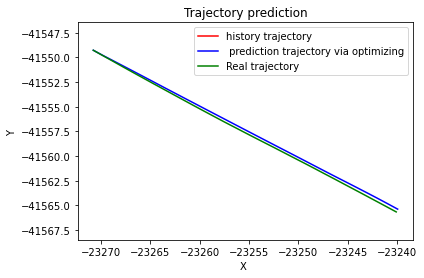

Test loss: 0.015484414870841862
MSE pre: 18.98235500069471
MSE RST: 2.7682668427786687
ADE_rst: 1.956993944113975
FDE_rst: 4.0721828109626
ADE_pre: 5.722294806942503
FDE_pre: 6.495442639766604


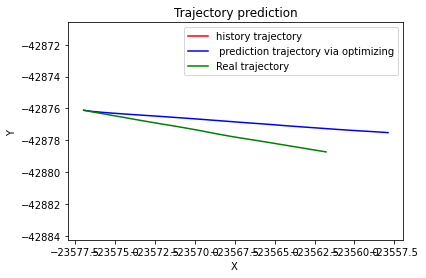

Test loss: 0.008260416046969043
MSE pre: 12.220935094754681
MSE RST: 1.6814786750101387
ADE_rst: 1.6334349681591438
FDE_rst: 2.8902304725878105
ADE_pre: 4.317822040907011
FDE_pre: 8.87014071457857


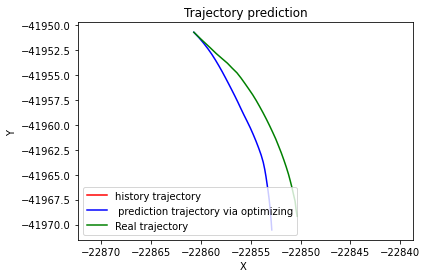

Test loss: 0.010312325585198238
MSE pre: 18.686494890847754
MSE RST: 0.5032546577403958
ADE_rst: 0.8234932292939893
FDE_rst: 1.8104004886513578
ADE_pre: 5.044157559414812
FDE_pre: 8.838288376528498


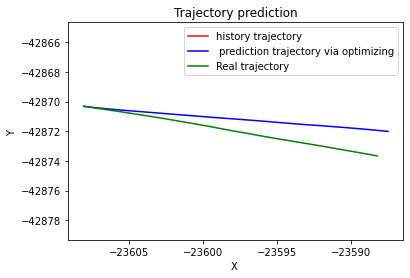

Test loss: 0.008575641087273376
MSE pre: 9.336690281917864
MSE RST: 0.7437830200540247
ADE_rst: 0.9558532013546369
FDE_rst: 2.2916801335408934
ADE_pre: 4.002507168821743
FDE_pre: 6.399530562503842


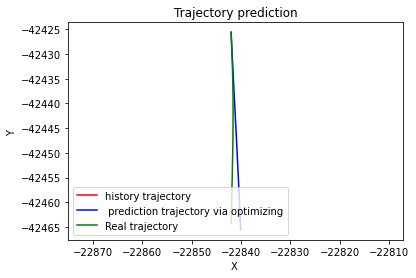

Test loss: 0.011933390209431058
MSE pre: 8.189092892114727
MSE RST: 1.0994890211201833
ADE_rst: 1.202038651089674
FDE_rst: 1.7301326772123993
ADE_pre: 3.1587926017015033
FDE_pre: 12.912199790642358


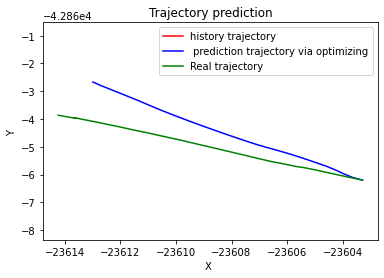

Test loss: 0.015099295291826319
MSE pre: 13.286966356276002
MSE RST: 0.10676395250952424
ADE_rst: 0.3996885015502948
FDE_rst: 0.937588175875459
ADE_pre: 4.872891404571439
FDE_pre: 6.581666142874416


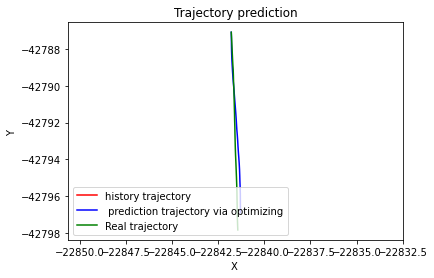

Test loss: 0.010394755586208056
MSE pre: 7.60716783110987
MSE RST: 0.07738094012571183
ADE_rst: 0.3336608692054908
FDE_rst: 0.6029444591667588
ADE_pre: 3.309995442760771
FDE_pre: 6.8253127548111845


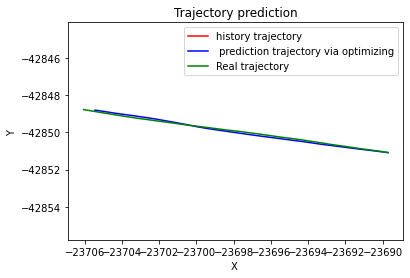

Test loss: 0.009811096339549684
MSE pre: 27.62345234822206
MSE RST: 0.11709895082581198
ADE_rst: 0.40855389304600526
FDE_rst: 0.8933202531278489
ADE_pre: 7.296426655566341
FDE_pre: 6.623233969852625


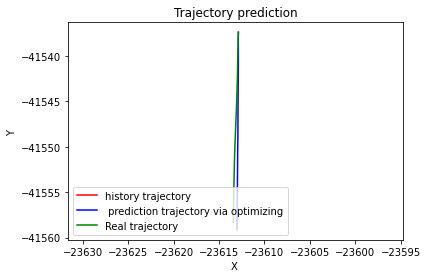

Test loss: 0.00944870105203845
MSE pre: 20.64359761672653
MSE RST: 0.15962658134270533
ADE_rst: 0.5005868014691661
FDE_rst: 0.6814253938449045
ADE_pre: 6.153770341612125
FDE_pre: 8.186478228920757


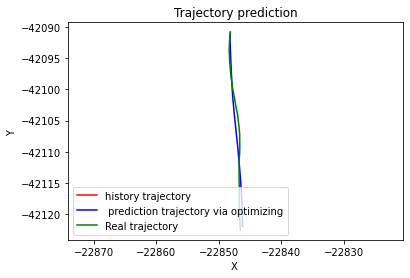

Test loss: 0.009200639074296711
MSE pre: 23.354754469839367
MSE RST: 4.020807254548327
ADE_rst: 2.102245460555986
FDE_rst: 6.227791577044269
ADE_pre: 5.787742523085678
FDE_pre: 4.368521321802248


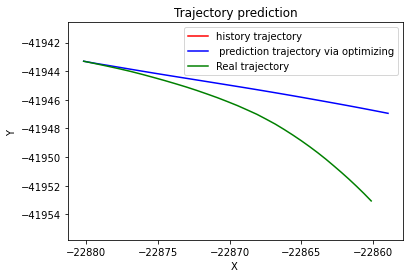

Test loss: 0.010667134470857698
MSE pre: 54.282982533763246
MSE RST: 0.6871346378238425
ADE_rst: 0.9817812860620475
FDE_rst: 2.2400016716084514
ADE_pre: 7.620435061372464
FDE_pre: 27.407890298591575


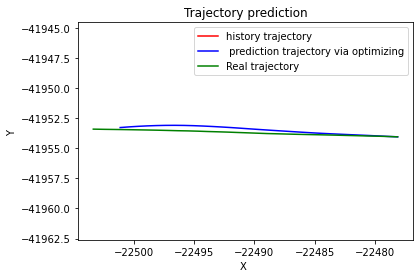

Test loss: 0.009557505283301985
MSE pre: 12.113934465142737
MSE RST: 2.174171578281309
ADE_rst: 1.5163077687980202
FDE_rst: 3.9224135303395053
ADE_pre: 4.388410948058058
FDE_pre: 10.220423407744775


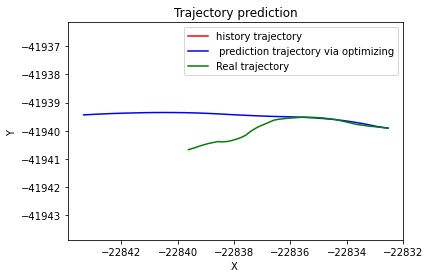

Test loss: 0.009730301860756923
MSE pre: 12.332250718297617
MSE RST: 0.2061062029291145
ADE_rst: 0.5806140110610647
FDE_rst: 0.570808878817699
ADE_pre: 4.636174388413075
FDE_pre: 9.537112091947735


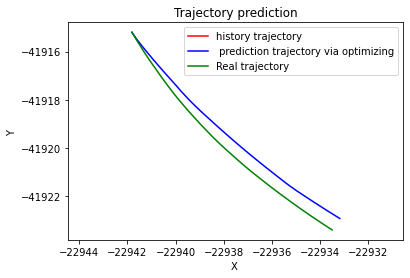

Test loss: 0.010849876380925463
MSE pre: 18.192977209508907
MSE RST: 2.4449629576958767
ADE_rst: 1.8906394944042855
FDE_rst: 3.7249184891216034
ADE_pre: 5.922002360668627
FDE_pre: 9.220739948965235


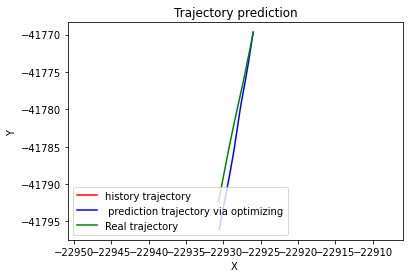

Test loss: 0.00886585129471928
MSE pre: 10.370035204177489
MSE RST: 0.6593219703366091
ADE_rst: 0.9016055943130425
FDE_rst: 2.154472039156398
ADE_pre: 4.0870383783378745
FDE_pre: 7.009597626896642


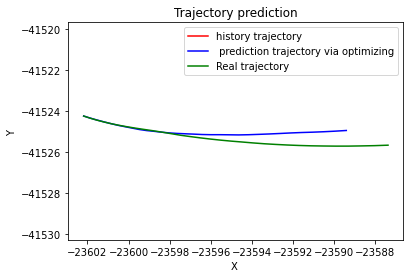

Test loss: 0.016636159646608938
MSE pre: 11.519116487218795
MSE RST: 1.8103401662787915
ADE_rst: 1.305619646529153
FDE_rst: 6.639836606617588
ADE_pre: 3.9656525984781688
FDE_pre: 10.833188216191887


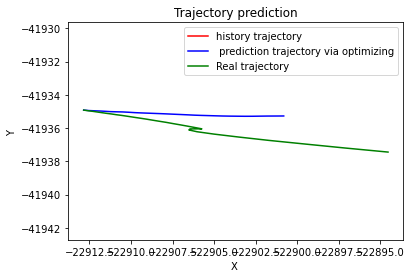

Test loss: 0.012588106916027774
MSE pre: 28.088639530512204
MSE RST: 0.8224840557089308
ADE_rst: 0.923067442786041
FDE_rst: 2.7486012732832763
ADE_pre: 5.752049385573789
FDE_pre: 19.32278585390933


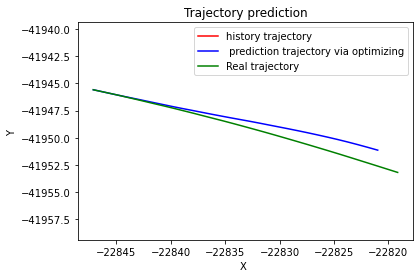

Test loss: 0.009280847319957207
MSE pre: 6.657405714556742
MSE RST: 0.25797654829212346
ADE_rst: 0.5803709479915027
FDE_rst: 1.2883909859282243
ADE_pre: 3.546001777034489
FDE_pre: 2.990442646839363


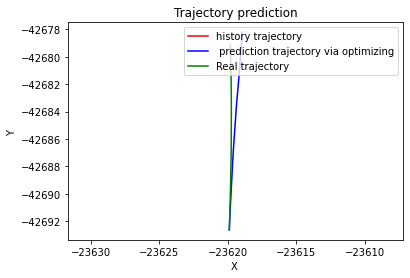

Test loss: 0.009423645711587846
MSE pre: 5.166384443815979
MSE RST: 0.5521437815582806
ADE_rst: 0.8264023273302132
FDE_rst: 2.195748888023125
ADE_pre: 2.896549874411304
FDE_pre: 5.608763962806734


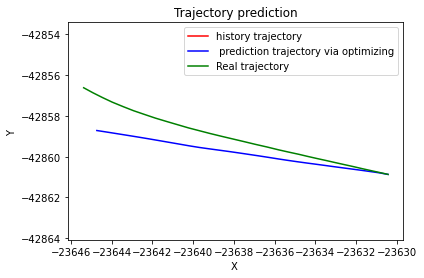

Test loss: 0.009841080909505905
MSE pre: 7.173369291121269
MSE RST: 0.30788512807597906
ADE_rst: 0.6888445008963898
FDE_rst: 1.3598657813634014
ADE_pre: 3.329061651045398
FDE_pre: 3.432081255614547


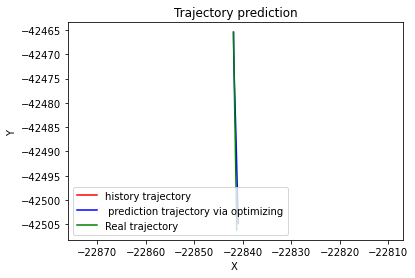

Test loss: 0.008062616913208307
MSE pre: 4.736186733768355
MSE RST: 0.1775224776677902
ADE_rst: 0.4696180873734025
FDE_rst: 1.163254915864086
ADE_pre: 3.0292795060101856
FDE_pre: 2.196901741408644


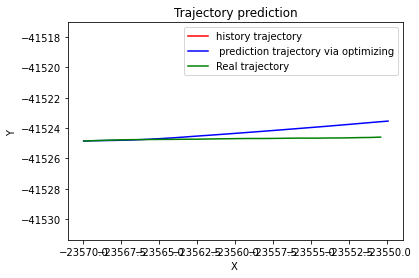

Test loss: 0.010273152439040386
MSE pre: 9.187959673825057
MSE RST: 0.8822590064047321
ADE_rst: 1.0800459649352296
FDE_rst: 2.5462840966896523
ADE_pre: 4.073105904012316
FDE_pre: 5.213643614929254


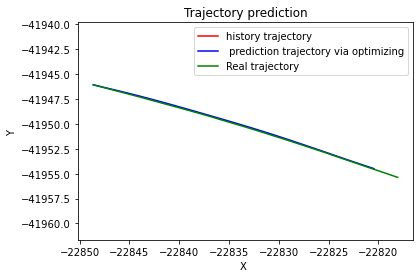

Test loss: 0.008474101418371363
MSE pre: 32.35665230571082
MSE RST: 0.05071411836007772
ADE_rst: 0.25504561384216895
FDE_rst: 0.6427974428311738
ADE_pre: 7.7789277935215075
FDE_pre: 4.522711469803894


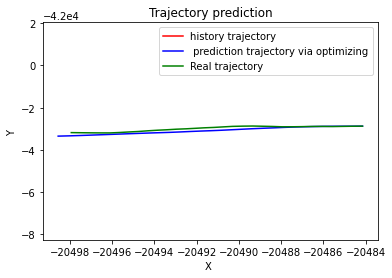

Test loss: 0.006893651050156608
MSE pre: 14.89710839122436
MSE RST: 1.2595553781558153
ADE_rst: 1.273950767711663
FDE_rst: 3.0979361619630175
ADE_pre: 5.1553600961159765
FDE_pre: 7.094019250035254


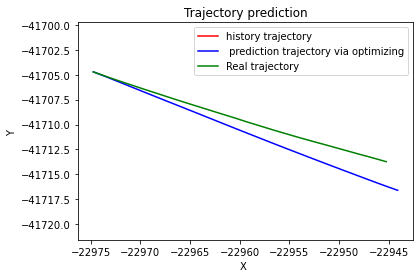

Test loss: 0.016315054738227034
MSE pre: 107.0299608033263
MSE RST: 3.963470884911213
ADE_rst: 2.3009576071106737
FDE_rst: 5.1447210660879685
ADE_pre: 13.663582131033454
FDE_pre: 16.015474563272225


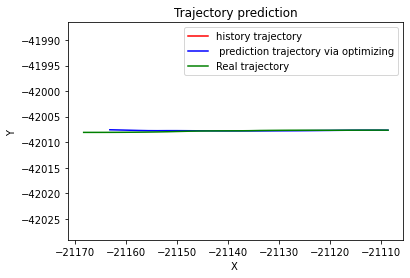

Test loss: 0.0075078809477503415
MSE pre: 6.230075956415163
MSE RST: 0.07712572924508716
ADE_rst: 0.3074693058770517
FDE_rst: 1.012423766945583
ADE_pre: 2.8425515240626864
FDE_pre: 9.049936872144608


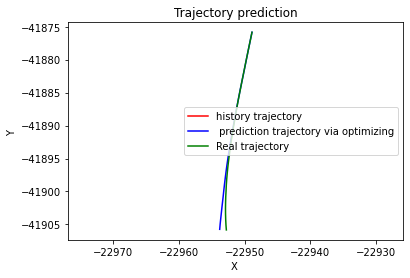

Test loss: 0.009800607828805614
MSE pre: 10.805041125199171
MSE RST: 0.8897603954471525
ADE_rst: 1.1335936827305249
FDE_rst: 2.3022314433881172
ADE_pre: 4.555390649317252
FDE_pre: 7.262454456531345


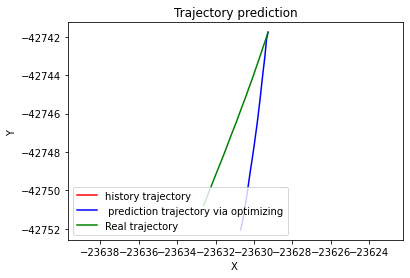

Test loss: 0.008607954276731566
MSE pre: 16.148028921622203
MSE RST: 0.11781502204449007
ADE_rst: 0.3346769506728755
FDE_rst: 1.043979498619205
ADE_pre: 4.881909257373108
FDE_pre: 12.593609856227513


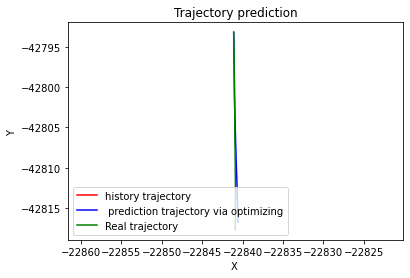

Test loss: 0.009837809179156004
MSE pre: 27.093868087219008
MSE RST: 0.7752827100511552
ADE_rst: 1.0355955792472098
FDE_rst: 2.274262865912094
ADE_pre: 6.998301821679229
FDE_pre: 4.141188133392595


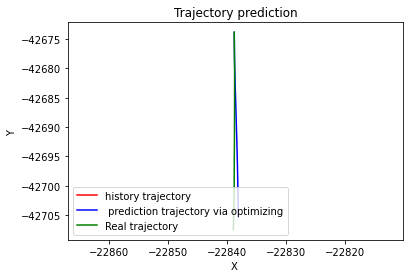

Test loss: 0.011749849781918892
MSE pre: 11.33146645941777
MSE RST: 2.973726149358406
ADE_rst: 2.0440025647679407
FDE_rst: 4.6526368503306905
ADE_pre: 4.447345701609347
FDE_pre: 3.3706982672361026


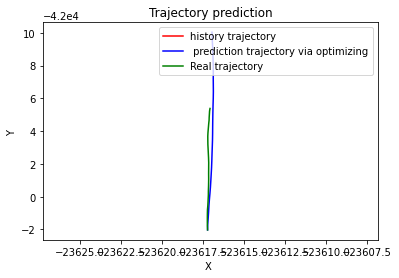

Test loss: 0.007195165955602976
MSE pre: 34.103628225877316
MSE RST: 1.6250989690632545
ADE_rst: 1.587114231630827
FDE_rst: 2.192133261462677
ADE_pre: 7.370572752426151
FDE_pre: 10.772859878667537


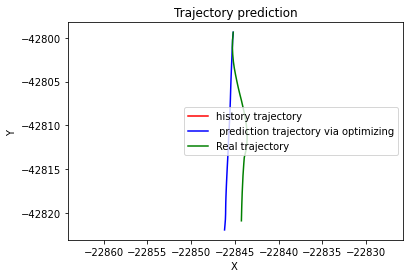

Test loss: 0.012451714114554974
MSE pre: 6.119506720503747
MSE RST: 1.061679892799009
ADE_rst: 1.312907620313486
FDE_rst: 1.5473643408595301
ADE_pre: 3.1249113761341314
FDE_pre: 3.7484822024071955


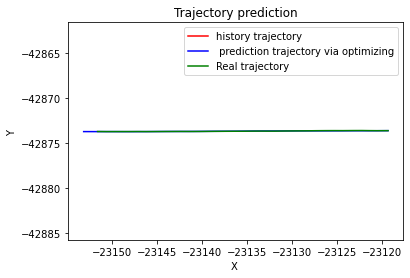

Test loss: 0.01580057521139104
MSE pre: 11.874600180708567
MSE RST: 0.5192213428550044
ADE_rst: 0.909332344959868
FDE_rst: 1.4872699495355899
ADE_pre: 4.290059120860961
FDE_pre: 12.25586767661528


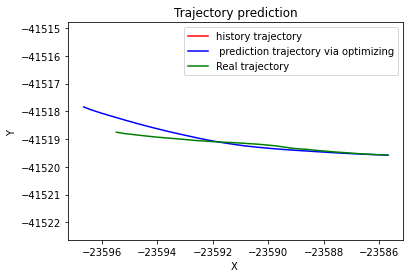

Test loss: 0.00800233618580937
MSE pre: 10.546061036099179
MSE RST: 0.2527503345557986
ADE_rst: 0.570218277852573
FDE_rst: 1.418726234299009
ADE_pre: 4.246772413818071
FDE_pre: 8.920417922081302


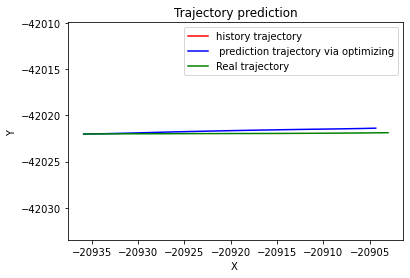

Test loss: 0.015396271090740236
MSE pre: 53.07642070562113
MSE RST: 0.09073579432195475
ADE_rst: 0.38069062672950593
FDE_rst: 0.7534357401138593
ADE_pre: 9.625359620301698
FDE_pre: 3.1419228630555507


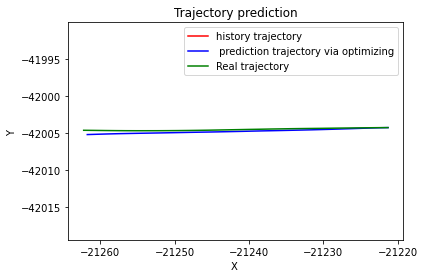

Test loss: 0.013668569583441774
MSE pre: 25.494126141272833
MSE RST: 0.28303117148989293
ADE_rst: 0.5659620724975992
FDE_rst: 1.8014754705892693
ADE_pre: 7.022844173895262
FDE_pre: 6.953675743133592


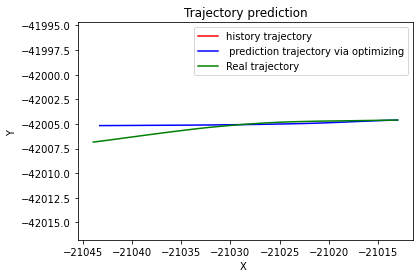

Test loss: 0.009736405289701527
MSE pre: 13.61319566515733
MSE RST: 0.7552105032345026
ADE_rst: 1.0221506329984262
FDE_rst: 2.444819423615116
ADE_pre: 4.993007623641413
FDE_pre: 6.844491084287584


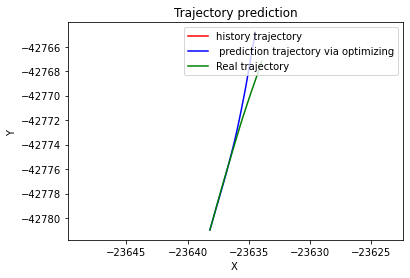

Test loss: 0.0086905835678316
MSE pre: 12.182434381807461
MSE RST: 1.1874045177045707
ADE_rst: 1.275188078764774
FDE_rst: 3.1733561581503165
ADE_pre: 4.679913017055934
FDE_pre: 3.729182027164109


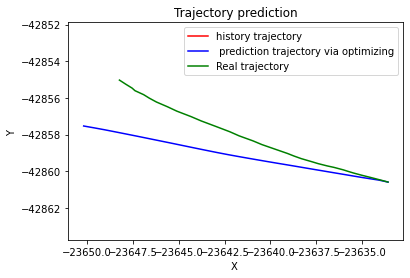

Test loss: 0.008345427958971328
MSE pre: 6.087495142644543
MSE RST: 1.6217220967477906
ADE_rst: 1.3539702298638363
FDE_rst: 3.807119654899565
ADE_pre: 3.199348111307764
FDE_pre: 7.790704939823827


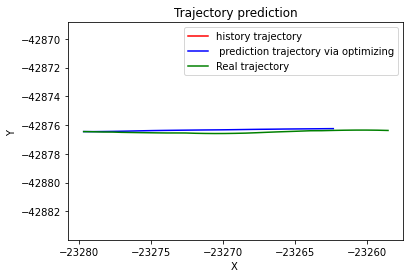

Test loss: 0.010640657458695725
MSE pre: 14.220033156065051
MSE RST: 2.6591221725390954
ADE_rst: 1.9164926466369063
FDE_rst: 4.192077110654925
ADE_pre: 4.58345897417059
FDE_pre: 1.4089336885117776


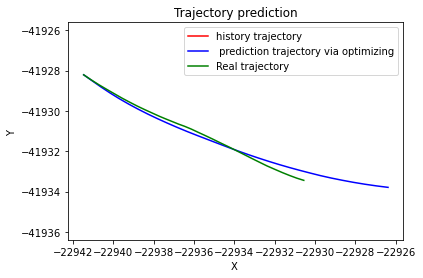

Test loss: 0.008633324296178801
MSE pre: 23.363430332933614
MSE RST: 6.185066707240034
ADE_rst: 2.481253472145479
FDE_rst: 8.012729157446778
ADE_pre: 6.393739266404878
FDE_pre: 5.627047042085043


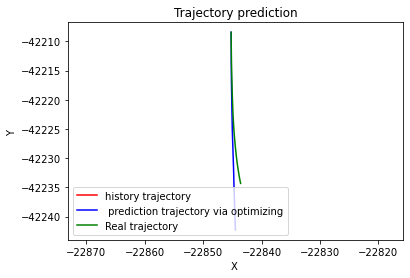

Test loss: 0.01295776533306205
MSE pre: 3.8783219821034014
MSE RST: 1.0338535918711682
ADE_rst: 1.1154620634996626
FDE_rst: 3.176461382416745
ADE_pre: 2.3519254173211066
FDE_pre: 8.536993189416473


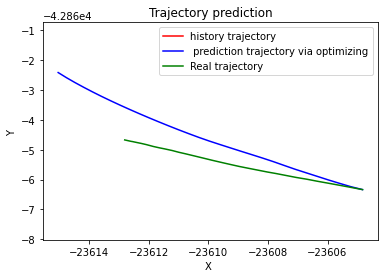

Test loss: 0.009416398475241557
MSE pre: 9.038334857594808
MSE RST: 1.2324706899921003
ADE_rst: 1.2612253664822464
FDE_rst: 2.961638411355172
ADE_pre: 3.3788889218134495
FDE_pre: 14.167147351268959


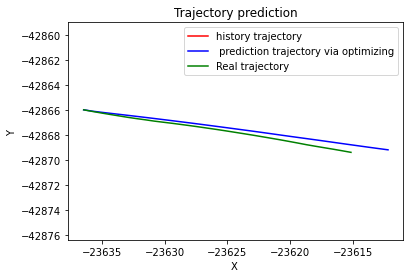

Test loss: 0.007908633237965845
MSE pre: 4.975795019021983
MSE RST: 0.3428001636304162
ADE_rst: 0.6435082669273233
FDE_rst: 1.6801413124283033
ADE_pre: 2.7275884528136527
FDE_pre: 5.132124132693701


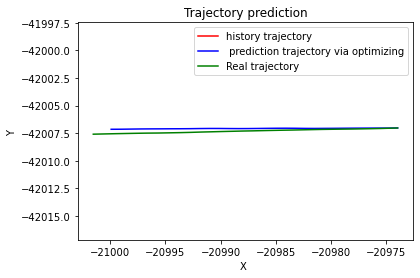

Test loss: 0.013468238787643116
MSE pre: 70.35537783919125
MSE RST: 0.03754635883879578
ADE_rst: 0.22700601075399127
FDE_rst: 0.35783070141813683
ADE_pre: 11.172296779406516
FDE_pre: 15.390510311456172


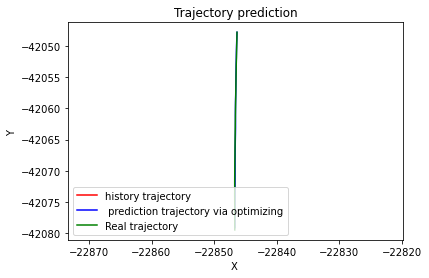

Test loss: 0.010323872440353593
MSE pre: 11.401752768854788
MSE RST: 0.4343669524457016
ADE_rst: 0.6667847404808265
FDE_rst: 1.9459486466682065
ADE_pre: 4.618616997362776
FDE_pre: 2.1605821898998774


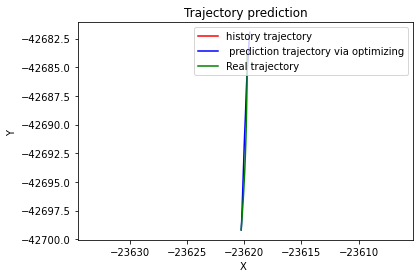

Test loss: 0.015365748016886697
MSE pre: 38.65941234012519
MSE RST: 20.15921006684712
ADE_rst: 5.764290878787708
FDE_rst: 8.78605041133538
ADE_pre: 8.249841403494447
FDE_pre: 4.155360763682395


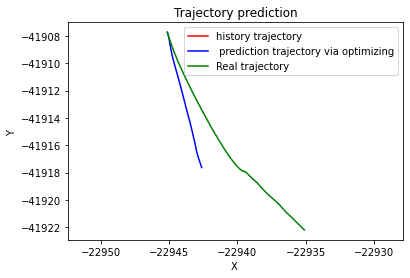

Test loss: 0.013408699454736644
MSE pre: 45.259346807228084
MSE RST: 0.11437018154108086
ADE_rst: 0.3844785803655276
FDE_rst: 1.028137320573408
ADE_pre: 9.349053126091297
FDE_pre: 6.701985500242581


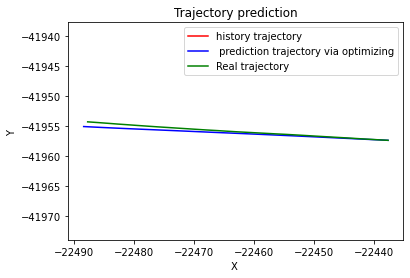

Test loss: 0.010487453701457056
MSE pre: 10.006045553881863
MSE RST: 0.24083758231085076
ADE_rst: 0.6078169056247609
FDE_rst: 0.9004626285301055
ADE_pre: 4.1844849904192
FDE_pre: 1.3874572718808655


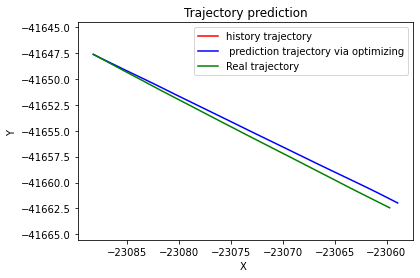

Test loss: 0.010012522603141692
MSE pre: 8.835454773523944
MSE RST: 15.386388359101353
ADE_rst: 4.3843077871438005
FDE_rst: 10.97582965431329
ADE_pre: 3.7052765521861897
FDE_pre: 0.6432223121491008


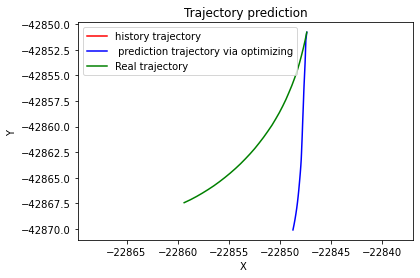

Test loss: 0.009287467616751808
MSE pre: 16.378884837813374
MSE RST: 0.8978817287303531
ADE_rst: 1.2607430271440712
FDE_rst: 0.8477957776894203
ADE_pre: 5.411879134512382
FDE_pre: 8.089237281020681


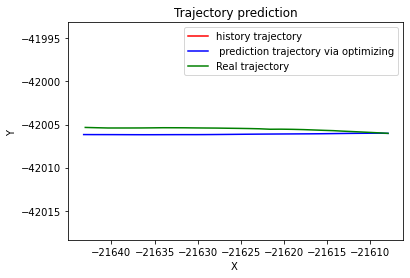

Test loss: 0.008755262392131603
MSE pre: 36.92098689710259
MSE RST: 0.28356894808707767
ADE_rst: 0.6458193717531325
FDE_rst: 1.7875092396792414
ADE_pre: 7.569655955810599
FDE_pre: 6.535158632576935


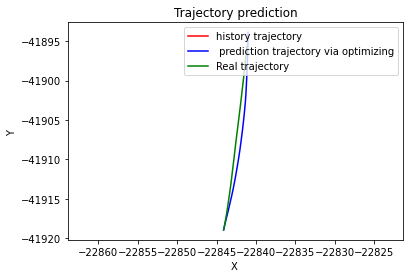

Test loss: 0.009596159405504024
MSE pre: 15.073571572829588
MSE RST: 0.6485046960838651
ADE_rst: 0.9935127331792047
FDE_rst: 1.7325546961135232
ADE_pre: 5.180339988304011
FDE_pre: 2.042528103206325


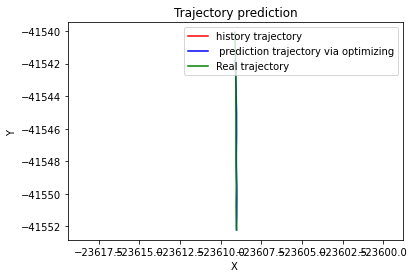

Test loss: 0.009156725739692485
MSE pre: 79.95384043109752
MSE RST: 0.10012607555259938
ADE_rst: 0.42252105947518154
FDE_rst: 0.41834098350876114
ADE_pre: 10.871248051589419
FDE_pre: 7.24811294336709


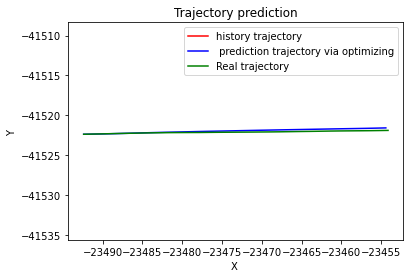

Test loss: 0.010669358428424407
MSE pre: 28.226810571179197
MSE RST: 0.6124363775035169
ADE_rst: 0.9662812251367907
FDE_rst: 1.9615892849209564
ADE_pre: 7.425870318340288
FDE_pre: 7.004358547230596


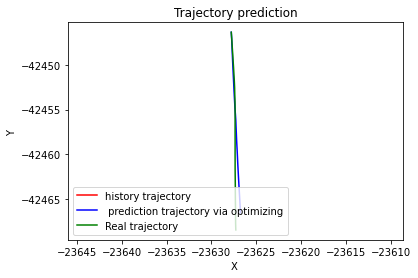

Test loss: 0.010469005937620965
MSE pre: 22.77442323115933
MSE RST: 0.2477463299308845
ADE_rst: 0.649888500776187
FDE_rst: 1.0042206497231625
ADE_pre: 6.192208952690609
FDE_pre: 3.2071427797157694


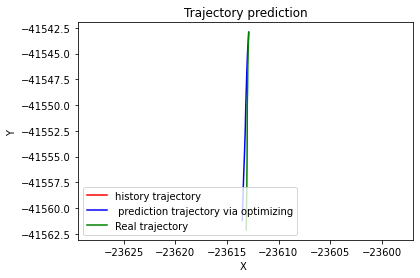

Test loss: 0.011591935002260424
MSE pre: 24.639368500506563
MSE RST: 0.8986438187465475
ADE_rst: 1.1465076028525987
FDE_rst: 2.3216191625173996
ADE_pre: 6.881053688203887
FDE_pre: 9.110236692450629


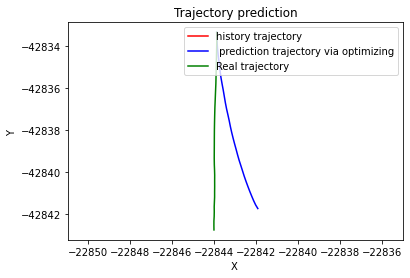

Test loss: 0.009375299649454527
MSE pre: 8.616925359197955
MSE RST: 0.9468699040793865
ADE_rst: 1.1756356246147732
FDE_rst: 2.563304940409347
ADE_pre: 3.6614695336584853
FDE_pre: 2.2371470907026403


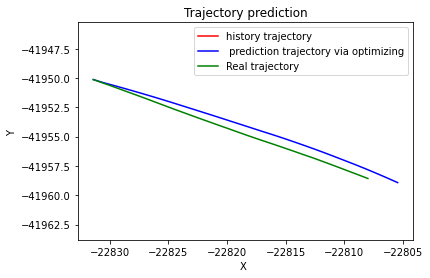

Test loss: 0.014066886062250207
MSE pre: 31.466452181578006
MSE RST: 0.3873785513818126
ADE_rst: 0.7853421628284412
FDE_rst: 1.4177963271502407
ADE_pre: 7.563115790281525
FDE_pre: 6.981905324989839


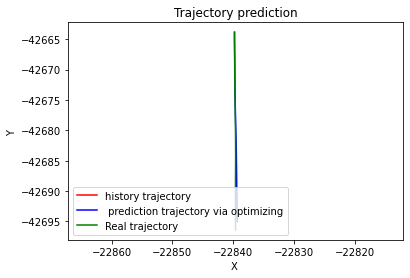

Test loss: 0.011477709155680242
MSE pre: 70.64598203448784
MSE RST: 4.625454216224169
ADE_rst: 2.5659799837273964
FDE_rst: 5.330841585808359
ADE_pre: 11.631443481592902
FDE_pre: 13.906771590249168


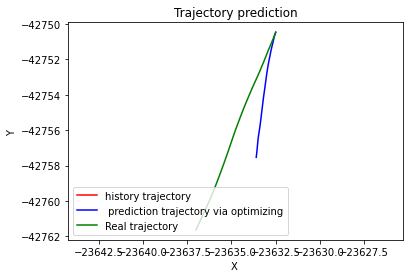

Test loss: 0.009501848807600532
MSE pre: 9.560130939116045
MSE RST: 0.4822289090073695
ADE_rst: 0.8085390664853659
FDE_rst: 1.7096265987974915
ADE_pre: 4.2904362637539295
FDE_pre: 3.7602616324636373


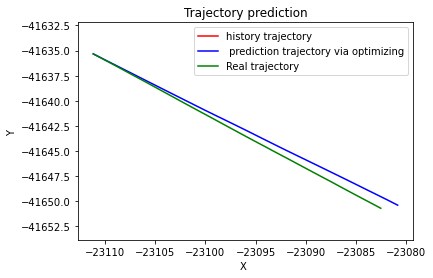

Test loss: 0.009281425169125857
MSE pre: 10.024908514484977
MSE RST: 0.3142080842605509
ADE_rst: 0.6777433164194725
FDE_rst: 1.435597016056259
ADE_pre: 4.334461135573677
FDE_pre: 5.626754174596481


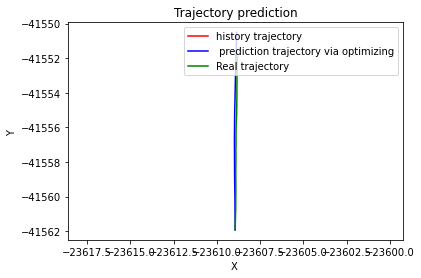

Test loss: 0.007144387597775521
MSE pre: 29.32170631880439
MSE RST: 0.08625898483662972
ADE_rst: 0.28587379731797674
FDE_rst: 1.1409016238587122
ADE_pre: 7.006553743575593
FDE_pre: 9.7630213800595


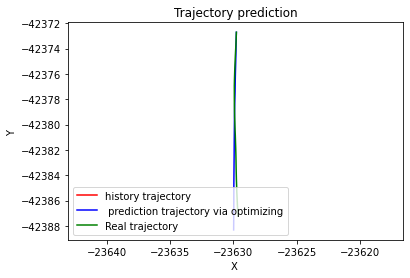

Test loss: 0.009282831328607901
MSE pre: 4.627150257139657
MSE RST: 0.32243409788490957
ADE_rst: 0.5918025040027346
FDE_rst: 1.5591258947839248
ADE_pre: 2.7026430819140486
FDE_pre: 1.2935044142450092


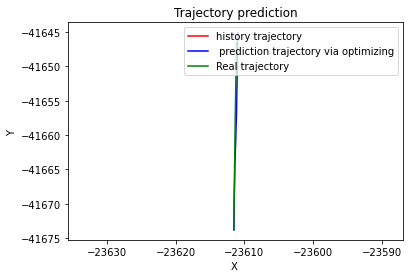

Test loss: 0.011470849789868898
MSE pre: 5.796613703597253
MSE RST: 3.6882413829989296
ADE_rst: 2.3072776862732622
FDE_rst: 4.856562263438486
ADE_pre: 3.27133978196673
FDE_pre: 1.8550964860914854


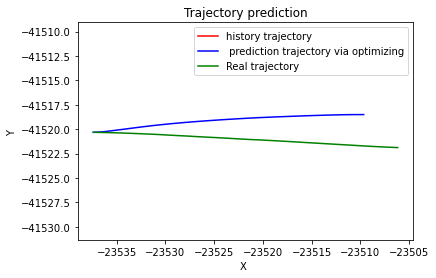

Test loss: 0.007986400742857029
MSE pre: 14.165727213031838
MSE RST: 4.149091133130679
ADE_rst: 2.3962836428897925
FDE_rst: 4.729925470598243
ADE_pre: 4.728219116889238
FDE_pre: 10.509939579141319


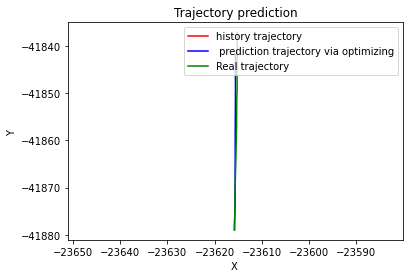

Test loss: 0.01041503532873697
MSE pre: 22.474507813393565
MSE RST: 2.1882941203066055
ADE_rst: 1.7070334421126514
FDE_rst: 3.4440713348883563
ADE_pre: 6.480483599278302
FDE_pre: 5.8179993063547535


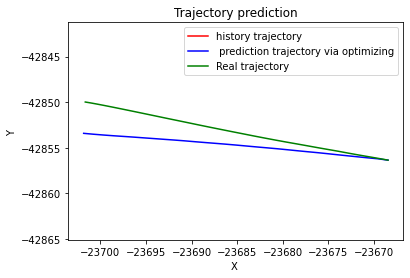

Test loss: 0.008025554169346014
MSE pre: 31.080380952201914
MSE RST: 0.8488541404642571
ADE_rst: 1.1269765911037153
FDE_rst: 2.3057359158394997
ADE_pre: 7.292330531280778
FDE_pre: 10.942518156894245


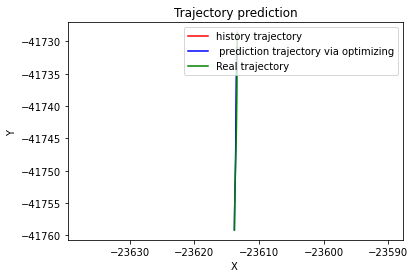

Test loss: 0.00922261676202246
MSE pre: 14.960547449586988
MSE RST: 5.209938435970866
ADE_rst: 2.5465326804139017
FDE_rst: 6.471619335280551
ADE_pre: 4.426197679798218
FDE_pre: 15.376145812658153


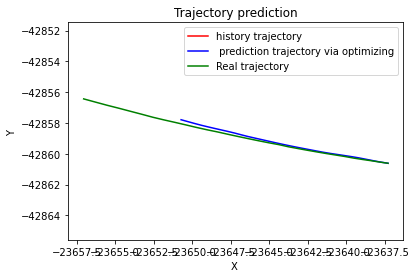

Test loss: 0.013520701925308305
MSE pre: 12.740584228829936
MSE RST: 1.686755287558276
ADE_rst: 1.5269077159318722
FDE_rst: 3.5619774609994934
ADE_pre: 4.1809705438030225
FDE_pre: 5.775475602146414


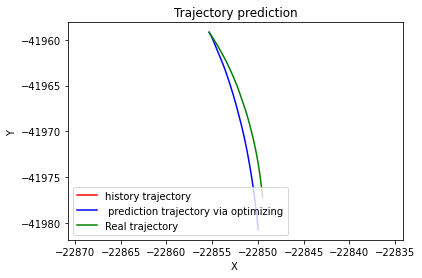

Test loss: 0.010820757250278456
MSE pre: 30.445573284999224
MSE RST: 0.45371299827885986
ADE_rst: 0.7600605328334186
FDE_rst: 1.6811845824257736
ADE_pre: 7.250733932951688
FDE_pre: 4.37783070385691


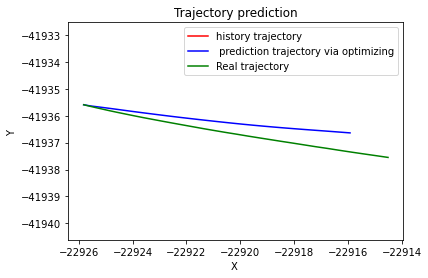

Test loss: 0.014912263072382595
MSE pre: 16.403527067295943
MSE RST: 0.039135281527603274
ADE_rst: 0.23114173220450682
FDE_rst: 0.20303870661097714
ADE_pre: 5.259733770119839
FDE_pre: 4.30405294816339


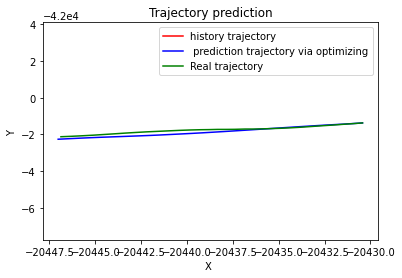

Test loss: 0.018320049358999807
MSE pre: 77.81373645444646
MSE RST: 0.40176825934161836
ADE_rst: 0.7412571392917038
FDE_rst: 1.8798078529070794
ADE_pre: 11.854558148685257
FDE_pre: 7.4730997199369265


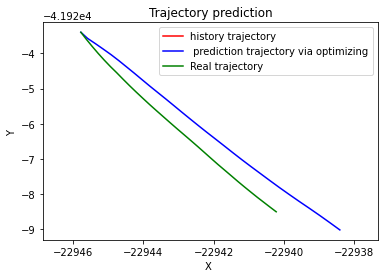

Test loss: 0.01002478326698949
MSE pre: 10.075700312883649
MSE RST: 0.20063397958425405
ADE_rst: 0.5432799931317992
FDE_rst: 1.1135763681986772
ADE_pre: 4.3017233332819345
FDE_pre: 0.9235393493193422


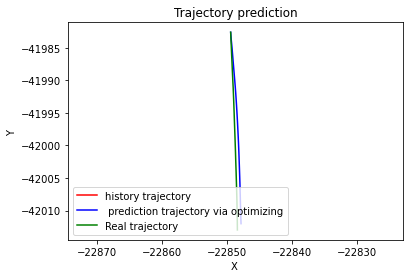

Test loss: 0.009620551587691636
MSE pre: 10.152075677970378
MSE RST: 0.9280101256356125
ADE_rst: 1.189876047707659
FDE_rst: 0.7352798662814674
ADE_pre: 4.268704334408625
FDE_pre: 3.048295751190078


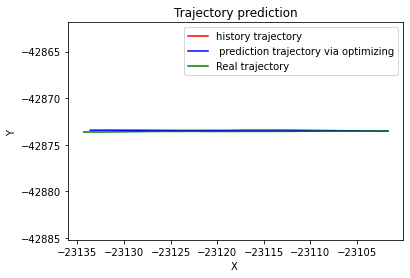

Test loss: 0.009988321493868838
MSE pre: 20.795918674397953
MSE RST: 2.5462679437815363
ADE_rst: 1.8793106885112958
FDE_rst: 4.210885549649216
ADE_pre: 6.278773363164764
FDE_pre: 4.984189908289037


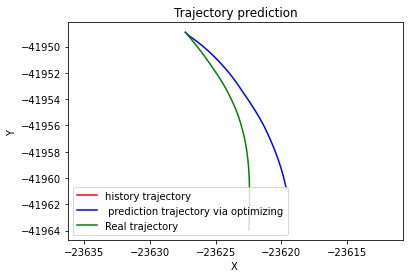

Test loss: 0.008466573004193905
MSE pre: 19.80913157733757
MSE RST: 0.6658669857671712
ADE_rst: 0.900502987466685
FDE_rst: 2.249835292657664
ADE_pre: 6.082601544427709
FDE_pre: 4.879503952970858


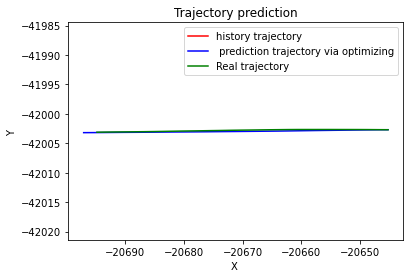

Test loss: 0.01015927046875885
MSE pre: 91.88835104430831
MSE RST: 1.4239674125820518
ADE_rst: 1.4257996333604974
FDE_rst: 2.6583319053199954
ADE_pre: 11.532909747340382
FDE_pre: 4.146152514966342


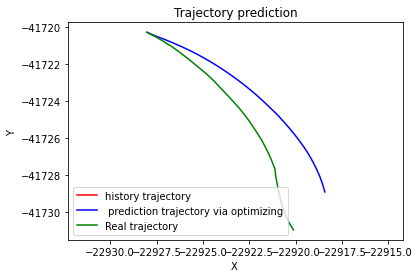

Test loss: 0.010860016315006696
MSE pre: 2.008773847776151
MSE RST: 1.1424143539258163
ADE_rst: 1.3585807021177574
FDE_rst: 2.3353540198308536
ADE_pre: 1.8000858893824085
FDE_pre: 2.6210096985609694


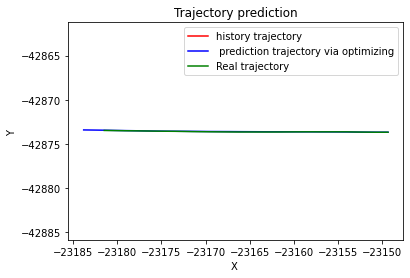

Test loss: 0.00964054343550873
MSE pre: 10.525404964210757
MSE RST: 0.046407808098087804
ADE_rst: 0.24825077898785983
FDE_rst: 0.10684635316629057
ADE_pre: 4.558312946449834
FDE_pre: 6.011828452648968


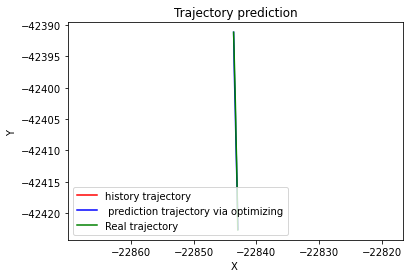

Test loss: 0.009431406082237548
MSE pre: 6.514252129434099
MSE RST: 0.08913517588465955
ADE_rst: 0.381326936028738
FDE_rst: 0.743180754955481
ADE_pre: 3.2686209942099107
FDE_pre: 2.8843970007956825


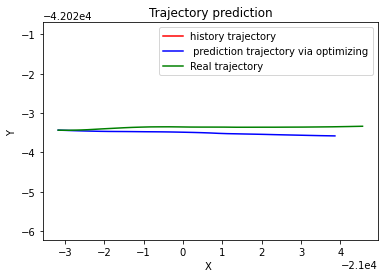

Test loss: 0.007589835767806316
MSE pre: 57.48683134484734
MSE RST: 0.11380966801186712
ADE_rst: 0.4127715498799948
FDE_rst: 0.8431092734419902
ADE_pre: 10.29978367707731
FDE_pre: 7.403993148856087


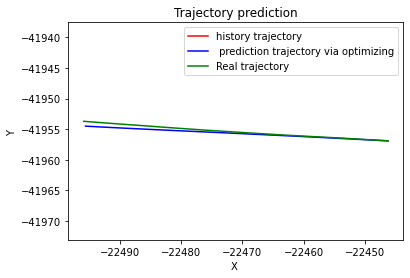

Test loss: 0.016260319209781587
MSE pre: 15.861585880156566
MSE RST: 0.41279739219500583
ADE_rst: 0.7760220686972973
FDE_rst: 1.6004911911850652
ADE_pre: 4.829056206576093
FDE_pre: 5.19163781455948


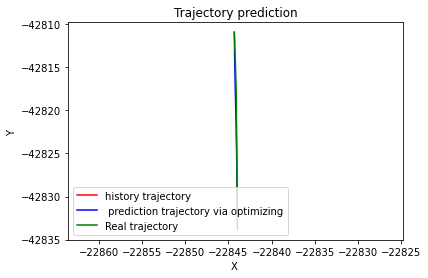

Test loss: 0.011050752181817964
MSE pre: 29.738163496322574
MSE RST: 0.7743012763502465
ADE_rst: 1.056544483542186
FDE_rst: 1.0772051694516918
ADE_pre: 6.833731892704398
FDE_pre: 6.537720818726582


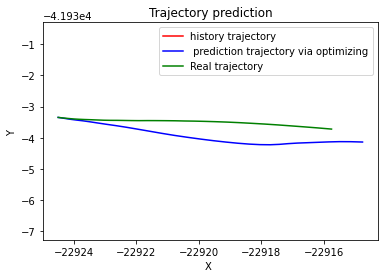

Test loss: 0.008051453695702085
MSE pre: 10.78562638287114
MSE RST: 0.6686751096452547
ADE_rst: 0.857965496799694
FDE_rst: 0.4466687375475525
ADE_pre: 4.268587711176626
FDE_pre: 7.779742011015768


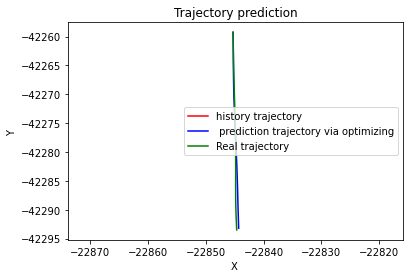

Test loss: 0.010183305490637076
MSE pre: 12.005832382173141
MSE RST: 0.2109966427995427
ADE_rst: 0.5714073616125018
FDE_rst: 0.7564987997601604
ADE_pre: 4.8489484309173365
FDE_pre: 3.4742199850748587


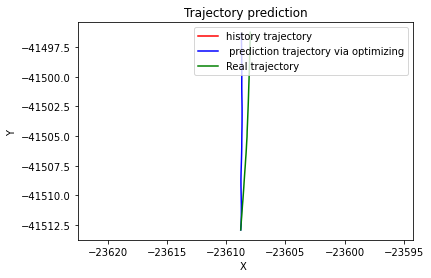

Test loss: 0.012289516003054814
MSE pre: 17.888494696679256
MSE RST: 0.11876763182175754
ADE_rst: 0.42307908971586405
FDE_rst: 0.6881503483691963
ADE_pre: 5.483576553872542
FDE_pre: 4.187909131909756


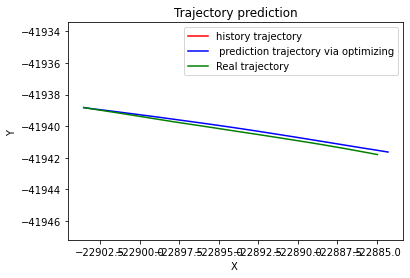

Test loss: 0.00933393779376509
MSE pre: 7.196728258418101
MSE RST: 1.3616185338886442
ADE_rst: 1.4347289695819951
FDE_rst: 2.718252414977589
ADE_pre: 3.338392164618837
FDE_pre: 6.728059259244072


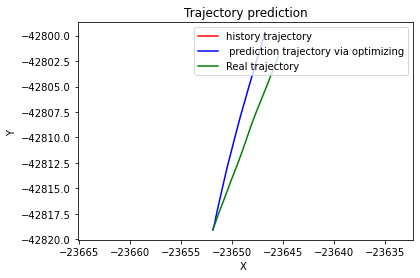

Test loss: 0.012230697326564415
MSE pre: 38.95460449661071
MSE RST: 1.6094519977500552
ADE_rst: 1.4718358487708503
FDE_rst: 3.5000713375970625
ADE_pre: 7.804101093531272
FDE_pre: 4.1819510886783355


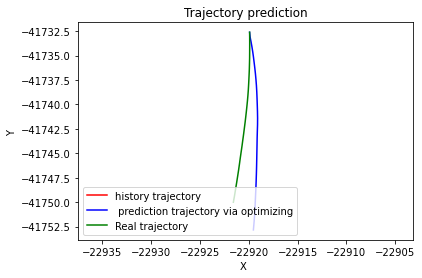

Test loss: 0.007984782205393295
MSE pre: 7.9160598488100975
MSE RST: 0.3357788782369565
ADE_rst: 0.6710550224027453
FDE_rst: 1.4114440232699739
ADE_pre: 3.816465465063952
FDE_pre: 5.946545991007629


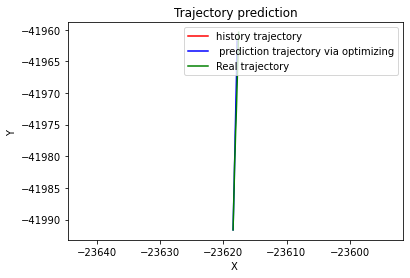

Test loss: 0.014205643160959028
MSE pre: 28.93765515885643
MSE RST: 4.203152364111329
ADE_rst: 2.2527882519134677
FDE_rst: 5.849646518520262
ADE_pre: 7.029474971305247
FDE_pre: 2.488007184019921


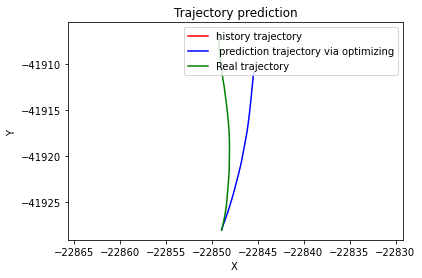

Test loss: 0.008788805855674552
MSE pre: 8.752274492880149
MSE RST: 0.2875744934845293
ADE_rst: 0.5730307288167462
FDE_rst: 1.6733286294415346
ADE_pre: 3.753273210858998
FDE_pre: 4.091676019663211


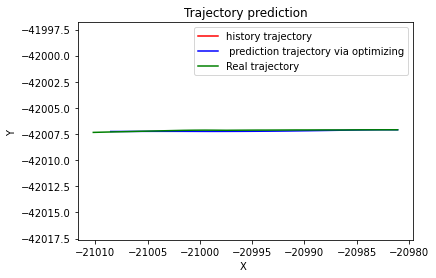

Test loss: 0.008674130575785078
MSE pre: 18.44283549145815
MSE RST: 0.44642041190889875
ADE_rst: 0.8081747222715283
FDE_rst: 1.7114987123355108
ADE_pre: 5.972116067055169
FDE_pre: 8.764182708301787


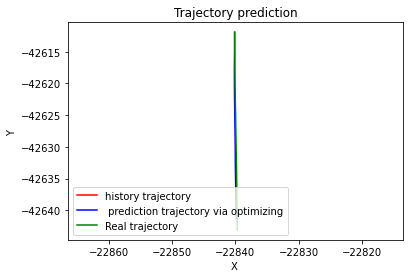

Test loss: 0.009500016705405094
MSE pre: 58.84039944967419
MSE RST: 0.7727684627711282
ADE_rst: 0.9581540880147138
FDE_rst: 2.705560248442636
ADE_pre: 10.655086416651573
FDE_pre: 11.319466955685789


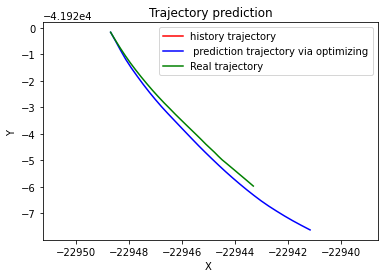

Test loss: 0.007683805427447479
MSE pre: 50.51072191604571
MSE RST: 2.0050555830739243
ADE_rst: 1.5080345181171575
FDE_rst: 4.4830107359889615
ADE_pre: 8.072720717373823
FDE_pre: 14.427222516101141


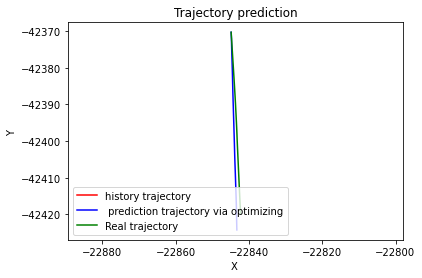

Test loss: 0.009525779632882224
MSE pre: 10.283301457998084
MSE RST: 4.752664481119236
ADE_rst: 2.591850398445671
FDE_rst: 5.380006777914597
ADE_pre: 4.3559877873116095
FDE_pre: 5.525668929595555


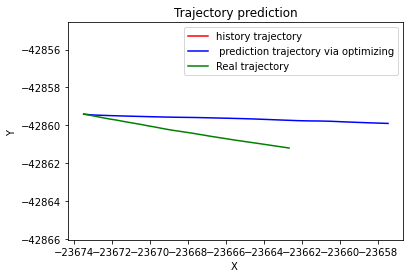

Test loss: 0.008102208209138519
MSE pre: 25.67898528084269
MSE RST: 2.6127773371333363
ADE_rst: 1.9531211817508016
FDE_rst: 3.8335445371896286
ADE_pre: 6.372646625048221
FDE_pre: 4.206301123869132


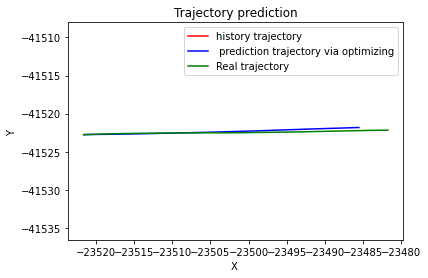

Test loss: 0.009417030941288576
MSE pre: 4.357523595798708
MSE RST: 0.09590085389169156
ADE_rst: 0.33486662713606324
FDE_rst: 1.093068826732806
ADE_pre: 2.616156018105215
FDE_pre: 7.233721919198656


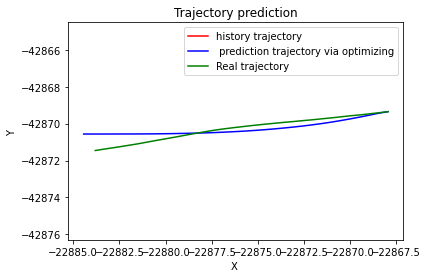

Test loss: 0.009578383476910571
MSE pre: 27.212303303535222
MSE RST: 0.5433011801859063
ADE_rst: 0.8409922407600896
FDE_rst: 1.8127008745303423
ADE_pre: 6.953516701132153
FDE_pre: 4.181387179749379


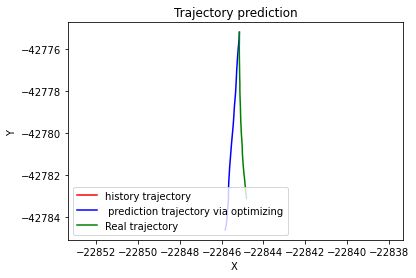

Test loss: 0.00794983483681252
MSE pre: 14.36159080084847
MSE RST: 1.5941661860476255
ADE_rst: 1.3812237551581672
FDE_rst: 3.7809123947859558
ADE_pre: 5.0210011151283975
FDE_pre: 1.196165051745518


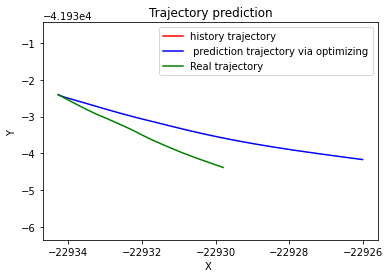

Test loss: 0.01904456319164953
MSE pre: 49.749687020702325
MSE RST: 0.009937410375984937
ADE_rst: 0.1288143937744314
FDE_rst: 0.26156974025128293
ADE_pre: 9.000145488779294
FDE_pre: 5.709798892186585


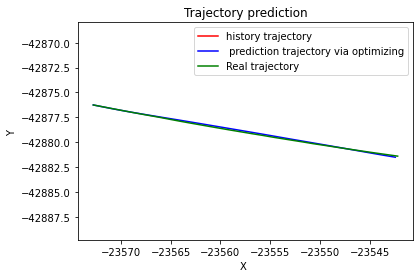

Test loss: 0.008508363480193003
MSE pre: 9.724181725977303
MSE RST: 0.06983407091317013
ADE_rst: 0.3405020571540438
FDE_rst: 0.5043880220793028
ADE_pre: 4.25829694817657
FDE_pre: 2.1982243278358924


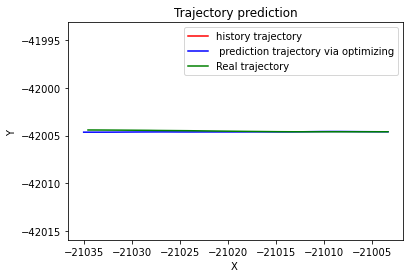

Test loss: 0.008794250490363373
MSE pre: 3.2334362147451805
MSE RST: 0.163187521476502
ADE_rst: 0.4559425137041649
FDE_rst: 1.3258962332762008
ADE_pre: 2.2764889728935636
FDE_pre: 5.756031612610066


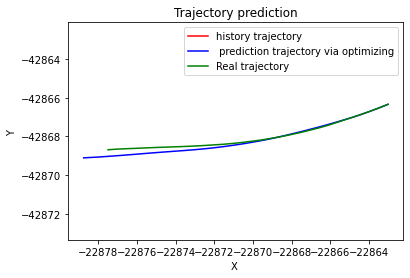

Test loss: 0.010478387366396983
MSE pre: 5.764198165731564
MSE RST: 0.39642365003828195
ADE_rst: 0.6350273679957371
FDE_rst: 2.069214420448905
ADE_pre: 3.002614687663041
FDE_pre: 3.1463176512803557


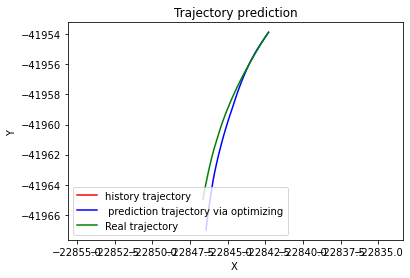

Test loss: 0.009841217763270847
MSE pre: 8.649394353063588
MSE RST: 0.4834687394515221
ADE_rst: 0.7911375791772719
FDE_rst: 2.0558083715838236
ADE_pre: 3.915789178227014
FDE_pre: 2.9686860187292545


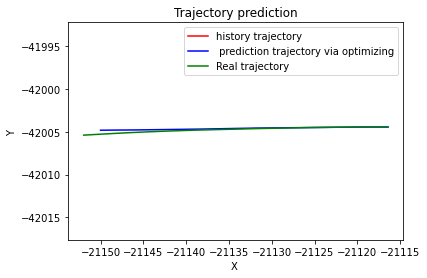

Test loss: 0.012005059757200787
MSE pre: 39.96345474070702
MSE RST: 0.248171315960161
ADE_rst: 0.6099102423971405
FDE_rst: 0.9491233647107805
ADE_pre: 8.044489104272873
FDE_pre: 5.296917574999099


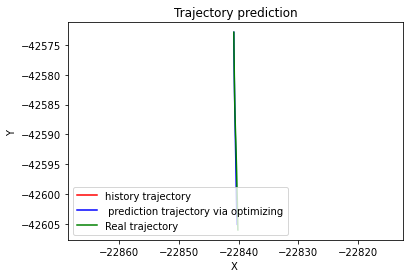

Test loss: 0.010605797055265704
MSE pre: 24.326528279055918
MSE RST: 6.600441707065126
ADE_rst: 2.8997019775591357
FDE_rst: 7.123917063269225
ADE_pre: 6.573858480412977
FDE_pre: 9.871649981573194


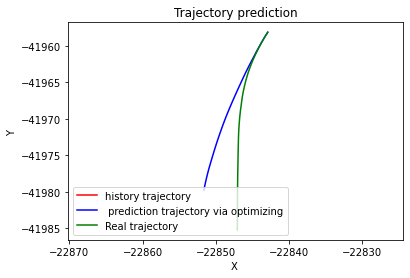

Test loss: 0.00897448482993617
MSE pre: 13.738569403098305
MSE RST: 0.49818482040591405
ADE_rst: 0.714254973496987
FDE_rst: 2.4592540196830286
ADE_pre: 4.660277339310256
FDE_pre: 6.784899897125163


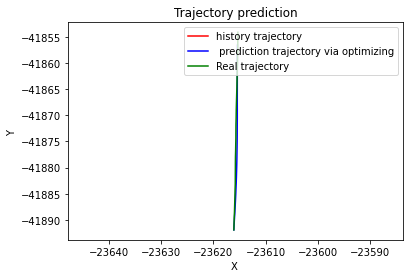

Test loss: 0.009942479400581612
MSE pre: 19.21523666959108
MSE RST: 0.15658878503841103
ADE_rst: 0.46958763194687425
FDE_rst: 1.1005121362547754
ADE_pre: 5.431905385826478
FDE_pre: 1.7435324673901187


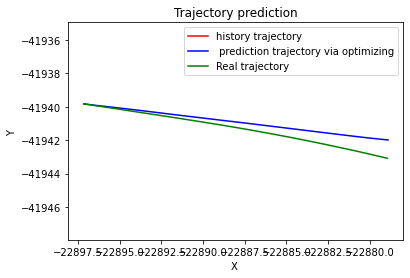

Test loss: 0.010237289878677131
MSE pre: 26.898073207541366
MSE RST: 0.6412922619336456
ADE_rst: 0.7947779143713002
FDE_rst: 2.6419544141784783
ADE_pre: 7.007452023320222
FDE_pre: 4.187386395051846


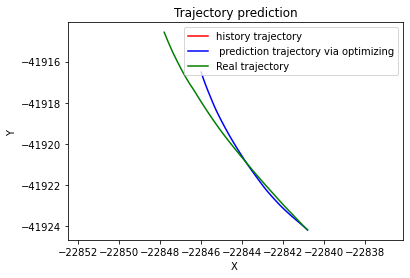

Test loss: 0.009042975571016932
MSE pre: 18.397794906534497
MSE RST: 0.27366718788164973
ADE_rst: 0.5750502177838837
FDE_rst: 1.6881277993429034
ADE_pre: 5.5179570009299255
FDE_pre: 2.7581191167955277


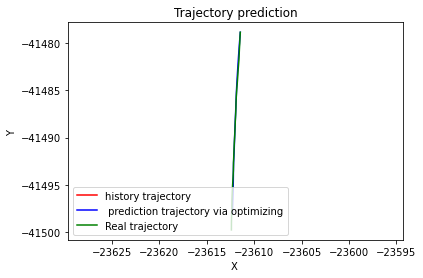

Test loss: 0.009031997612193048
MSE pre: 2.362813174570333
MSE RST: 0.15061866984855768
ADE_rst: 0.4943738669643159
FDE_rst: 0.8069227048973867
ADE_pre: 1.8584459381961886
FDE_pre: 5.683763256872395


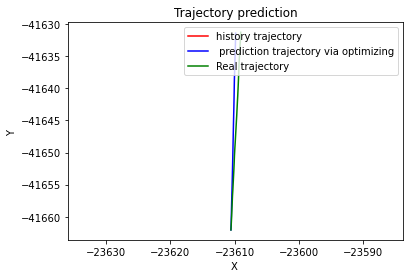

Test loss: 0.009136351101809824
MSE pre: 39.38282611495494
MSE RST: 0.0894458791435217
ADE_rst: 0.3752762821198855
FDE_rst: 0.6845043413934059
ADE_pre: 8.635401615870641
FDE_pre: 4.355222895353836


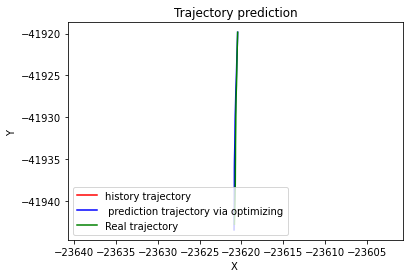

Test loss: 0.009566663896556249
MSE pre: 3.6839313970353182
MSE RST: 0.04362202271900138
ADE_rst: 0.2712161526198917
FDE_rst: 0.14720503901249327
ADE_pre: 2.352541992549062
FDE_pre: 5.896805313487513


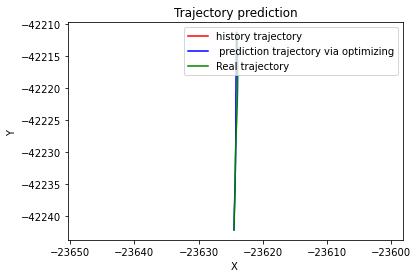

Test loss: 0.008228353491710479
MSE pre: 2.265541534144238
MSE RST: 0.15055672572215809
ADE_rst: 0.5036242626615106
FDE_rst: 0.5490517035198312
ADE_pre: 2.008079613557772
FDE_pre: 2.74306054046514


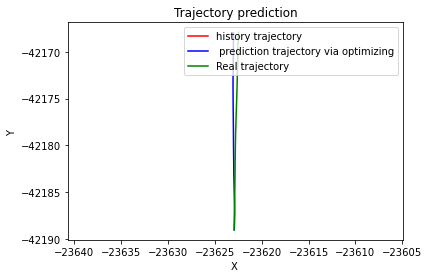

Test loss: 0.013113807660181994
MSE pre: 25.141209925197842
MSE RST: 0.08603862937224475
ADE_rst: 0.2803355008448491
FDE_rst: 1.0323194400831492
ADE_pre: 6.505253325124406
FDE_pre: 4.199212893432347


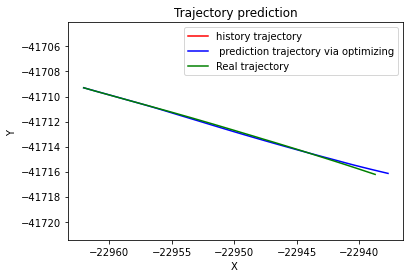

Test loss: 0.009025790992037475
MSE pre: 1.5157472593304306
MSE RST: 3.0819453327308812
ADE_rst: 2.0606609472428037
FDE_rst: 4.4003312262989445
ADE_pre: 1.519240505134448
FDE_pre: 2.0586127230163322


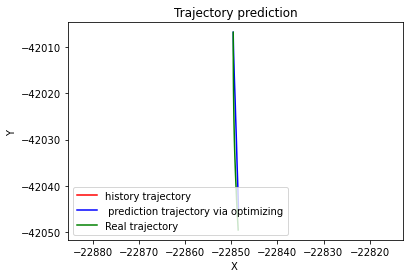

Test loss: 0.008252259696710219
MSE pre: 52.45201369153332
MSE RST: 0.8827024855015609
ADE_rst: 1.040996127454422
FDE_rst: 2.648933339724895
ADE_pre: 9.849000951337702
FDE_pre: 9.255323604719239


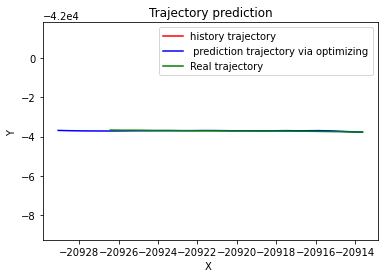

Test loss: 0.008222976099633872
MSE pre: 35.39091121391288
MSE RST: 2.1164715612469696
ADE_rst: 1.8976537129718825
FDE_rst: 2.3719524207168243
ADE_pre: 8.058327823676743
FDE_pre: 5.143071309642763


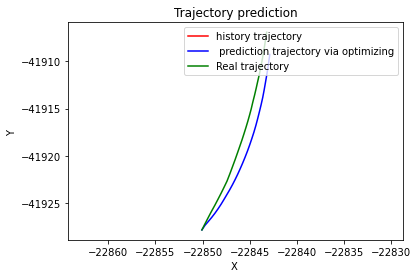

Test loss: 0.013614302994193986
MSE pre: 8.683420983729285
MSE RST: 0.9190422142341385
ADE_rst: 1.149981772860768
FDE_rst: 2.480867979009437
ADE_pre: 3.8423362430537904
FDE_pre: 7.096590446187953


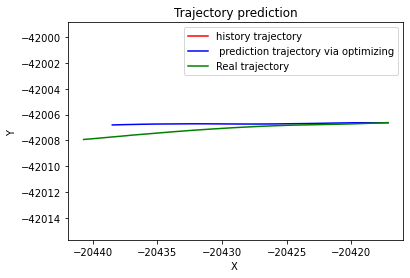

Test loss: 0.007786161035658132
MSE pre: 13.64013636572172
MSE RST: 1.5056675408677653
ADE_rst: 1.3450566025254802
FDE_rst: 3.702652371948275
ADE_pre: 4.929267101780544
FDE_pre: 1.075191907549067


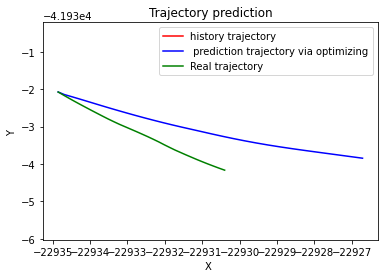

Test loss: 0.007703705424821268
MSE pre: 13.404391845027465
MSE RST: 0.15731486051351518
ADE_rst: 0.36741469956357237
FDE_rst: 1.4568959889250246
ADE_pre: 5.063484358364535
FDE_pre: 5.527296762875339


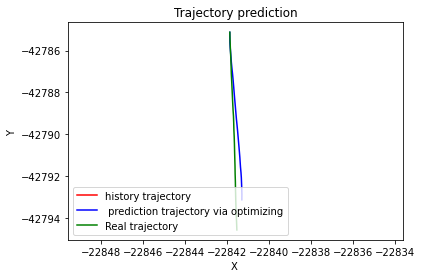

Test loss: 0.008840701319739986
MSE pre: 31.52066072698532
MSE RST: 5.254659259018724
ADE_rst: 2.6958922536522687
FDE_rst: 5.831385288886003
ADE_pre: 7.634433120820279
FDE_pre: 10.953860617534547


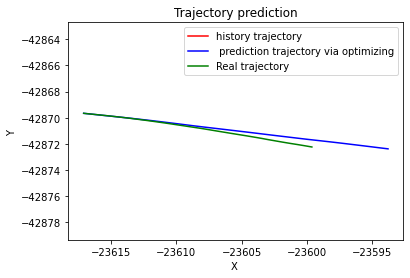

Test loss: 0.00928752006652552
MSE pre: 9.371638690529043
MSE RST: 0.750518229442688
ADE_rst: 0.9153322355349373
FDE_rst: 2.5189433551639517
ADE_pre: 3.5211494197097024
FDE_pre: 10.666480034780195


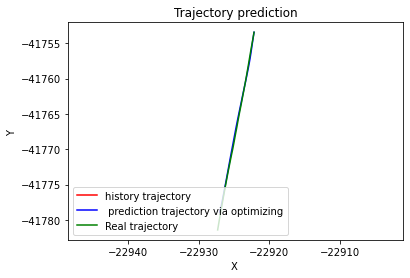

Test loss: 0.00865387050569092
MSE pre: 9.551974943467686
MSE RST: 1.0521595853052994
ADE_rst: 1.1778540366489254
FDE_rst: 2.708061081975315
ADE_pre: 3.956240967859969
FDE_pre: 2.798592116062708


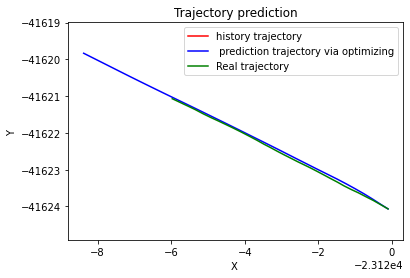

Test loss: 0.009201277943793426
MSE pre: 11.553906540009187
MSE RST: 0.9374039309183263
ADE_rst: 1.1295836321217034
FDE_rst: 2.511522973182166
ADE_pre: 4.614537259795139
FDE_pre: 2.6578200332696924


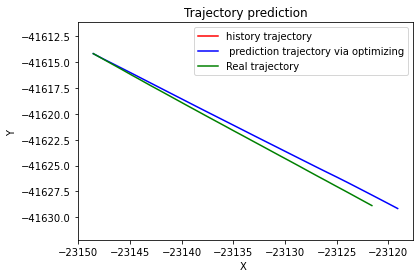

Test loss: 0.00891258807135425
MSE pre: 23.35015307751631
MSE RST: 3.769364819689533
ADE_rst: 2.3670594619425773
FDE_rst: 4.141873525401153
ADE_pre: 6.436261045944596
FDE_pre: 8.46743635487637


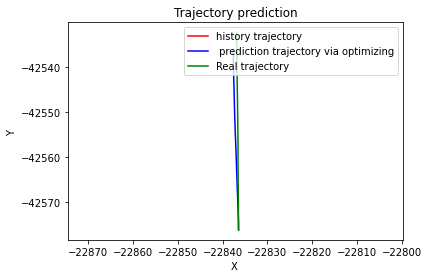

Test loss: 0.015359382689566707
MSE pre: 12.252458907763076
MSE RST: 0.4631325034077205
ADE_rst: 0.7668272577856245
FDE_rst: 1.9476814872917716
ADE_pre: 4.630847691274002
FDE_pre: 0.9598304639665061


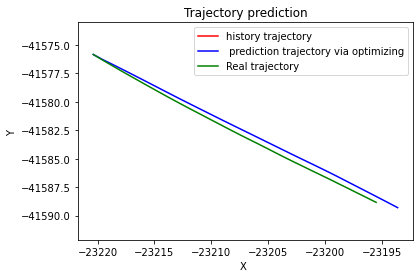

Test loss: 0.009022329442715013
MSE pre: 9.592337762716511
MSE RST: 0.3272747594203047
ADE_rst: 0.7310932138562191
FDE_rst: 1.2787364402817685
ADE_pre: 4.023590413356712
FDE_pre: 8.622266138285303


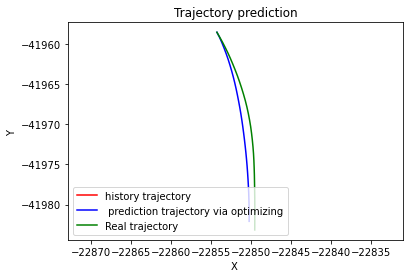

Test loss: 0.008952256597737298
MSE pre: 25.764732374068053
MSE RST: 0.2701983509184213
ADE_rst: 0.6361619101360567
FDE_rst: 1.2497294639400087
ADE_pre: 6.66467342338819
FDE_pre: 5.891348107737769


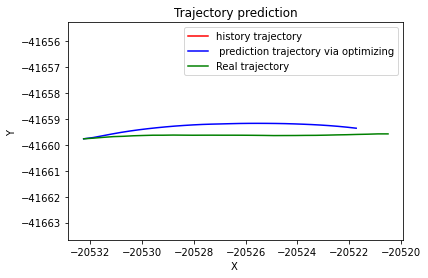

Test loss: 0.010086567199332966
MSE pre: 4.94146500505153
MSE RST: 0.44652606603080275
ADE_rst: 0.8406649388902984
FDE_rst: 1.5500026090756502
ADE_pre: 2.4823956132240506
FDE_pre: 2.078575109650966


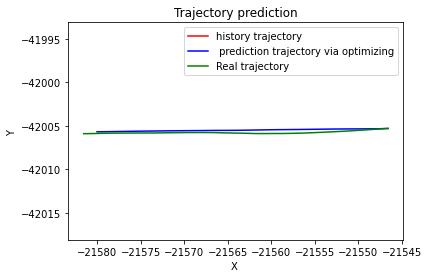

Test loss: 0.00906783088801965
MSE pre: 22.72691365914463
MSE RST: 0.08421094906085212
ADE_rst: 0.34821789998087754
FDE_rst: 0.6714268773550237
ADE_pre: 6.1227032658753675
FDE_pre: 3.618850504053685


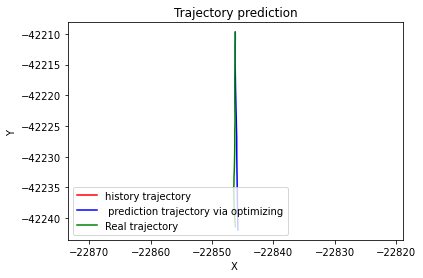

Test loss: 0.008238991379807662
MSE pre: 39.115006661694835
MSE RST: 0.01768672846249584
ADE_rst: 0.16287415721474421
FDE_rst: 0.36087027822804923
ADE_pre: 7.630908493897018
FDE_pre: 4.880497090622261


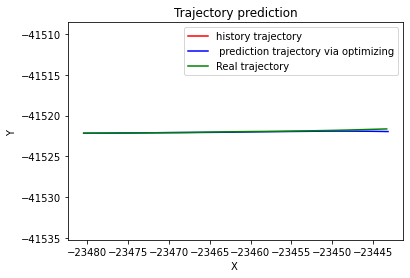

Test loss: 0.006587261259591881
MSE pre: 90.94884747367426
MSE RST: 14.0138778517644
ADE_rst: 4.386955385745816
FDE_rst: 9.493182643530455
ADE_pre: 12.42459334316054
FDE_pre: 6.7813485404316305


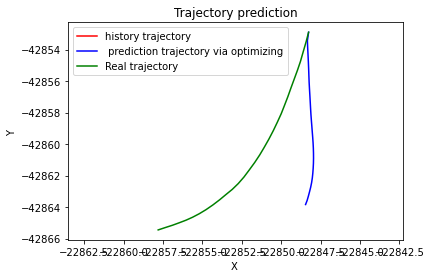

Test loss: 0.009786125769522033
MSE pre: 6.336035034730919
MSE RST: 0.8409117748080133
ADE_rst: 1.0125824651593875
FDE_rst: 2.3592434488683955
ADE_pre: 3.4314904957142276
FDE_pre: 1.9142367987409779


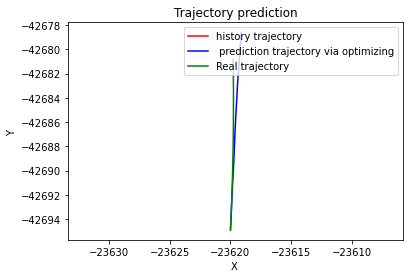

Test loss: 0.011323070891685733
MSE pre: 14.672281727134767
MSE RST: 3.195811332896797
ADE_rst: 2.017788680182625
FDE_rst: 5.0555083876760385
ADE_pre: 5.015706639157336
FDE_pre: 10.267193048570094


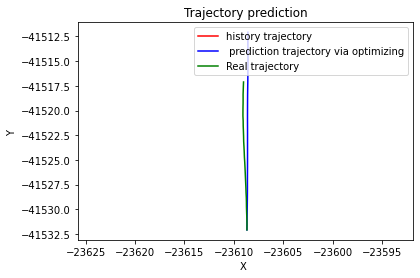

Test loss: 0.015128889640771068
MSE pre: 9.871155154908523
MSE RST: 0.4040491585642433
ADE_rst: 0.6978681744271866
FDE_rst: 1.8842140654343817
ADE_pre: 3.9725737190733423
FDE_pre: 8.041639152923347


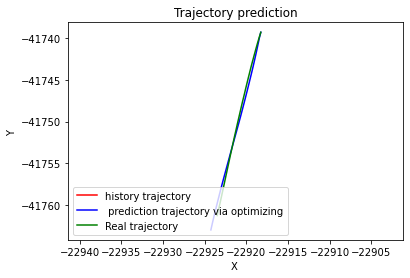

Test loss: 0.013727968515849889
MSE pre: 10.147191666912306
MSE RST: 0.016980676872970765
ADE_rst: 0.17068575006365272
FDE_rst: 0.31631573304256105
ADE_pre: 4.249019408418584
FDE_pre: 3.0102817810728726


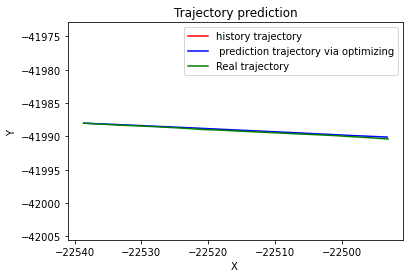

Test loss: 0.009633341189821254
MSE pre: 34.61500295474586
MSE RST: 1.2014495457785175
ADE_rst: 1.2386945705095431
FDE_rst: 3.1468902673837587
ADE_pre: 7.93965358440545
FDE_pre: 10.084418760072383


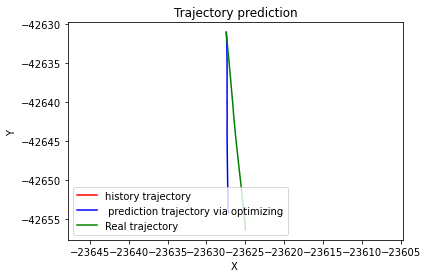

Test loss: 0.010882542509194371
MSE pre: 60.34195793561767
MSE RST: 0.4190344013201455
ADE_rst: 0.7736732709892646
FDE_rst: 1.633113794752557
ADE_pre: 10.19844868773531
FDE_pre: 19.980929610947975


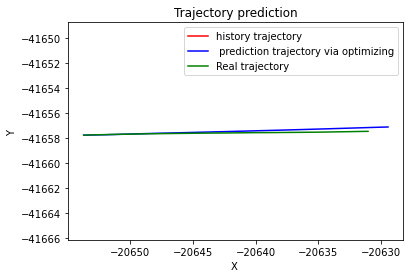

Test loss: 0.010384706862517775
MSE pre: 13.698083513432199
MSE RST: 1.5210239164299775
ADE_rst: 1.2089221827371075
FDE_rst: 3.9560988110407673
ADE_pre: 4.886285465222293
FDE_pre: 8.538306586774763


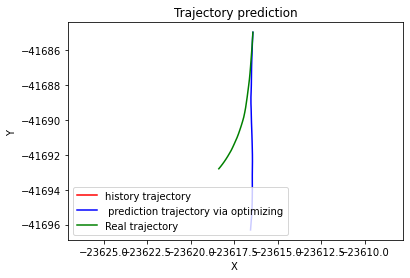

Test loss: 0.00810574327826585
MSE pre: 10.519323899173532
MSE RST: 0.3923597935531514
ADE_rst: 0.8289170883613666
FDE_rst: 0.9487250905505713
ADE_pre: 4.105511865565305
FDE_pre: 7.112711964299461


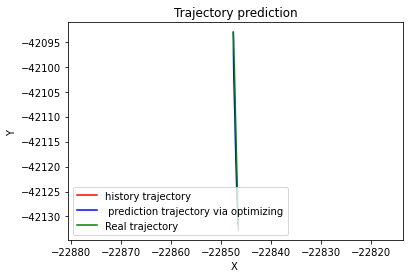

Test loss: 0.006956827333791053
MSE pre: 13.301721136367272
MSE RST: 5.27037666788193
ADE_rst: 2.844763116971402
FDE_rst: 5.095466227920029
ADE_pre: 4.591834808540291
FDE_pre: 3.0339062555919942


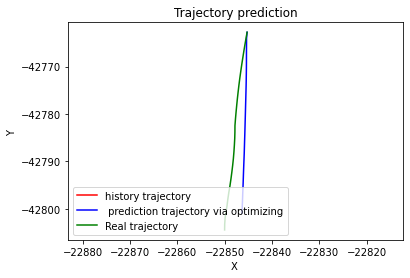

Test loss: 0.008545842286833109
MSE pre: 72.92427349430208
MSE RST: 2.8130858584581895
ADE_rst: 1.9021795556043137
FDE_rst: 4.367536488341312
ADE_pre: 11.4768113204037
FDE_pre: 0.6686036581137295


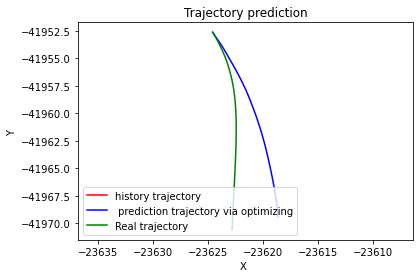

Test loss: 0.007912991032617576
MSE pre: 8.462912164572932
MSE RST: 2.1205842095875385
ADE_rst: 1.6505244099999343
FDE_rst: 3.9174438665723397
ADE_pre: 3.89380298199755
FDE_pre: 3.4414254423673754


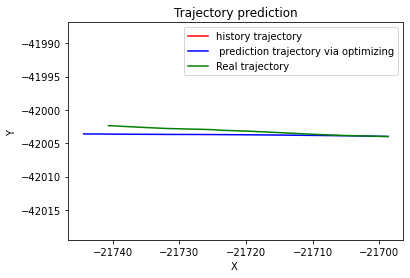

Test loss: 0.008604096993910858
MSE pre: 4.902358500487236
MSE RST: 0.08503189644170613
ADE_rst: 0.38189862440105454
FDE_rst: 0.5312300261631976
ADE_pre: 2.776472662459696
FDE_pre: 4.81107911367503


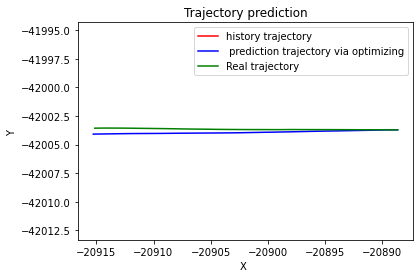

Test loss: 0.009900240333911044
MSE pre: 15.761364602963976
MSE RST: 0.6022271938063765
ADE_rst: 1.013636617854959
FDE_rst: 0.7565292312982219
ADE_pre: 5.557638623803266
FDE_pre: 3.5535778881141757


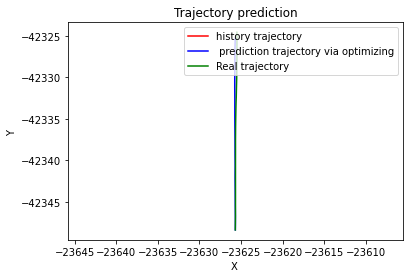

Test loss: 0.007583599312840526
MSE pre: 8.417963259235634
MSE RST: 0.2321098798728034
ADE_rst: 0.5357595451056986
FDE_rst: 1.1741266770069565
ADE_pre: 3.8813753993469233
FDE_pre: 6.369335814066061


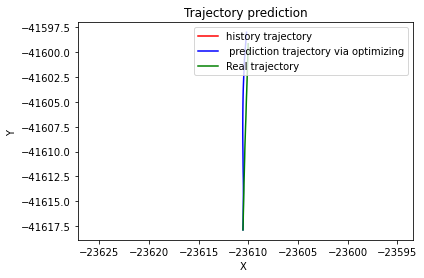

Test loss: 0.01106135996030296
MSE pre: 1.244325213432997
MSE RST: 0.5955469896270065
ADE_rst: 0.9570484241154054
FDE_rst: 1.5704410580439043
ADE_pre: 1.4944719060194684
FDE_pre: 0.7685771084360921


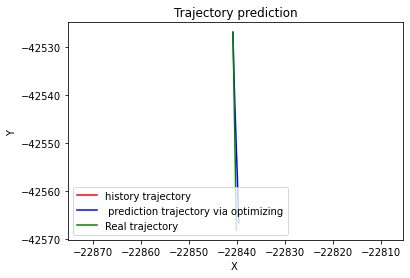

Test loss: 0.01069795316595485
MSE pre: 8.071992328797092
MSE RST: 4.367334714492587
ADE_rst: 2.6283508478926647
FDE_rst: 3.8630068130045343
ADE_pre: 3.789392287492061
FDE_pre: 3.8067410651939797


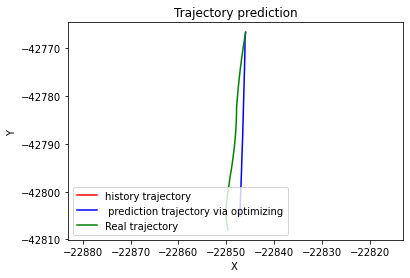

Test loss: 0.010310565290916559
MSE pre: 9.907017801275392
MSE RST: 0.013652434193051932
ADE_rst: 0.13429510031351494
FDE_rst: 0.18521239737215045
ADE_pre: 4.1355689139331435
FDE_pre: 2.736748341965336


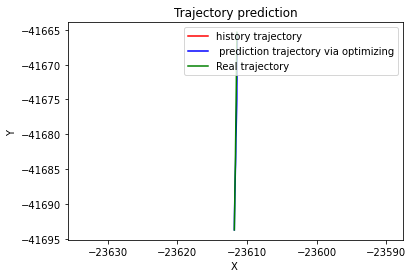

Test loss: 0.00951018484330734
MSE pre: 67.88279817363455
MSE RST: 0.4196456755646305
ADE_rst: 0.8275788310073072
FDE_rst: 1.0877848107833696
ADE_pre: 11.268683539838793
FDE_pre: 13.55527169470618


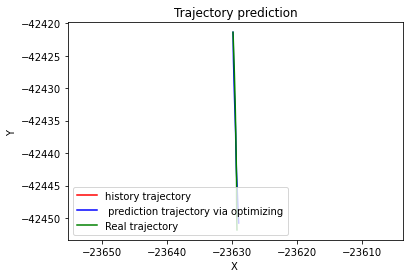

Test loss: 0.00852028926210167
MSE pre: 28.1744524465843
MSE RST: 5.211400219614258
ADE_rst: 2.782298912997166
FDE_rst: 5.241289805962366
ADE_pre: 7.223826644284577
FDE_pre: 8.229432397455934


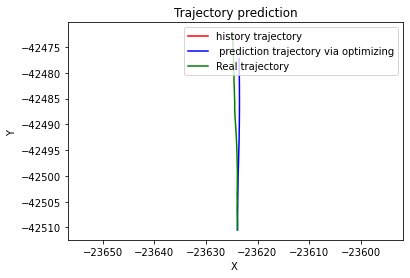

Test loss: 0.010648294163045519
MSE pre: 7.970456541513748
MSE RST: 0.31123692020663657
ADE_rst: 0.5428630640610044
FDE_rst: 1.7021418801214743
ADE_pre: 3.90253852186631
FDE_pre: 2.5804879409791863


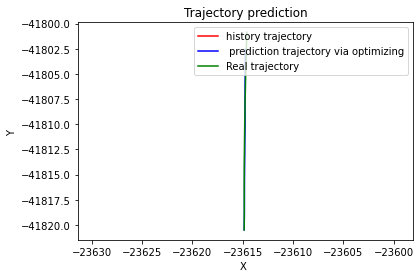

Test loss: 0.009425964560916643
MSE pre: 28.647832153730878
MSE RST: 0.5034583143022979
ADE_rst: 0.8690602319087947
FDE_rst: 1.6715013230314681
ADE_pre: 7.442205411720176
FDE_pre: 4.3126409487507065


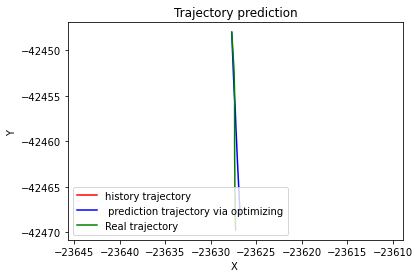

Test loss: 0.010357999842825963
MSE pre: 14.478338363132213
MSE RST: 0.9861977269475516
ADE_rst: 1.226311128027194
FDE_rst: 1.7165972916283139
ADE_pre: 4.404238943257315
FDE_pre: 1.1728442040572868


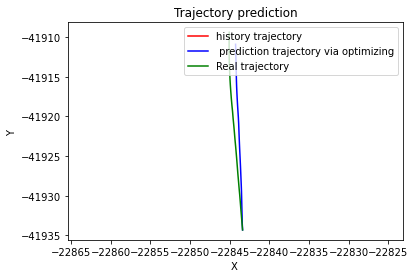

Test loss: 0.009211983983920292
MSE pre: 18.005803620144558
MSE RST: 0.08522436462504399
ADE_rst: 0.38815684076765117
FDE_rst: 0.3494132425100882
ADE_pre: 5.4535938885820165
FDE_pre: 1.947711142532046


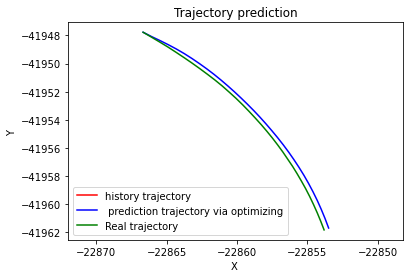

Test loss: 0.006860785040944227
MSE pre: 13.195158241003115
MSE RST: 0.9977014650444557
ADE_rst: 1.1712030214698674
FDE_rst: 2.6516814299170104
ADE_pre: 5.078339193226591
FDE_pre: 4.0478120263389075


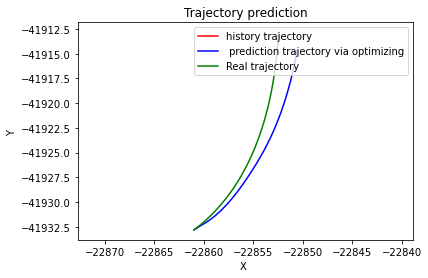

Test loss: 0.009634329383366296
MSE pre: 49.668230078422255
MSE RST: 1.8864186108157452
ADE_rst: 1.5706487554260706
FDE_rst: 3.534197916711015
ADE_pre: 8.462645407582345
FDE_pre: 11.89749255769516


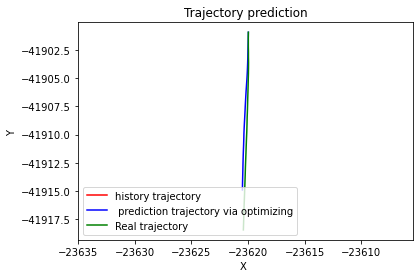

Test loss: 0.009252388503607746
MSE pre: 6.764388711901104
MSE RST: 1.898867337504778
ADE_rst: 1.6194624741753818
FDE_rst: 3.2140163678356197
ADE_pre: 3.2131575983051475
FDE_pre: 9.953657349109003


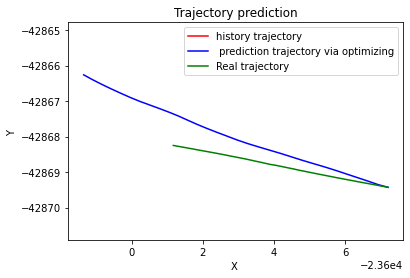

Test loss: 0.008395782281821947
MSE pre: 5.207518913425735
MSE RST: 0.8025839320071645
ADE_rst: 1.0587627466442284
FDE_rst: 2.3639910578563543
ADE_pre: 2.83262713298732
FDE_pre: 3.28741540658586


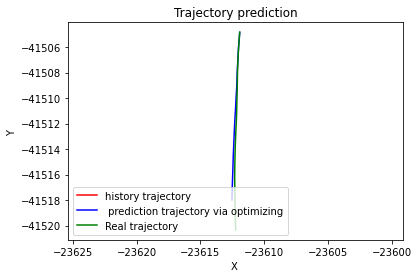

Test loss: 0.011358162189981735
MSE pre: 13.095451509884589
MSE RST: 0.5993344956357256
ADE_rst: 0.783091223024483
FDE_rst: 2.407433448887692
ADE_pre: 4.74637439776394
FDE_pre: 11.69361548778093


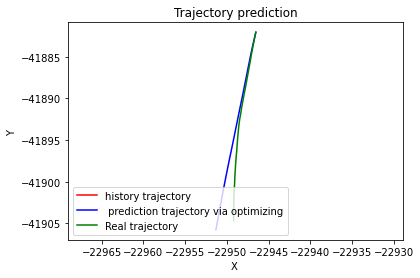

Test loss: 0.009753287342640833
MSE pre: 30.823654414346244
MSE RST: 1.0552773919464093
ADE_rst: 1.1914271767321267
FDE_rst: 2.779274764800738
ADE_pre: 6.281249871808163
FDE_pre: 19.613447925461127


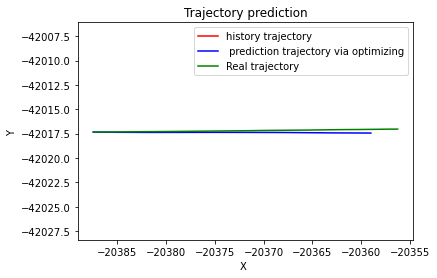

Test loss: 0.010310397603910263
MSE pre: 17.409688928394647
MSE RST: 0.042271520369470614
ADE_rst: 0.23869914581888133
FDE_rst: 0.4658827054189066
ADE_pre: 5.588811286211186
FDE_pre: 7.510591913456343


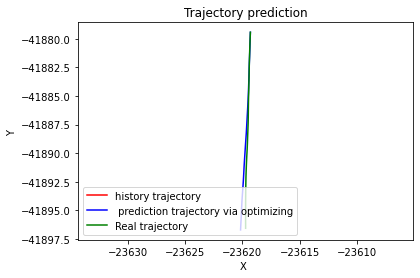

Test loss: 0.00983767734404085
MSE pre: 4.9196421780076935
MSE RST: 0.09907126491029482
ADE_rst: 0.4170384620778447
FDE_rst: 0.6060889580144896
ADE_pre: 2.8661732486906737
FDE_pre: 3.550533977858352


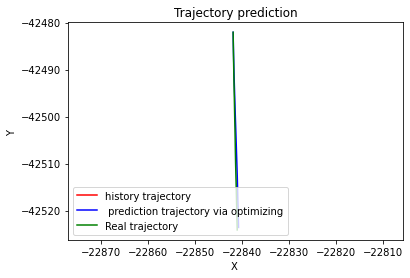

Test loss: 0.00904177362401698
MSE pre: 85.94337440376069
MSE RST: 8.562048603188595
ADE_rst: 3.4148527252358023
FDE_rst: 7.493756654331703
ADE_pre: 12.680812374063875
FDE_pre: 13.660489021026464


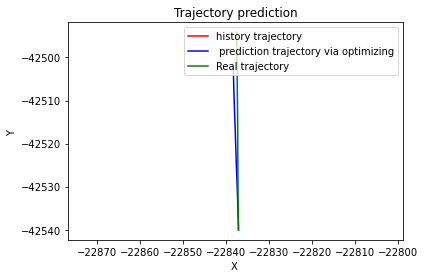

Test loss: 0.012392565679746004
MSE pre: 5.729252355740139
MSE RST: 0.8877830931846004
ADE_rst: 1.0439918613198071
FDE_rst: 0.6257729542502357
ADE_pre: 3.1556282202130297
FDE_pre: 3.895813532975985


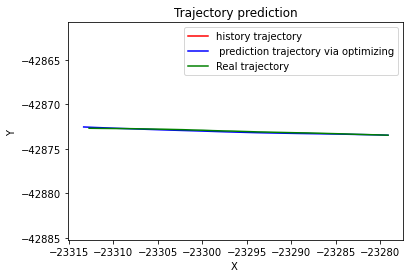

Test loss: 0.009401712616520926
MSE pre: 18.630290859415762
MSE RST: 0.2397992303826868
ADE_rst: 0.4726582623302952
FDE_rst: 1.734751101415319
ADE_pre: 5.774562022864131
FDE_pre: 7.882467955199906


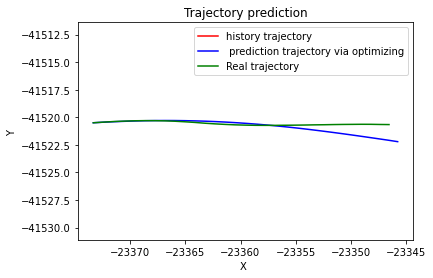

Test loss: 0.007918802769074643
MSE pre: 10.118134093762494
MSE RST: 4.301715647306535
ADE_rst: 2.434553433888607
FDE_rst: 5.448948173987792
ADE_pre: 3.892595905241508
FDE_pre: 6.878970813388824


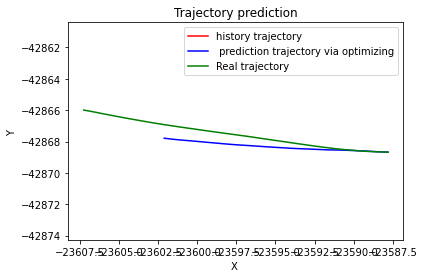

Test loss: 0.0073796054252096765
MSE pre: 9.652454648367748
MSE RST: 0.9339925279059899
ADE_rst: 1.2497907600654523
FDE_rst: 1.7217038511742027
ADE_pre: 3.888913380043923
FDE_pre: 1.4042586369054926


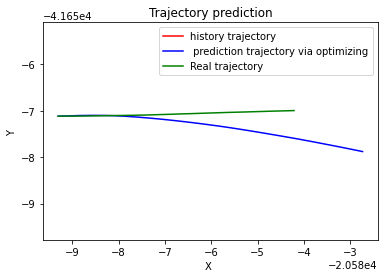

Test loss: 0.01631814969506443
MSE pre: 26.97383912101604
MSE RST: 4.175860290472031
ADE_rst: 2.5224341967944954
FDE_rst: 4.2605891053689575
ADE_pre: 7.230711095910085
FDE_pre: 9.711439898389207


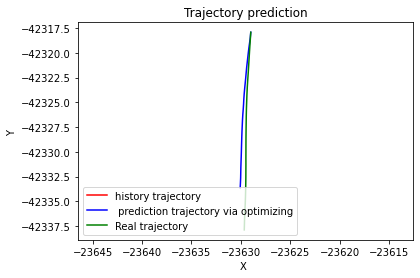

Test loss: 0.018470403737569484
average MSE_pre: 20.84061195930866
average MSE_rst: 1.5076977863132075
average ADE_rst: 1.1585362883426766
average FDE_rst: 2.4975862793236843
average ADE_pre: 5.4511538041401275
average FDE_pre: 6.46656789246874
average loss: 0.010270066781322118


In [11]:
hidden_size = 64
Prednet = TraPred(x.shape[2], y.shape[2], hidden_size, x.shape[0])
Prednet.load_state_dict(torch.load('model/trajectory_predict_1202_43_4_30_new.pt'))
Prednet = Prednet.double()
Prednet = Prednet.to(device)
Prednet.eval()
Eval_net(Prednet, True)

In [12]:
def predict(model,test_load,n,optimizer=False):
    test = iter(test_load)
    x,y =  test.next()
    x,y = x.to(device),y.to(device)
    model.eval()
    predY = model(x)
    criterion = nn.MSELoss()
    test_loss = criterion(predY,y)
    std = WholeSet.std.repeat(x.shape[0],x.shape[1],1)
    std = std[:,:,:4].to(device)
    mn = WholeSet.mn.repeat(x.shape[0],x.shape[1],1)
    mn = mn[:,:,:4].to(device)
    rg = WholeSet.range.repeat(x.shape[0],x.shape[1],1)
    rg = rg[:,:,:4].to(device)
    predY = (predY*(rg*std)+mn).detach().cpu()
    pY = np.array(predY)
    local_labels = (y*(rg*std)+mn).detach().cpu()
    Y = np.array(local_labels)
    pY[:,:-predict_length,:] = Y[:,:-predict_length,:]
    rst_xy = calcu_XY(pY)
    real_predict = torch.from_numpy(Y[:n,-predict_length-1:,2:4])
    rst_predict = torch.from_numpy(rst_xy[:n,-predict_length-1:,:2])
    pre_predict = torch.from_numpy(pY[:n,-predict_length-1:,2:4])
    MSE_pre = criterion(real_predict,pre_predict)
    MSE_rst = criterion(real_predict,rst_predict)
    print("MSE pre:",MSE_pre.item())
    print("MSE RST:",MSE_rst.item())
    plt.plot(Y[:n,:-predict_length,2][0],Y[:n,:-predict_length,3][0],'r',label = 'history trajectory')
    if optimizer:
        plt.plot(rst_xy[:n,-predict_length-1:,0][0],rst_xy[:n,-predict_length-1:,1][0],'b',label="prediction trajectory via optimizing")
#     plt.plot(pY[:n,-predict_length-1:,2][0],pY[:n,-predict_length-1:,3][0],'k',label='prediction trajectory')
    plt.plot(Y[:n,-predict_length-1:,2][0],Y[:n,-predict_length-1:,3][0],'g',label='Real trajectory')
    plt.title('Trajectory prediction')
    plt.xlabel('X ')
    plt.ylabel('Y ')
    plt.axis('equal')
    plt.legend()
    if optimizer:
        plt.savefig("image/trajectory_output_optimization/trajectory_alone.svg",dpi = 600)
    else:
        plt.savefig("image/trajectory_output/trajectory_alone.svg",dpi = 600)
    
    print("Test Loss:",test_loss.item())

torch.Size([128, 31, 43])
MSE pre: 8.637120221967503
MSE RST: 4.689945748229026
Test Loss: 0.009147554308568123


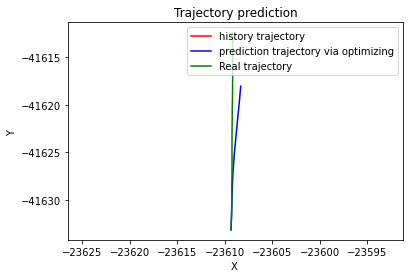

In [14]:
hidden_size = 64
print(x.shape)
Prednet = TraPred(x.shape[2], y.shape[2], hidden_size, x.shape[0])
Prednet.load_state_dict(torch.load('model/trajectory_predict_1202_43_4_30_new.pt'))
Prednet = Prednet.double()
Prednet = Prednet.to(device)
Prednet.eval()
predict(Prednet, Test, 1, True)

In [11]:
test_iter = iter(Test)
x, y = test_iter.next()
print(x.shape)
x,y = x.to(device),y.to(device)
x = x[0][0].view(-1,len(x[0][0])).unsqueeze(0)
predY = Prednet(x)
print(predY)
print(y[0][2])

torch.Size([128, 31, 43])
tensor([[[ 0.6521,  0.0794, -0.0870,  0.5168]]], device='cuda:0',
       dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([ 0.5023,  0.0898, -0.0880,  0.5162], device='cuda:0',
       dtype=torch.float64)


In [14]:
Prednet.load_state_dict(torch.load('model/trajectory_predict_1202_43_4_30_new.pt'))
Prednet.cuda().eval()
from time import time
# An example input you would normally provide to your model's forward() method.
#example = torch.rand(1, 4)

example = torch.ones(1,31,43).double().cuda()
t = time()
out = Prednet(example)
print('time',(time()-t)*1000)
print(out)
# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(Prednet, example)
traced_script_module.save("model/trajectory_prediction_LSTM_1202_31_30_cuda.pt")
example1 = torch.zeros(1,31,43).double().cuda()
out = traced_script_module(example)
out1 = traced_script_module(example1)
print(out)
#print(out1)

time 6.470918655395508
tensor([[[0.0876, 1.9110, 0.9300, 1.1280],
         [0.0862, 1.9101, 0.9285, 1.1229],
         [0.0810, 1.9088, 0.9268, 1.1210],
         [0.0767, 1.9080, 0.9259, 1.1203],
         [0.0741, 1.9077, 0.9252, 1.1199],
         [0.0724, 1.9069, 0.9247, 1.1196],
         [0.0712, 1.9058, 0.9243, 1.1194],
         [0.0702, 1.9048, 0.9240, 1.1193],
         [0.0692, 1.9043, 0.9237, 1.1192],
         [0.0685, 1.9042, 0.9235, 1.1191],
         [0.0680, 1.9043, 0.9234, 1.1190],
         [0.0677, 1.9043, 0.9233, 1.1189],
         [0.0675, 1.9040, 0.9233, 1.1188],
         [0.0672, 1.9032, 0.9232, 1.1186],
         [0.0668, 1.9018, 0.9232, 1.1184],
         [0.0662, 1.8999, 0.9231, 1.1181],
         [0.0654, 1.8978, 0.9231, 1.1178],
         [0.0644, 1.8960, 0.9230, 1.1176],
         [0.0632, 1.8947, 0.9230, 1.1175],
         [0.0619, 1.8939, 0.9229, 1.1175],
         [0.0605, 1.8934, 0.9229, 1.1176],
         [0.0590, 1.8929, 0.9228, 1.1176],
         [0.0574, 1.8925, 0.922

In [13]:
import numpy as np
std = WholeSet_train.std.detach().cpu().numpy()    
mn = WholeSet_train.mn.detach().cpu().numpy() 
print(mn)
#rg = WholeSet_train.range.detach().cpu().numpy()    
#np.savetxt("std.txt", std)
#np.savetxt("mean.txt", mn)
#np.savetxt("rg.txt", rg)
m= torch.from_numpy(np.loadtxt('mean.txt'))
print(m)

[ 6.75118515e-01 -6.49453829e-01 -2.27846678e+04 -4.21421099e+04
  8.35478883e+00  2.61211556e-02 -2.81239278e-02 -1.04840903e+00
 -4.42301211e+00  4.66435161e+00  1.41703086e+00  8.40191559e-03
 -2.58998793e-01 -9.78175015e-01  4.08652899e+00  4.31678855e+00
  1.35872344e+00  1.26075021e-02 -2.34929517e-01  2.22529777e-02
 -6.55926642e+00  6.57110785e+00  1.96451567e+00  6.65455234e-03
  1.23370118e-03  5.93764499e-02  6.23357404e+00  6.24639411e+00
  1.87826875e+00  1.05690945e-02  3.56244772e-02  1.06779971e+00
 -4.49116522e+00  4.74175295e+00  1.28404156e+00  9.35965955e-03
  2.17534460e-01  1.07416996e+00  4.43973892e+00  4.70448066e+00
  1.29446112e+00  7.21403978e-03  1.97882094e-01]
tensor([ 6.7512e-01, -6.4945e-01, -2.2785e+04, -4.2142e+04,  8.3548e+00,
         2.6121e-02, -2.8124e-02, -1.0484e+00, -4.4230e+00,  4.6644e+00,
         1.4170e+00,  8.4019e-03, -2.5900e-01, -9.7818e-01,  4.0865e+00,
         4.3168e+00,  1.3587e+00,  1.2608e-02, -2.3493e-01,  2.2253e-02,
        